# Beam Training using Fully Connected Neural Networks
The first section loads the data, while the next two sections run FC NNs for beam training via classification and regression.

This notebook is built to run with the real data (pRx data from the TG sounders)

## THIS NOTEBOOK SAVES RESULTS FOR THE FIRST SET OF EXPERIMENTAL RESULTS

## DO NOT MODIFY THIS NOTEBOOK (unless for additional analysis of prior results)

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import comb

print(tf.__version__)

2.1.0


# Load data
Load data for a given SNR.  Repeat this cell for every SNR run.

In [40]:
### Load Simulation data ###
# Run this NN version off of CSV files containing different SNR data

## Dataset Constants
ANGLE_MAX = 60
ANGLE_MIN = -60
SNR_MIN = -15
SNR_MAX = 30
SNR_STEP = 5
SNR = np.arange(SNR_MIN, SNR_MAX+SNR_STEP, SNR_STEP)  # Parameter for which data file to pull
print(SNR)

## Configurable Constants
TEST_FRAC = 0.1
VAL_FRAC = 0.2
TRAIN_FRAC = 0.7

NUM_MEAS = 5               # Number of PN beams/measurements/features to use (5, 10, 15 typically)
SHUFFLE_DATA = True         # Shuffle data points for training, validation, and test datasets
USE_POWER_RSS = True        # Use power representation for RSS (instead of straight magnitude)
USE_DISCRETE_RSS = False    # TODO: Use a discrete RSS value (instead of a fully continuous one)

NUM_CLASSES = 20 # Arbitrary number of beams
#NUM_CLASSES = 41 # 120/(105/36) = Number of beams needed for a reference beam width (rule of thumb pencil beam)
BEAM_ANGLES = np.linspace(ANGLE_MIN, ANGLE_MAX, NUM_CLASSES+1).astype(int)  # Beam angles are the edges of each class/beam
CLASSES = BEAM_ANGLES[1:] - (BEAM_ANGLES[1]-BEAM_ANGLES[0])/2               # Classes are the center of each beam
print(CLASSES)

## Storage dictionaries/running variables
train_data_dict = {}
test_data_dict = {}
val_data_dict = {}
train_angles_dict = {}
test_angles_dict = {}
val_angles_dict = {}
train_labels_dict = {}
test_labels_dict = {}
val_labels_dict = {}

NUM_DATA = 0


### Loop through all SNR values ###
for SNR_i in SNR:
    ## Data Files
    DATA_FILE = "../data/measurement_RSS_{}dB.csv".format(SNR_i)
    LABEL_FILE = "../data/label_{}dB.csv".format(SNR_i)

    ## Import the data from CSV files (generated in Matlab) and convert to the original array formats
    df_data  = pd.read_csv(DATA_FILE, header=None)     # Data represented as RSS
    df_labels = pd.read_csv(LABEL_FILE, header=None)   # Labels in radians; need to convert to degrees and also to discrete angles
    df_data = df_data.T                                # Transpose to match new data format (want data points stacked)
    df_labels = df_labels.T                            # Transpose to match the data

    ## Generate the necessary constants
    NUM_DATA_i, NUM_MEAS_AVAIL = df_data.shape
    NUM_DATA += NUM_DATA_i
    NUM_TRAIN = int(np.floor(NUM_DATA_i*TRAIN_FRAC))
    NUM_TEST = int(np.ceil(NUM_DATA_i*TEST_FRAC))
    NUM_VAL = int(NUM_DATA_i - NUM_TRAIN - NUM_TEST)
    print("{} SNR -- Data shape: {}".format(SNR_i, df_data.shape))
    print("\tNumber of meas. available: {}".format(NUM_MEAS_AVAIL))
    print("\tNumber for training:       {}".format(NUM_TRAIN))
    print("\tNumber for validation:     {}".format(NUM_VAL))
    print("\tNumber for testing:        {}".format(NUM_TEST))

    ## Format labels to work for classification (range from 0 to N_classes)
    labels_raw = df_labels.to_numpy()
    angles = labels_raw * 180/np.pi                                     # Convert the angles from radians to degrees
    print("\tAngle range: [{},{}]".format(min(angles), max(angles)))
    print("\tNum Unique angles: {}".format(np.unique(angles).shape))

    labels = np.zeros_like(labels_raw)                                  # Running variable for the labels (discrete angles)
    for class_i in np.arange(NUM_CLASSES):                              # Convert each range of angles to the appropriate index
        angle_lower = BEAM_ANGLES[class_i] - 1*(class_i == 0)           # Adjusted angle range to account for rounding error
        angle_upper = BEAM_ANGLES[class_i + 1] + 1*(class_i == (NUM_CLASSES-1))
        labels_temp = class_i * ((angles >= angle_lower) & (angles < angle_upper))
        labels = labels + labels_temp

    ## Generate index lists for each dataset
    ind = np.arange(NUM_DATA_i)
    # Shuffle the indices / Randomize the data
    if SHUFFLE_DATA:
        np.random.shuffle(ind)
    train_ind = ind[0:NUM_TRAIN]
    test_ind = ind[NUM_TRAIN:(NUM_TRAIN+NUM_TEST)]
    if NUM_VAL > 0:
        val_ind = ind[(NUM_TRAIN+NUM_TEST):NUM_DATA_i]

    ## Select the training, validation, and test data
    train_data = df_data.to_numpy()[train_ind].astype('float32')
    train_labels = labels[train_ind].astype('float32')
    train_angles = angles[train_ind].astype('float32')
    test_data = df_data.to_numpy()[test_ind].astype('float32')
    test_labels = labels[test_ind].astype('float32')
    test_angles = angles[test_ind].astype('float32')
    print("\tTraining data: {}; labels: {}".format(train_data.shape, train_labels.shape))
    print("\tTesting data:  {}; labels: {}".format(test_data.shape, test_labels.shape))
    if NUM_VAL > 0:
        val_data = df_data.to_numpy()[val_ind].astype('float32')
        val_labels = labels[val_ind].astype('float32')
        val_angles = angles[val_ind].astype('float32')
        print("\tValidation data: {}; labels: {}".format(val_data.shape, val_labels.shape))
        
    ## Manipulate the data as required: Reduced measurements, RSS as discrete/as power
    if (NUM_MEAS > 0) and (NUM_MEAS < NUM_MEAS_AVAIL):
        train_data = train_data[:, :NUM_MEAS]
        test_data = test_data[:, :NUM_MEAS]
        val_data = val_data[:, :NUM_MEAS]
        
    if USE_POWER_RSS:         # Convert the RSS data into power (in dB)
        train_data = 20*np.log10(train_data)
        test_data = 20*np.log10(test_data)
        val_data = 20*np.log10(val_data)
        
    if USE_DISCRETE_RSS:      # Convert the RSS data into quantized numbers
        #TODO: implement this; do some rounding thing
        pass

    ## Store the data into the dictionaries
    train_data_dict[SNR_i] = train_data
    test_data_dict[SNR_i] = test_data
    val_data_dict[SNR_i] = val_data
    train_angles_dict[SNR_i] = train_angles
    test_angles_dict[SNR_i] = test_angles
    val_angles_dict[SNR_i] = val_angles
    train_labels_dict[SNR_i] = train_labels
    test_labels_dict[SNR_i] = test_labels
    val_labels_dict[SNR_i] = val_labels

    
### Final variable cleanup ###
train_data_all = np.array([])
train_labels_all = np.array([])
train_angles_all = np.array([])
val_data_all = np.array([])
val_labels_all = np.array([])
val_angles_all = np.array([])
importeddata = False
print("Creating total training/validation datasets:")
for snr_i in np.arange(len(train_data_dict)):
    print("\ttrain: {}, val: {}".format(train_data_dict[SNR[snr_i]].shape, val_data_dict[SNR[snr_i]].shape))
    if not importeddata:
        train_data_all = train_data_dict[SNR[snr_i]]
        train_labels_all = train_labels_dict[SNR[snr_i]]
        train_angles_all = train_angles_dict[SNR[snr_i]]
        val_data_all = val_data_dict[SNR[snr_i]]
        val_labels_all = val_labels_dict[SNR[snr_i]]
        val_angles_all = val_angles_dict[SNR[snr_i]]
        importeddata = True
    else:
        train_data_all = np.vstack((train_data_all, train_data_dict[SNR[snr_i]]))
        train_labels_all = np.vstack((train_labels_all, train_labels_dict[SNR[snr_i]]))
        train_angles_all = np.vstack((train_angles_all, train_angles_dict[SNR[snr_i]]))
        val_data_all = np.vstack((val_data_all, val_data_dict[SNR[snr_i]]))
        val_labels_all = np.vstack((val_labels_all, val_labels_dict[SNR[snr_i]]))
        val_angles_all = np.vstack((val_angles_all, val_angles_dict[SNR[snr_i]]))

NUM_TRAIN = int(train_data_all.shape[0])
NUM_VAL = int(val_data_all.shape[0])
NUM_TEST = int(NUM_DATA - NUM_TRAIN - NUM_VAL)
print("Total training dataset size:   {}".format(train_data_all.shape))
print("Total validation dataset size: {}".format(val_data_all.shape))


[-15 -10  -5   0   5  10  15  20  25  30]
[-57. -51. -45. -39. -33. -27. -21. -15.  -9.  -3.   3.   9.  15.  21.
  27.  33.  39.  45.  51.  57.]
-15 SNR -- Data shape: (10000, 36)
	Number of meas. available: 36
	Number for training:       7000
	Number for validation:     2000
	Number for testing:        1000
	Angle range: [[-60.00014031],[59.97722199]]
	Num Unique angles: (9722,)
	Training data: (7000, 36); labels: (7000, 1)
	Testing data:  (1000, 36); labels: (1000, 1)
	Validation data: (2000, 36); labels: (2000, 1)
-10 SNR -- Data shape: (10000, 36)
	Number of meas. available: 36
	Number for training:       7000
	Number for validation:     2000
	Number for testing:        1000
	Angle range: [[-60.00014031],[59.97722199]]
	Num Unique angles: (9722,)
	Training data: (7000, 36); labels: (7000, 1)
	Testing data:  (1000, 36); labels: (1000, 1)
	Validation data: (2000, 36); labels: (2000, 1)
-5 SNR -- Data shape: (10000, 36)
	Number of meas. available: 36
	Number for training:       7000
	

Processing date: 20-04-16, TXIDX: 21, SNR: 21, Type: ext
	DFT data:  (1787, 64)
	PN data:   (1787, 36)
	Labels:    (1787, 1)
Processing date: 20-04-15, TXIDX: 15, SNR: 15, Type: ext
	DFT data:  (1722, 64)
	PN data:   (1722, 36)
	Labels:    (1722, 1)
Processing date: 20-04-20, TXIDX: 12, SNR: 12, Type: ext
	DFT data:  (1728, 64)
	PN data:   (1728, 36)
	Labels:    (1728, 1)
Num DFT beams to use:  51
Num samples to use:    4958
Num PN beam combos:    1
	NOT USING RANDOM BEAMS -> FIRST 2 PN MEASUREMENTS USED!


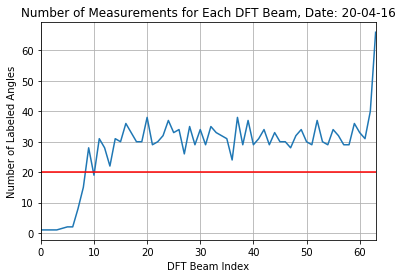

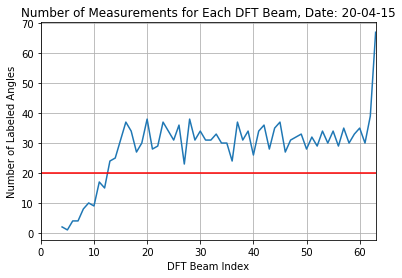

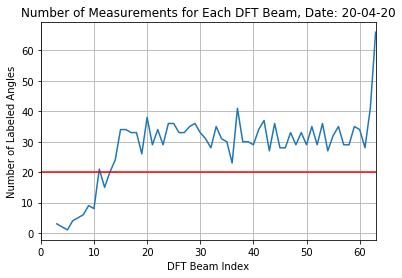

In [241]:
### Load Experimental Data ###
## Dataset Constants
DATA_DATES = ["20-04-16", "20-04-15", "20-04-20"]
DATA_TXIDX = [21, 15, 12]
DATA_SNR = [21, 15, 12] #TODO: FIX THIS NUMBER
# DATA_DATES = ["20-04-15"]
# DATA_TXIDX = [15]
# DATA_SNR = [15] #TODO: FIX THIS NUMBER
NUM_DFT = 64                # Number of DFT beams measured
NUM_ANGLES_PER_DFT = 20     # Number of measurements to use for a DFT (per each date; minimum required to be included)
NUM_TOTAL_MEAS = 36         # Number of total PN beam/measurements/features collected (in a file)
NUM_MEAS = 2               # Number of PN beams/measurements/features to use (5, 10, 15 typically) #TODO: NEED TO CHOOSE THE ANGLES SOMEHOW
NUM_PN_COMBO = 1           # Number of random combinations of measurements to run with the algorithm (to ensure the results aren't dependent on beam)(limit NUM_TOTAL_MEAS choose NUM_MEAS)
                            # Set the NUM_PN_COMBO to 1 for the first NUM_MEAS PN beams (i.e. NOT random)
    
DATA_LINEAR_SCALE = True   # Rescale the data from log to linear (pRx is in dB)
DATA_ZERO_MEAN = False      # Offset the data by the mean features of the training data (same offset used for test data)
DATA_NORMALIZATION = True  # Scale the data (training and testing) to the maximum norm of the training data
DATA_TYPE = "ext"          # Qualifier for the data type ("ext" = normalized_extended OR "avg" = normalized)

DATA_DFT_FILESTEM = "../data/results_awv0_{}_{}_dft.csv"
DATA_PN_FILESTEM = "../data/results_awv0_{}_{}_pn.csv"
DATA_LABELS_FILESTEM = "../data/results_awv0_{}_{}_labels.csv"

## Computed Constants
NUM_DATES = len(DATA_DATES)
max_pn_combos = comb(NUM_TOTAL_MEAS, NUM_MEAS)
if (NUM_PN_COMBO > max_pn_combos):
    NUM_PN_COMBO = max_pn_combos.astype(int)

# Compute the PN beams to use for each PN combo set (number of combos = NUM_PN_COMBO)
PN_USE_BEAMS = np.zeros((NUM_PN_COMBO, NUM_MEAS))
if NUM_PN_COMBO > 1:
    # Using more than 1 combo -> randomly choose the combinations of beams
    for pn_i in np.arange(NUM_PN_COMBO):
        PN_USE_BEAMS[pn_i, :] = np.random.choice(NUM_TOTAL_MEAS, NUM_MEAS, replace=False)
elif NUM_PN_COMBO == 1:
    # Using only 1 combo -> Use the first NUM_MEAS beams
    PN_USE_BEAMS[0, :] = np.arange(NUM_MEAS)
else:
    # Invalid number of combos -> error out
    print("INVALID NUMBER OF PN MEASUREMENTS {} -- RERUN WITH A NEW NUMBER".format(NUM_PN_COMBO))
    
PN_USE_BEAMS = PN_USE_BEAMS.astype(int)

## Loop through each test date and determine the data to use
dft_use_all = np.zeros((NUM_DATES, NUM_DFT))
dft_use_all_num = np.zeros((NUM_DATES, NUM_DFT))
for date_i in np.arange(NUM_DATES):

    ## Get the file names
    print("Processing date: {}, TXIDX: {}, SNR: {}, Type: {}".format(DATA_DATES[date_i], DATA_TXIDX[date_i], DATA_SNR[date_i], DATA_TYPE))
    dft_file = DATA_DFT_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    pn_file = DATA_PN_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    labels_file = DATA_LABELS_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    SNR_i = DATA_SNR[date_i]

    ## Extract the data into Pandas dataframes
    # Number of rows = number of measurements/physical angles
    # Number of columns = number of beams (for DFT and PN; labels should only have 1)
    df_dft = pd.read_csv(dft_file, header=None)
    df_pn = pd.read_csv(pn_file, header=None)
    df_labels = pd.read_csv(labels_file, header=None)
    print("\tDFT data: ", df_dft.shape)
    print("\tPN data:  ", df_pn.shape)
    print("\tLabels:   ", df_labels.shape)

    ## Pickout the data to use
    u, c = np.unique(df_labels, return_counts=True)
    plt.figure()
    plt.plot(u, c)
    plt.title("Number of Measurements for Each DFT Beam, Date: {}".format(DATA_DATES[date_i]))
    plt.xlabel("DFT Beam Index")
    plt.ylabel("Number of Labeled Angles")
    plt.grid(True)
    plt.xlim(0, 63)
    plt.axhline(y=NUM_ANGLES_PER_DFT, color='r', linestyle='-')

    # Pick the DFT indices just based on meeting the minimum number of angles required
    dft_valid_mask = u[c >= NUM_ANGLES_PER_DFT].astype(int)
    dft_use_all[date_i, dft_valid_mask] = True
    dft_use_all_num[date_i, dft_valid_mask] = c[c >= NUM_ANGLES_PER_DFT]
    
pick_dft = np.all(dft_use_all, 0)
dft_use = np.nonzero(pick_dft)[0]
dft_use_num = dft_use_all_num[:,pick_dft].astype(int)
NUM_CLASSES = len(dft_use)
print("Num DFT beams to use: ", NUM_CLASSES)
print("Num samples to use:   ", np.sum(dft_use_num))
print("Num PN beam combos:   ", NUM_PN_COMBO)
if NUM_PN_COMBO == 1:
    print("\tNOT USING RANDOM BEAMS -> FIRST {} PN MEASUREMENTS USED!".format(NUM_MEAS))

In [242]:
# Running dictonaries for the data
train_data_dict = {}
test_data_dict = {}
#val_data_dict = {}
train_labels_dict = {}
test_labels_dict = {}
#val_labels_dict = {}
train_classes_dict = {}
test_classes_dict = {}
dft_rssi_dict = {}

# The actual loop
for date_i in np.arange(NUM_DATES):

    ## Get the file names
    print("Processing date: {}, TXIDX: {}, SNR: {}, Type: {}".format(DATA_DATES[date_i], DATA_TXIDX[date_i], DATA_SNR[date_i], DATA_TYPE))
    dft_file = DATA_DFT_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    pn_file = DATA_PN_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    labels_file = DATA_LABELS_FILESTEM.format(DATA_DATES[date_i], DATA_TYPE)
    SNR_i = DATA_SNR[date_i]

    ## Extract the data into Pandas dataframes
    # Number of rows = number of measurements/physical angles
    # Number of columns = number of beams (for DFT and PN; labels should only have 1)
    df_dft = pd.read_csv(dft_file, header=None)
    df_pn = pd.read_csv(pn_file, header=None)
    df_labels = pd.read_csv(labels_file, header=None)
    print("\tDFT data: ", df_dft.shape)
    print("\tPN data:  ", df_pn.shape)
    print("\tLabels:   ", df_labels.shape)
    arr_pn = df_pn.to_numpy()
    arr_dft = df_dft.to_numpy()

#     ## Pickout the data to use
#     u, c = np.unique(df_labels, return_counts=True)
#     plt.figure()
#     plt.plot(u, c)
#     plt.title("Number of Measurements for Each DFT Beam, Date: {}".format(DATA_DATES[date_i]))
#     plt.xlabel("DFT Beam Index")
#     plt.ylabel("Number of Labeled Angles")
#     plt.grid(True)
#     plt.xlim(0, 63)
#     plt.axhline(y=NUM_ANGLES_PER_DFT, color='r', linestyle='-')

#     # Pick the DFT indices just based on meeting the minimum number of angles required
#     dft_use = u[c >= NUM_ANGLES_PER_DFT].astype(int)
#     dft_use_num = c[c >= NUM_ANGLES_PER_DFT]
    
    # Running dictionary for the data for each PN beam combo
    train_data_datei_dict = {}
    test_data_datei_dict = {}
    #val_data_datei_dict = {}
    train_labels_datei_dict = {}
    test_labels_datei_dict = {}
    #val_labels_datei_dict = {}
    train_classes_datei_dict = {}
    test_classes_datei_dict = {}
    dft_rssi_datei_dict = {}
    
    # Loop through all the PN beam combos
    for pn_i in np.arange(NUM_PN_COMBO):

        # Choose the points randomly from the points available (per each used DFT beam)
        train_data = np.array([])
        train_labels = np.array([])
        test_data = np.array([])
        test_labels = np.array([])
        train_classes = np.array([])
        test_classes = np.array([])
        test_dftrssi = np.array([])
        
        for dft_i in np.arange(len(dft_use)):

            # Find all potential PN beam measurements to use for this DFT beam label
            wh = np.where(df_labels == dft_use[dft_i])
            pn_all_i_temp = arr_pn[wh[0], :]
            pn_all_i = pn_all_i_temp[:,PN_USE_BEAMS[pn_i]]
            dft_all_i = arr_dft[wh[0], :]
            #print("------ PN select size: {}".format(pn_all_i.shape))
#             print(dft_use[dft_i])
#             print(len(wh[0]))
#             print(pn_all_i.shape)

            # Randomly pick the indices to include
            pn_all_ind = np.arange(dft_use_num[date_i, dft_i])
            pn_choice_ind = np.random.choice(pn_all_ind, NUM_ANGLES_PER_DFT, replace=False)
            pn_choice = pn_all_i[pn_choice_ind, :]
            pn_nchoice_ind = np.delete(pn_all_ind, pn_choice_ind)
            pn_nchoice = pn_all_i[pn_nchoice_ind, :]
            dft_nchoice = dft_all_i[pn_nchoice_ind, :]
    
            choice_labels = dft_use[dft_i] * np.ones((NUM_ANGLES_PER_DFT, 1))
            nchoice_labels = dft_use[dft_i] * np.ones((dft_use_num[date_i, dft_i] - NUM_ANGLES_PER_DFT, 1))
            choice_classes = dft_i * np.ones((NUM_ANGLES_PER_DFT, 1))
            nchoice_classes = dft_i * np.ones((dft_use_num[date_i, dft_i] - NUM_ANGLES_PER_DFT, 1))
            if dft_i == 0:
                train_data = pn_choice
                train_labels = choice_labels
                test_data = pn_nchoice
                test_labels = nchoice_labels
                train_classes = choice_classes
                test_classes = nchoice_classes
                test_dftrssi = dft_nchoice
            else:
                train_data = np.vstack((train_data, pn_choice))
                train_labels = np.vstack((train_labels, choice_labels))
                test_data = np.vstack((test_data, pn_nchoice))
                test_labels = np.vstack((test_labels, nchoice_labels))
                train_classes = np.vstack((train_classes, choice_classes))
                test_classes = np.vstack((test_classes, nchoice_classes))
                test_dftrssi = np.vstack((test_dftrssi, dft_nchoice))
        
        # Store the results in the date dictionary
        print("\t\tTraining data: {}; labels: {}; classes: {} - PN combo {}".format(train_data.shape, train_labels.shape, train_classes.shape, pn_i))
        print("\t\tTesting data:  {}; labels: {}; classes: {} - PN combo {}".format(test_data.shape, test_labels.shape, test_classes.shape, pn_i))
        train_data_datei_dict[pn_i] = train_data
        test_data_datei_dict[pn_i] = test_data
        #val_data_datei_dict[pn_i] = val_data
        train_labels_datei_dict[pn_i] = train_labels.astype(int)
        test_labels_datei_dict[pn_i] = test_labels.astype(int)
        #val_labels_datei_dict[pn_i] = val_labels
        train_classes_datei_dict[pn_i] = train_classes.astype(int)
        test_classes_datei_dict[pn_i] = test_classes.astype(int)
        
        # Save the DFT beam RSSI for future gain loss performance evaluation
        dft_rssi_datei_dict[pn_i] = test_dftrssi
        
    # Store the results in the overall dictionaries
    print("\tTraining dictionaries - data: {}; labels: {}; classes: {}".format(len(train_data_datei_dict), len(train_labels_datei_dict), len(train_classes_datei_dict)))
    print("\tTesting dictionaries - data:  {}; labels: {}; classes: {}".format(len(test_data_datei_dict), len(test_labels_datei_dict), len(test_classes_datei_dict)))
    train_data_dict[SNR_i] = train_data_datei_dict
    test_data_dict[SNR_i] = test_data_datei_dict
    #val_data_dict[SNR_i] = val_data_datei_dict
    train_labels_dict[SNR_i] = train_labels_datei_dict
    test_labels_dict[SNR_i] = test_labels_datei_dict
    #val_labels_dict[SNR_i] = val_labels_datei_dict
    train_classes_dict[SNR_i] = train_classes_datei_dict
    test_classes_dict[SNR_i] = test_classes_datei_dict
    dft_rssi_dict[SNR_i] = dft_rssi_datei_dict
    
## Final variable cleanup
train_data_all = {}
train_labels_all = {}
train_classes_all = {}
# val_data_all = {}
# val_labels_all = {}
# val_classes_all = {}
test_data_all = {}
test_labels_all = {}
test_classes_all = {}
test_dftrssi_all = {}

print("\nCreating total training/validation/test datasets:")
for pn_i in np.arange(NUM_PN_COMBO):
    # Running variables
    train_data_pni = np.array([])
    train_labels_pni = np.array([])
    train_classes_pni = np.array([])
    # val_data_pni = np.array([])
    # val_labels_pni = np.array([])
    # val_classes_pni = np.array([])
    test_data_pni = np.array([])
    test_labels_pni = np.array([])
    test_classes_pni = np.array([])
    test_dftrssi_pni = np.array([])
    importeddata = False
    
    # Combine the data for each set of PN beams/measurements
    for snr_i in np.arange(len(train_data_dict)):
        #print("\ttrain: {}, val: {}".format(train_data_dict[DATA_SNR[snr_i]][pn_i].shape, val_data_dict[DATA_SNR[snr_i]][pn_i].shape))
        print("\ttrain: {}".format(train_data_dict[DATA_SNR[snr_i]][pn_i].shape))
        if not importeddata:
            train_data_pni = train_data_dict[DATA_SNR[snr_i]][pn_i]
            train_labels_pni = train_labels_dict[DATA_SNR[snr_i]][pn_i]
            train_classes_pni = train_classes_dict[DATA_SNR[snr_i]][pn_i]
    #         val_data_pni = val_data_dict[DATA_SNR[snr_i]][pn_i]
    #         val_labels_pni = val_labels_dict[DATA_SNR[snr_i]][pn_i]
            test_data_pni = test_data_dict[DATA_SNR[snr_i]][pn_i]
            test_labels_pni = test_labels_dict[DATA_SNR[snr_i]][pn_i]
            test_classes_pni = test_classes_dict[DATA_SNR[snr_i]][pn_i]
            test_dftrssi_pni = dft_rssi_dict[DATA_SNR[snr_i]][pn_i]
            importeddata = True
        else:
            train_data_pni = np.vstack((train_data_pni, train_data_dict[DATA_SNR[snr_i]][pn_i]))
            train_labels_pni = np.vstack((train_labels_pni, train_labels_dict[DATA_SNR[snr_i]][pn_i]))
            train_classes_pni = np.vstack((train_classes_pni, train_classes_dict[DATA_SNR[snr_i]][pn_i]))
    #         val_data_pni = np.vstack((val_data_pni, val_data_dict[DATA_SNR[snr_i]][pn_i]))
    #         val_labels_pni = np.vstack((val_labels_pni, val_labels_dict[DATA_SNRR[snr_i]][pn_i]))
            test_data_pni = np.vstack((test_data_pni, test_data_dict[DATA_SNR[snr_i]][pn_i]))
            test_labels_pni = np.vstack((test_labels_pni, test_labels_dict[DATA_SNR[snr_i]][pn_i]))
            test_classes_pni = np.vstack((test_classes_pni, test_classes_dict[DATA_SNR[snr_i]][pn_i]))
            test_dftrssi_pni = np.vstack((test_dftrssi_pni, dft_rssi_dict[DATA_SNR[snr_i]][pn_i]))
    
    # Store the combined data for this set of features into the overall dictionary
    train_data_all[pn_i] = train_data_pni
    train_labels_all[pn_i] = train_labels_pni
    train_classes_all[pn_i] = train_classes_pni
    test_data_all[pn_i] = test_data_pni
    test_labels_all[pn_i] = test_labels_pni
    test_classes_all[pn_i] = test_classes_pni
    test_dftrssi_all[pn_i] = test_dftrssi_pni

## Data scaling and normalization
print("\nRunning data scaling and normalization...")
NUM_TRAIN = np.zeros((NUM_PN_COMBO, 1))
for pn_i in np.arange(NUM_PN_COMBO):
    print("\tTraining data range: ({}, {}) --- PN set {}".format(np.min(train_data_all[pn_i]), np.max(train_data_all[pn_i]), pn_i))
    if DATA_LINEAR_SCALE:
        print("\t\tUsing linear scale data...")
        train_data_all[pn_i] = 10**(train_data_all[pn_i]/10)
        test_data_all[pn_i] = 10**(test_data_all[pn_i]/10)
        for snr_i in np.arange(len(test_data_dict)):
            test_data_dict[DATA_SNR[snr_i]][pn_i] = 10**(test_data_dict[DATA_SNR[snr_i]][pn_i]/10)

    if DATA_ZERO_MEAN:
        train_mean = np.mean(train_data_all[pn_i], 0)
        print("\t\tUsing zero-mean offset; offset by {}...".format(train_mean))
        train_data_all[pn_i] = train_data_all[pn_i] - train_mean
        test_data_all[pn_i] = test_data_all[pn_i] - train_mean
        for snr_i in np.arange(len(test_data_dict)):
            test_data_dict[DATA_SNR[snr_i]][pn_i] = test_data_dict[DATA_SNR[snr_i]][pn_i] - train_mean

    if DATA_NORMALIZATION:
        data_scale = np.max(np.linalg.norm(train_data_all[pn_i], 2, 1))
        print("\t\tData scale factor (max norm): {}...".format(data_scale))
        train_data_all[pn_i] = train_data_all[pn_i]/data_scale
        test_data_all[pn_i] = test_data_all[pn_i]/data_scale
        for snr_i in np.arange(len(test_data_dict)):
            test_data_dict[DATA_SNR[snr_i]][pn_i] = test_data_dict[DATA_SNR[snr_i]][pn_i]/data_scale
        print("\t\tNew training data range: {}, {}".format(np.min(train_data_all[pn_i]), np.max(train_data_all[pn_i])))

    NUM_TRAIN[pn_i] = int(train_data_all[pn_i].shape[0])
    print("\t\tTotal training dataset size (PN set {}): {}".format(pn_i, train_data_all[pn_i].shape))
    print("\t\tTotal test dataset size     (PN set {}): {}".format(pn_i, test_data_all[pn_i].shape))
    # NUM_VAL = int(val_data_all.shape[0])
    # print("Total validation dataset size: {}".format(val_data_all.shape))
    
# Save the total test data to a new dictionary key (useful for test loops)
test_data_dict['ALL'] = test_data_all
test_labels_dict['ALL'] = test_labels_all
test_classes_dict['ALL'] = test_classes_all
dft_rssi_dict['ALL'] = test_dftrssi_all

Processing date: 20-04-16, TXIDX: 21, SNR: 21, Type: ext
	DFT data:  (1787, 64)
	PN data:   (1787, 36)
	Labels:    (1787, 1)
		Training data: (1020, 2); labels: (1020, 1); classes: (1020, 1) - PN combo 0
		Testing data:  (632, 2); labels: (632, 1); classes: (632, 1) - PN combo 0
	Training dictionaries - data: 1; labels: 1; classes: 1
	Testing dictionaries - data:  1; labels: 1; classes: 1
Processing date: 20-04-15, TXIDX: 15, SNR: 15, Type: ext
	DFT data:  (1722, 64)
	PN data:   (1722, 36)
	Labels:    (1722, 1)
		Training data: (1020, 2); labels: (1020, 1); classes: (1020, 1) - PN combo 0
		Testing data:  (632, 2); labels: (632, 1); classes: (632, 1) - PN combo 0
	Training dictionaries - data: 1; labels: 1; classes: 1
	Testing dictionaries - data:  1; labels: 1; classes: 1
Processing date: 20-04-20, TXIDX: 12, SNR: 12, Type: ext
	DFT data:  (1728, 64)
	PN data:   (1728, 36)
	Labels:    (1728, 1)
		Training data: (1020, 2); labels: (1020, 1); classes: (1020, 1) - PN combo 0
		Testing da

In [5]:
print(PN_USE_BEAMS)
print(PN_USE_BEAMS.shape)

[[0 1 2 3 4]]
(1, 5)


In [11]:
# dft_use_all
# dd = np.zeros((NUM_DATES, 64))
# dd_num = np.zeros((NUM_DATES, 64))
# uu = u[c >= NUM_ANGLES_PER_DFT].astype(int)
# cc = c[c >= NUM_ANGLES_PER_DFT].astype(int)
# dd[0, uu] = True
# dd_num[0, uu] = cc
# print(uu)
# print(cc)
# print(dd)
# print(dd_num)

# print(dft_use_all)
# print(dft_use_all_num)
# pick_dft = np.all(dft_use_all, 0)
# print(np.array([pick_dft*1.]))
# pick_dft_i = np.nonzero(pick_dft)
# print(pick_dft_i)
# print(dft_use_all_num[:,pick_dft])

print(dft_use)
print(dft_use_num)

[13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63]
[[24 25 31 37 34 27 30 38 28 29 37 34 31 36 23 38 31 34 31 31 33 30 30 24
  37 31 34 26 34 36 28 35 37 27 31 32 33 28 32 29 34 30 34 29 35 30 33 35
  30 39 67]
 [20 24 34 34 33 33 26 38 29 34 29 36 36 33 33 35 36 33 31 28 35 31 30 23
  41 30 30 29 34 37 27 36 28 28 33 29 33 29 35 29 36 27 32 35 29 29 35 34
  28 41 66]]


In [86]:
print(PN_USE_BEAMS[0])
aaa = arr_pn[wh[0], :]
print(arr_pn.shape)
print(aaa.shape)
print(aaa[:, PN_USE_BEAMS[0]].shape)

#PN_USE_BEAMS[pn_i, :]

# a = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])
# m = np.mean(a, 0)
# print(a.shape)
# print(m.shape)
# print(m)

# a - m

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
(1728, 36)
(66, 36)
(66, 15)


In [92]:
print(u)
print(c)

# dft_use = u[c >= 20]
# cc = c[c >= 20]
print(dft_use)
print(len(dft_use))
print(cc)

# mask = df_labels == 63
# print(mask)
# print(mask.shape)
# arr_dft = df_dft.to_numpy()
# print(arr_dft[mask])

[ 0.  1.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63.]
[ 20  10   2   4   2   4   4   8  11   9  18  19  22  32  29  36  33  25
  34  38  28  32  34  35  33  34  24  43  29  34  30  31  35  30  34  23
  64  44  52  21  36  34  29  33  36  31  29  33  32  28  32  28  35  30
  32  32  34  30  72  60  56  78 110]
[ 0. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.
 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63.]
52
[ 20  22  32  29  36  33  25  34  38  28  32  34  35  33  34  24  43  29
  34  30  31  35  30  34  23  64  44  52  21  36  34  29  33  36  31  29
  33  32  28  32  28  35  30  32  32  34  30  72  60  56  78 110]


In [47]:
df_pn.shape
wh = np.where(df_labels == 63)
print(wh[0])
print(len(wh[0]))
pp = df_pn.to_numpy()[wh[0], :]
print(pp.shape)


[   0    5   10   11   12   13  181  182  183  191  192  193  204  205
  206  215  216  217  218  376  377  378  382  387  412  413  423  424
  425  426  574  575  576  577  585  613  622  623  624  625  770  771
  772  776  781  782  807  808  809  810  988  989  990  991  999 1004
 1007 1008 1009 1010 1187 1188 1189 1190 1206 1211 1212 1213 1384 1385
 1386 1387 1391 1396 1397 1398 1403 1404 1405 1410 1414 1415 1416 1417
 1582 1583 1584 1585 1589 1594 1611 1612 1613 1614 1786 1787 1788 1789
 1799 1801 1802 1803 1812 1813 1814 1984 1985 1986 1987 1996]
110
(110, 36)


In [53]:
a = np.array([1, 2, 3, 4, 5])
aall = np.arange(len(a))
aind = np.array([2, 4])
anind = np.delete(aall, aall[aind])
print(a[aind])
print(a[anind])

[3 5]
[1 2 4]


# Classification Method - Only Discrete Beams Considered
Beam training can be thought of as a classification problem; optimize for the best training beam/code quickly (one shot or a few shots).  Compressive sensing methods are able to reduce the number of training beams required to predict the AoA, but ML methods might improve on this.

In [14]:
### Dictionaries to hold metrics for different number of measurements ###
# RUN ONLY WHEN STARTING A NEW SET OF PLOTS
return # to prevent rerunning between different numbers of measurements
all_test_acc = {}
all_confusionMat = {}
all_RMSE_disc = {}
all_RMSE_cont = {}
all_pe_byLabel = {}
all_gainLoss = {}
GAIN_LOSS_PERCENTILES = np.arange(0, 110, 10)

data_scale = 1

# Custom loss function
def cLoss(yTrue,yPred):
    return K.sum(K.log(yTrue) - K.log(yPred))


In [8]:
### Dictionaries to hold metrics for different runs ###
# Keys: Number of features used to train
class_test_acc = {}
class_confusionMat = {}
class_RMSE_disc = {}
class_RMSE_cont = {}


### NN for 36 measurements (i.e. all PN beams measured)

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 36)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2368      
_________________________________________________________________
batch_normalization_76 (Batc (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_77 (Batc (None, 128)               512       
_________________________________________________________________
predictions (Dense)          (None, 51)                6579      
Total params: 18,035
Trainable params: 17,651
Non-trainable params: 384
____________________________________________________

Text(0.5, 0, 'Epoch')

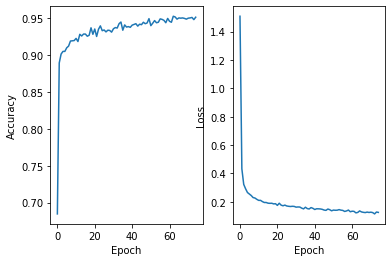

In [236]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3

# Actual NN architecture
# inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
# fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
# bn1 = layers.BatchNormalization()(fc1)
# drp1 = layers.Dropout(dropout_rate)(bn1)
# fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
# bn2 = layers.BatchNormalization()(fc2)
# drp2 = layers.Dropout(dropout_rate)(bn2)
# # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
# # bn3 = layers.BatchNormalization()(fc3)
# # drp3 = layers.Dropout(dropout_rate)(bn3)
# outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)

# Quick test without dropout (to compare with smaller measurement number results)
inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
bn1 = layers.BatchNormalization()(fc1)
#drp1 = layers.Dropout(dropout_rate)(bn1)
fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
bn2 = layers.BatchNormalization()(fc2)
#drp2 = layers.Dropout(dropout_rate)(bn2)
# fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
# bn3 = layers.BatchNormalization()(fc3)
# drp3 = layers.Dropout(dropout_rate)(bn3)
outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
              # Loss function to minimize
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              # List of metrics to monitor
              metrics=['sparse_categorical_accuracy'])

# model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
#               loss='mse',       # mean squared error
#               metrics=['mae'])  # mean absolute error

# model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
#           validation_data=(val_data_all, val_labels_all))
loss_hist = model.fit(train_data_all[0], train_classes_all[0], epochs=75, batch_size=NUM_MEAS)

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(loss_hist.history['sparse_categorical_accuracy'])
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(loss_hist.history['loss'])
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

21 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.5624 - sparse_categorical_accuracy: 0.8940
	Test accuracy: 0.89398736
tf.Tensor(
[[ 2  0  0 ...  0  0  0]
 [ 0 11  0 ...  0  0  0]
 [ 0  0  8 ...  0  0  0]
 ...
 [ 0  0  0 ...  9  0  0]
 [ 0  0  0 ...  0 19  1]
 [ 0  0  0 ...  0  1 45]], shape=(51, 51), dtype=int32)


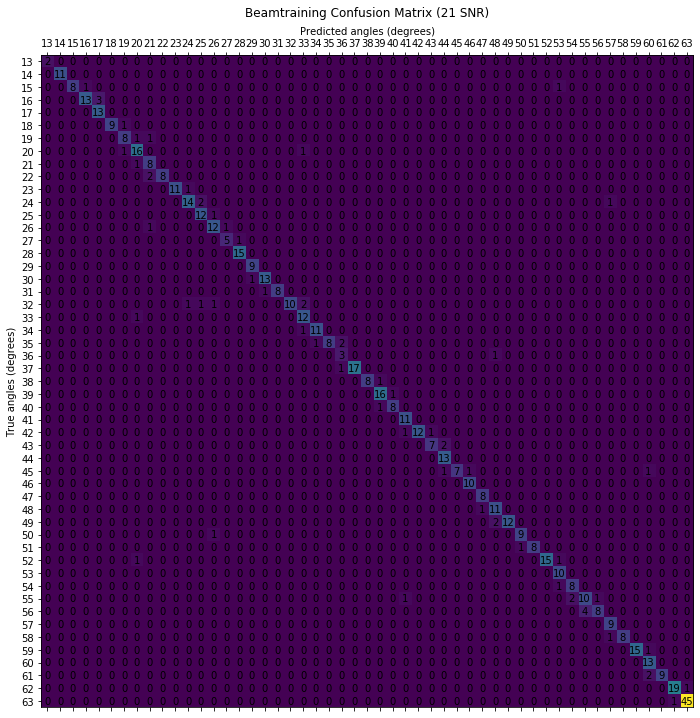

15 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.3509 - sparse_categorical_accuracy: 0.9035
	Test accuracy: 0.903481
tf.Tensor(
[[ 4  0  0 ...  0  0  0]
 [ 2  3  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  8  0  0]
 [ 0  0  0 ...  1 17  1]
 [ 0  0  0 ...  0  1 46]], shape=(51, 51), dtype=int32)


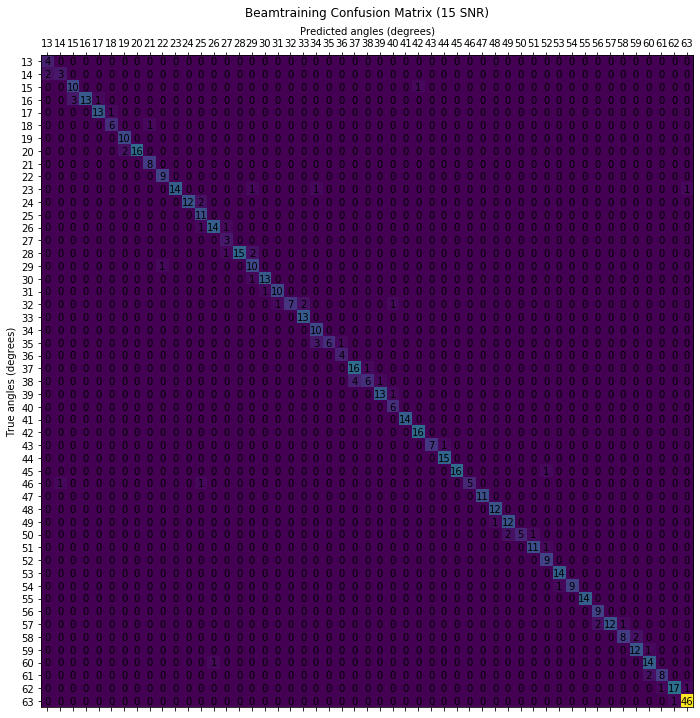

12 dB SNR --
(634, 51)
	labels:      (1, 50)
	predictions: (0, 50)
634/634 - 0s - loss: 0.5529 - sparse_categorical_accuracy: 0.8864
	Test accuracy: 0.88643533
tf.Tensor(
[[ 0  0  0 ...  0  0  0]
 [ 1  3  0 ...  0  0  0]
 [ 0  1  9 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  2  0]
 [ 0  0  0 ...  0 19  2]
 [ 0  0  0 ...  0  0 46]], shape=(51, 51), dtype=int32)


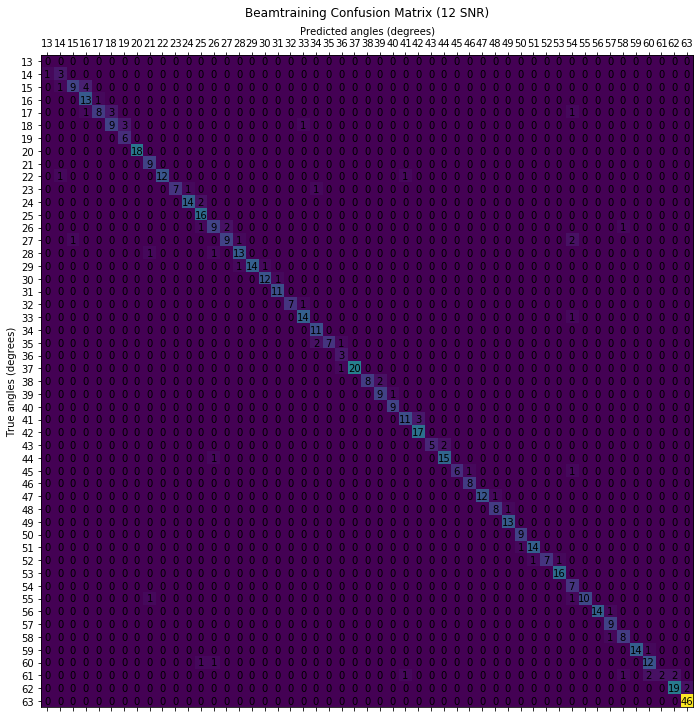

ALL SNR values --
(1898, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1898/1898 - 0s - loss: 0.4888 - sparse_categorical_accuracy: 0.8946


C:\Users\Benjamin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


	Test accuracy: 0.8946259
tf.Tensor(
[[  6   0   0 ...   0   0   0]
 [  3  17   0 ...   0   0   0]
 [  0   1  27 ...   0   0   0]
 ...
 [  0   0   0 ...  19   2   0]
 [  0   0   0 ...   1  55   4]
 [  0   0   0 ...   0   2 137]], shape=(51, 51), dtype=int32)


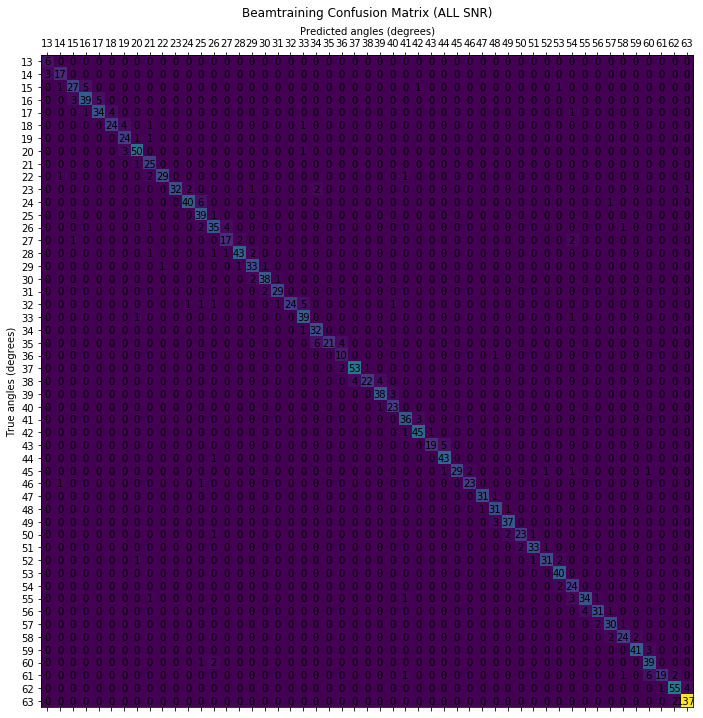


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.      ]
 [100.        34.405385]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.      ]
 [100.        37.858647]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

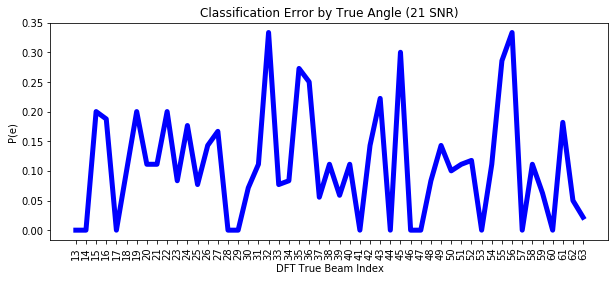

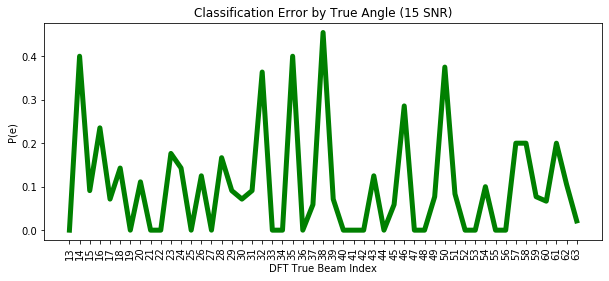

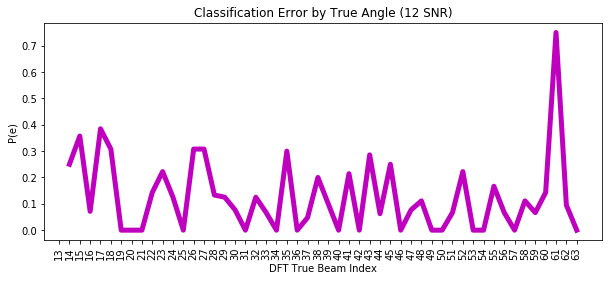

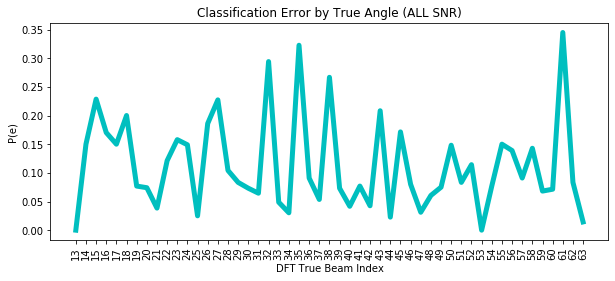

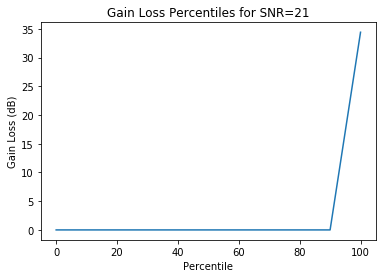

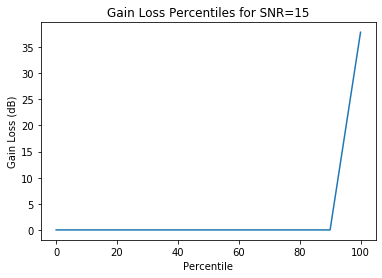

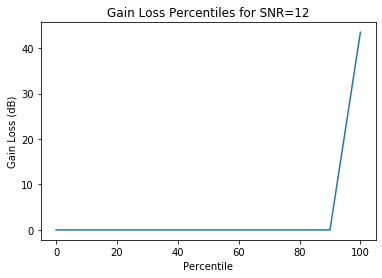

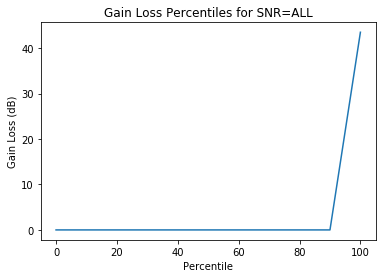

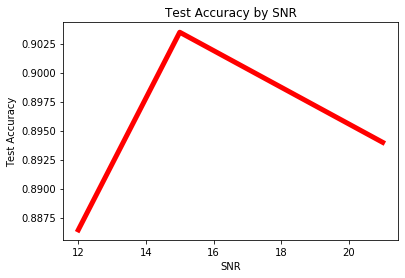

In [186]:
### Test the NN Model ###
#all_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)))
#TODO: FIX THE RECORDING FOR THIS
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array)

pn_i_gainloss = {}

for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
# for snr_ind in np.arange(len(DATA_SNR)):
#     SNR_i = DATA_SNR[snr_ind]
#     print("\n{} dB SNR --".format(SNR_i))
    test_predictions = model.predict(test_data_dict[SNR_i][0])
    print(test_predictions.shape)
    print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][0]), np.max(test_classes_dict[SNR_i][0])))
    print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
    #print(val_labels[item,:])

    test_loss, test_acc = model.evaluate(test_data_dict[SNR_i][0],  test_classes_dict[SNR_i][0], verbose=2)
    print('\tTest accuracy:', test_acc)
    class_test_acc[SNR_i] = test_acc

    # Compute the predicted labels and the confusion matrix
    test_pred_classes = np.argmax(test_predictions, 1)
    test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][0],
                                              test_pred_classes)
    print(test_confusion)
    class_confusionMat[SNR_i] = test_confusion
    CLASSES = dft_use
    
    ## Compute the RMSE of the angles
#     test_pred_angles = np.array([CLASSES[test_pred_classes]]).T
#     #print(test_pred_angles.shape, CLASSES[test_labels_dict[SNR_i].astype(int)].shape)
#     test_disc_err = test_pred_angles - CLASSES[test_classes_dict[SNR_i].astype(int)]
#     test_cont_err = test_pred_angles - test_angles_dict[SNR_i]

#     #mae_class_disc = np.sum(np.abs(test_disc_err))/NUM_TEST # Discrete angle MAE (i.e. average angular error of beams chosen)
#     #mae_class_cont = np.sum(np.abs(test_cont_err))/NUM_TEST # Continous angle MAE (i.e. average angular error given the true continous angle)
#     rmse_class_disc = np.sqrt(np.sum((test_disc_err)**2)/NUM_TEST) # Discrete angle RMSE (i.e. average angular error of beams chosen)
#     rmse_class_cont = np.sqrt(np.sum((test_cont_err)**2)/NUM_TEST) # Continous angle RMSE (i.e. average angular error given the true continous angle)
#     print("RMSE (discrete angles):   {}".format(rmse_class_disc))
#     print("RMSE (continuous angles): {}".format(rmse_class_cont))
    
#     m = tf.keras.metrics.RootMeanSquaredError()
#     m.update_state(test_angles_dict[SNR_i], test_pred_angles)
#     rmse_class_keras = m.result().numpy()
#     print('Keras RMSE: ', rmse_class_keras)

#     # Save the results to a dictionary for later plots
#     class_RMSE_disc[SNR_i] = rmse_class_disc
#     class_RMSE_cont[SNR_i] = rmse_class_keras #rmse_class_cont

    
    ## Plot the confusion matrix (see which beams get associated with each other)
    fig, ax = plt.subplots()
    ax.matshow(test_confusion)
    for (i, j), z in np.ndenumerate(test_confusion):
        ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

    ax.set_xticklabels(CLASSES)
    ax.set_yticklabels(CLASSES)
    ax.xaxis.set_label_position("top")
    fig.set_size_inches(12, 12)
    plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
    plt.xlabel("Predicted angles (degrees)")
    plt.ylabel("True angles (degrees)")
    plt.xticks(np.arange(NUM_CLASSES))
    plt.yticks(np.arange(NUM_CLASSES))
    plt.savefig('../figures/confusionMatrix_real_{}SNR.png'.format(SNR_i))
    plt.show()
    
    ## Plot the P(e) given a specific angle
    num_true_angles = np.sum(test_confusion,1)
    num_correct = np.diag(test_confusion)
    num_incorrect = num_true_angles - num_correct
    pe = num_incorrect/num_true_angles
    
#     fig = plt.figure()
#     fig.set_size_inches(10, 4)
#     plt.plot(pe)
#     plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
#     plt.xlabel("DFT True Beam Index")
#     plt.ylabel("P(e)")
#     plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

    ## Compute the gain loss for each test beam
    label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
    max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
    selected_dft_ind = dft_use[test_pred_classes]
    achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
    pn_i_gainloss[SNR_i] = max_gain - achieved_gain

    ## Store the results for a final overall plot
    #all_acc[0, snr_ind] = test_acc
    all_curMeas_acc[0, snr_ind] = test_acc
    all_curMeas_test_confusion[0, snr_ind, :, :] = test_confusion
    all_curMeas_pe[0, snr_ind, :] = pe
    
## Store the gain loss dictionary for this PN beam combo
all_curMeas_gainloss[pn_i] = pn_i_gainloss
    
# print("Number of results: {}".format(len(class_test_acc)))
# fig = plt.figure()
# fig.set_size_inches(6, 4)
# plt.plot(DATA_SNR, all_curMeas_acc.T)
# plt.title("Test Accuracy by SNR")
# plt.xlabel("SNR")
# plt.ylabel("Test Accuracy")

## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance 
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe

[ 0  2 12  9 16 13  5 14 18  8 12 14 15 13 14  4 23  9 14 10 11 15 10 14
  3 44 24 32  1 16 14  9 13 16 11  9 13 12  8 12  8 15 10 12 12 14 10 52
 40 36 58 90]
[ 0  2 12  8  7 10  5 11 14  8 11 12 11  5 14  3 20  8 12 10  8 14 10 13
  2 13 15 14  1 13 12  4 11 16  9  8 10 11  7 10  7 13  9  9 12 11  4 43
 19 36 49 62]
[ 0  0  0  1  9  3  0  3  4  0  1  2  4  8  0  1  3  1  2  0  3  1  0  1
  1 31  9 18  0  3  2  5  2  0  2  1  3  1  1  2  1  2  1  3  0  3  6  9
 21  0  9 28]
[       nan 0.         0.         0.11111111 0.5625     0.23076923
 0.         0.21428571 0.22222222 0.         0.08333333 0.14285714
 0.26666667 0.61538462 0.         0.25       0.13043478 0.11111111
 0.14285714 0.         0.27272727 0.06666667 0.         0.07142857
 0.33333333 0.70454545 0.375      0.5625     0.         0.1875
 0.14285714 0.55555556 0.15384615 0.         0.18181818 0.11111111
 0.23076923 0.08333333 0.125      0.16666667 0.125      0.13333333
 0.1        0.25       0.         0.21428571 0.6       

C:\Users\Benjamin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


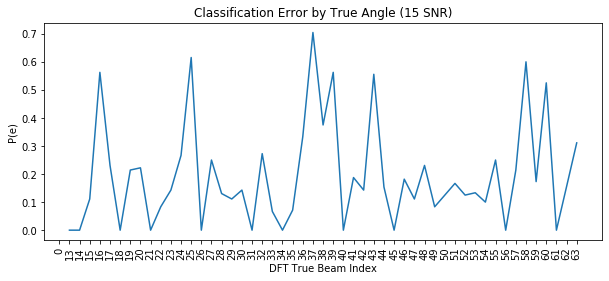

In [194]:
num_true_angles = np.sum(test_confusion,1)
print(num_true_angles)
num_correct = np.diag(test_confusion)
print(num_correct)
num_incorrect = num_true_angles - num_correct
print(num_incorrect)
pe = num_incorrect/num_true_angles
print(pe)
fig = plt.figure()
fig.set_size_inches(10, 4)
plt.plot(pe)
plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
plt.xlabel("DFT True Beam Index")
plt.ylabel("P(e)")
plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);


### NN for 20 Measurements


Training model for PN combo 0...
Train on 3060 samples
Epoch 1/75
3060/3060 [==============================] - 1s 467us/sample - loss: 1.4903 - sparse_categorical_accuracy: 0.6879
Epoch 2/75
3060/3060 [==============================] - 0s 116us/sample - loss: 0.4503 - sparse_categorical_accuracy: 0.8817
Epoch 3/75
3060/3060 [==============================] - 0s 120us/sample - loss: 0.3674 - sparse_categorical_accuracy: 0.8866
Epoch 4/75
3060/3060 [==============================] - 0s 117us/sample - loss: 0.3122 - sparse_categorical_accuracy: 0.9062
Epoch 5/75
3060/3060 [==============================] - 0s 118us/sample - loss: 0.2948 - sparse_categorical_accuracy: 0.8997
Epoch 6/75
3060/3060 [==============================] - 0s 115us/sample - loss: 0.2933 - sparse_categorical_accuracy: 0.8967
Epoch 7/75
3060/3060 [==============================] - 0s 116us/sample - loss: 0.2692 - sparse_categorical_accuracy: 0.9124
Epoch 8/75
3060/3060 [==============================] - 0s 116us/samp

Text(0.5, 0, 'Epoch')

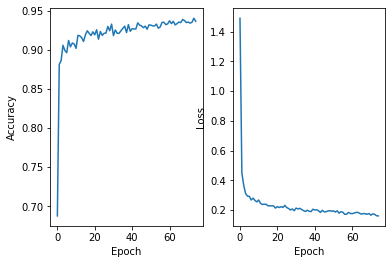

In [232]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.4400 - sparse_categorical_accuracy: 0.9019
	Test accuracy: 0.90189874


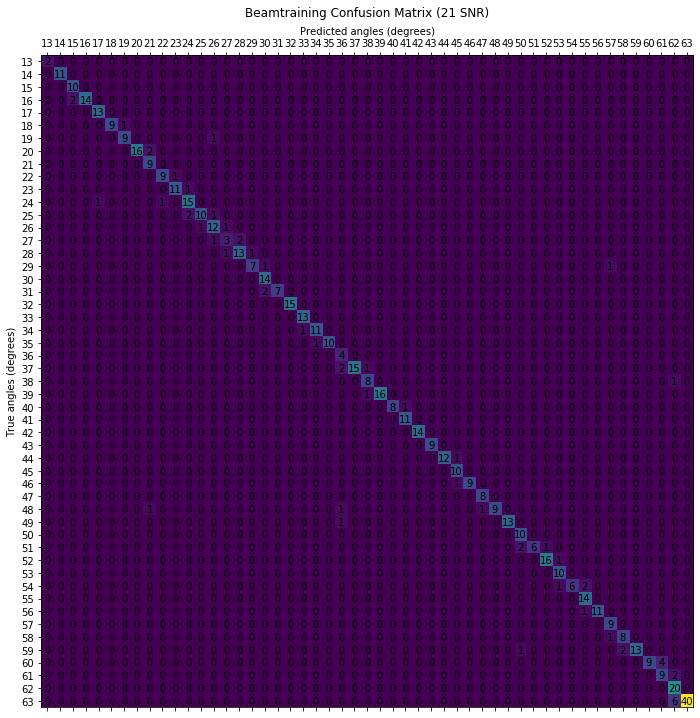

15 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.3503 - sparse_categorical_accuracy: 0.9256
	Test accuracy: 0.9256329


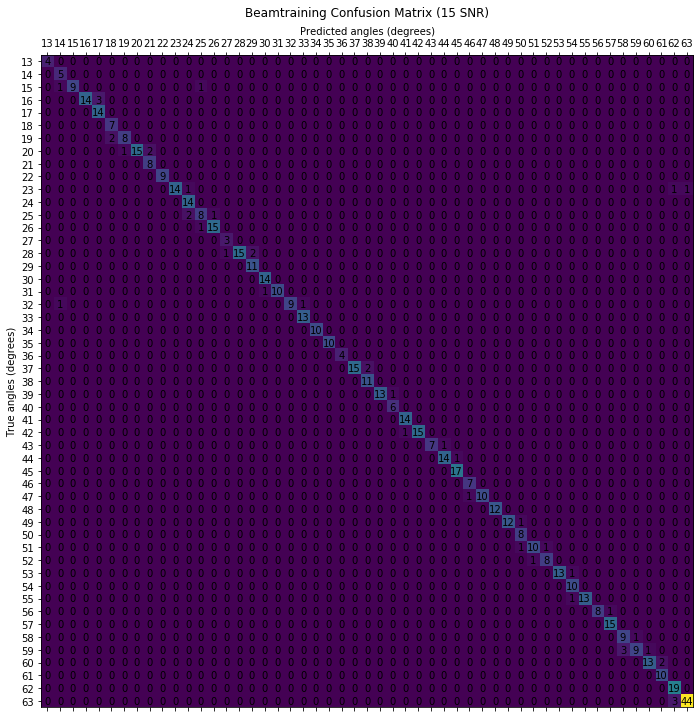

12 dB SNR --
(634, 51)
	labels:      (1, 50)
	predictions: (1, 50)
634/634 - 0s - loss: 0.5263 - sparse_categorical_accuracy: 0.8849
	Test accuracy: 0.8848581


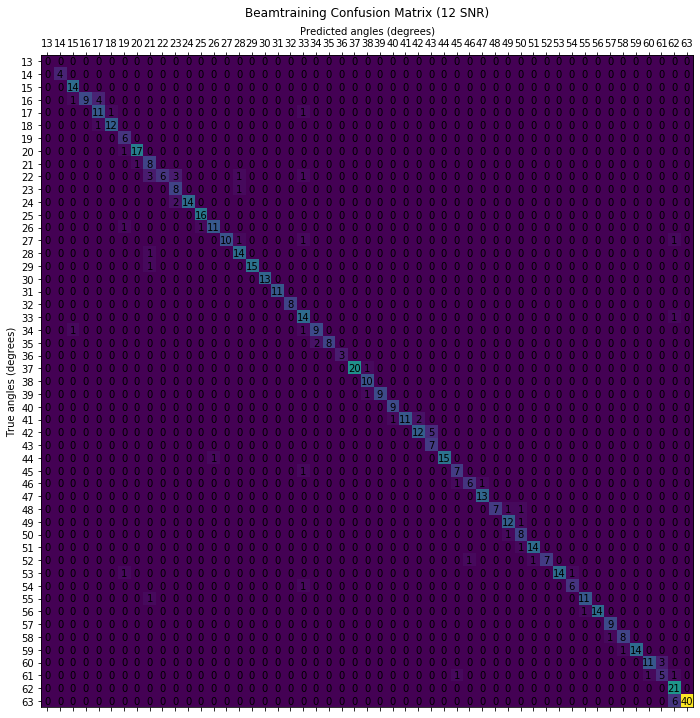

ALL SNR values --
(1898, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1898/1898 - 0s - loss: 0.4389 - sparse_categorical_accuracy: 0.9041


C:\Users\Benjamin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


	Test accuracy: 0.9041096


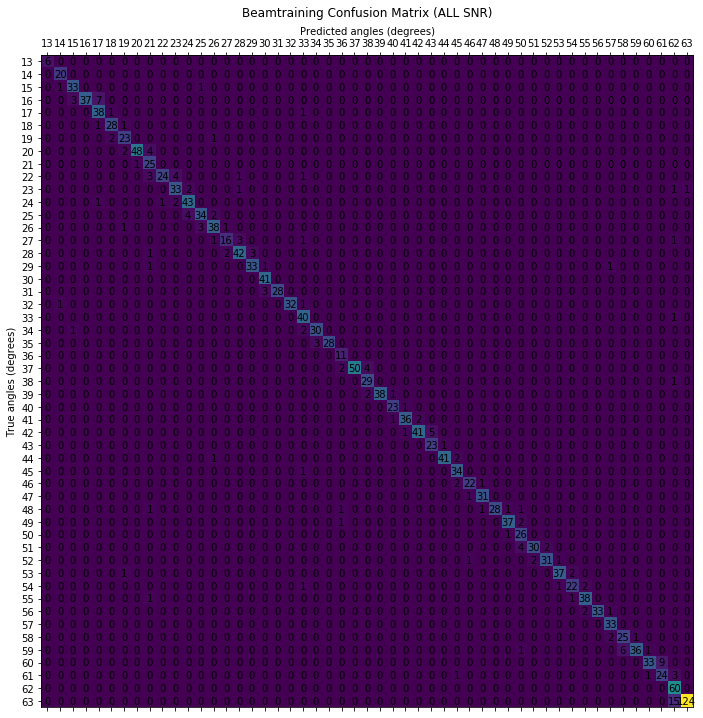


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.      ]
 [100.        35.707345]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.      ]
 [100.        24.548573]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

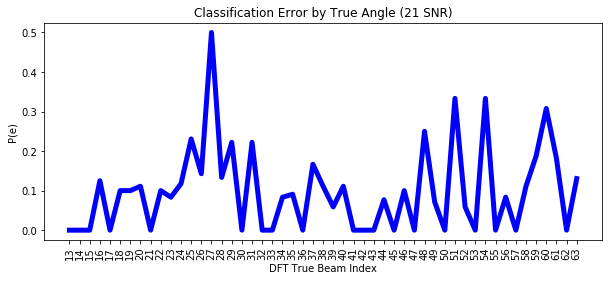

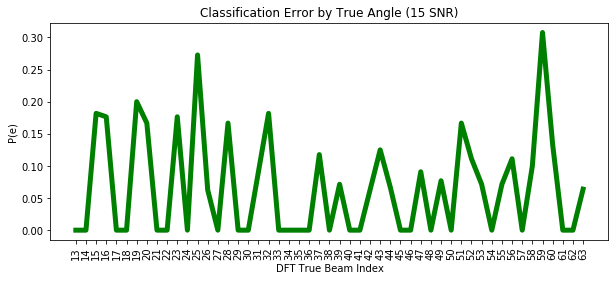

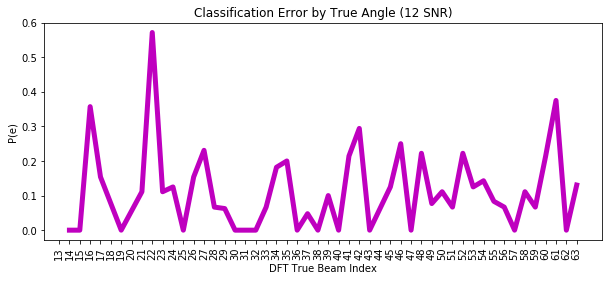

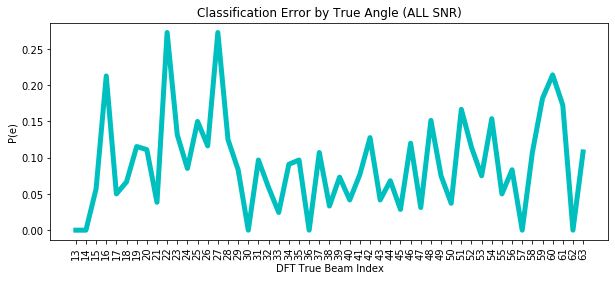

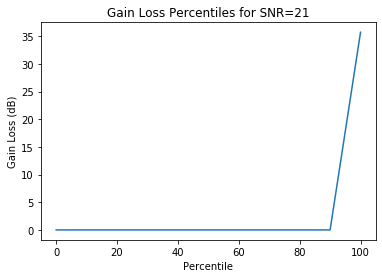

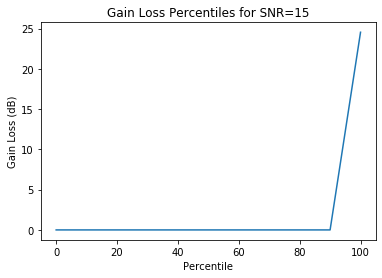

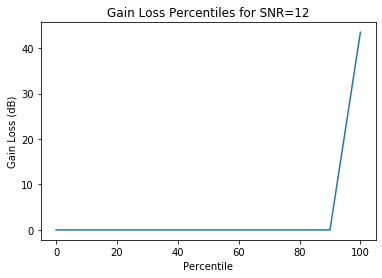

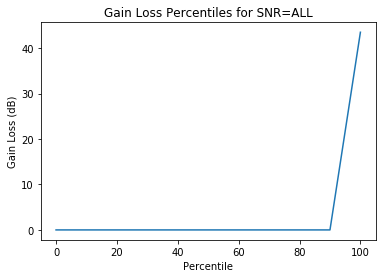

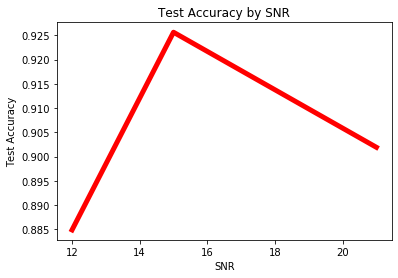

In [233]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_real_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe

### NN for 16 Measurements


Training model for PN combo 0...
Train on 3060 samples
Epoch 1/75
3060/3060 [==============================] - 1s 413us/sample - loss: 1.4212 - sparse_categorical_accuracy: 0.6882
Epoch 2/75
3060/3060 [==============================] - 1s 193us/sample - loss: 0.4705 - sparse_categorical_accuracy: 0.8739
Epoch 3/75
3060/3060 [==============================] - 1s 194us/sample - loss: 0.3770 - sparse_categorical_accuracy: 0.8856
Epoch 4/75
3060/3060 [==============================] - 1s 193us/sample - loss: 0.3361 - sparse_categorical_accuracy: 0.8925
Epoch 5/75
3060/3060 [==============================] - 1s 192us/sample - loss: 0.3265 - sparse_categorical_accuracy: 0.8925
Epoch 6/75
3060/3060 [==============================] - 1s 187us/sample - loss: 0.3108 - sparse_categorical_accuracy: 0.8984
Epoch 7/75
3060/3060 [==============================] - 1s 190us/sample - loss: 0.2941 - sparse_categorical_accuracy: 0.9013
Epoch 8/75
3060/3060 [==============================] - 1s 192us/samp

Text(0.5, 0, 'Epoch')

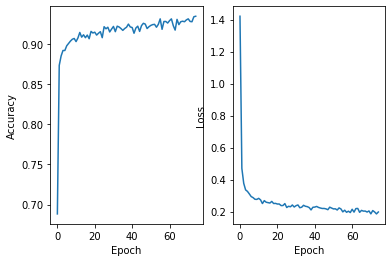

In [228]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.4592 - sparse_categorical_accuracy: 0.8972
	Test accuracy: 0.8971519


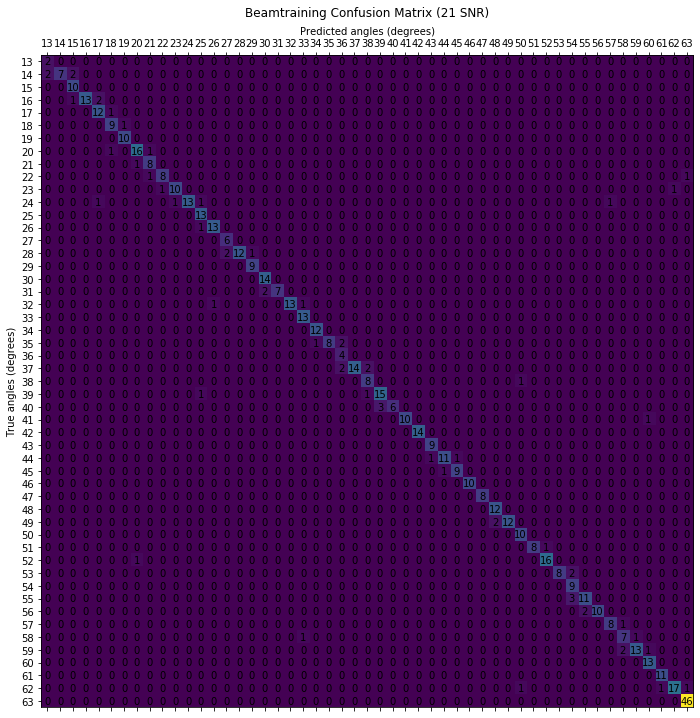

15 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.2888 - sparse_categorical_accuracy: 0.9193
	Test accuracy: 0.9193038


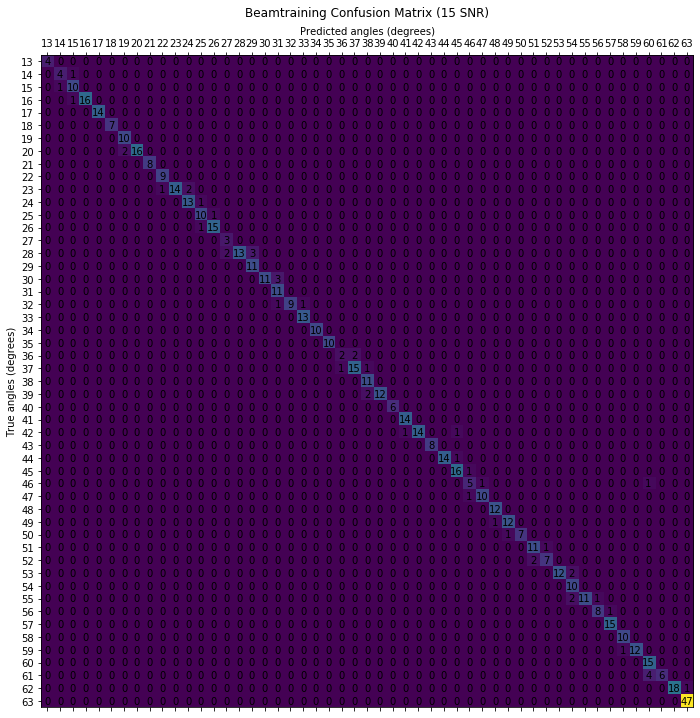

12 dB SNR --
(634, 51)
	labels:      (1, 50)
	predictions: (1, 50)
634/634 - 0s - loss: 0.3976 - sparse_categorical_accuracy: 0.8849
	Test accuracy: 0.8848581


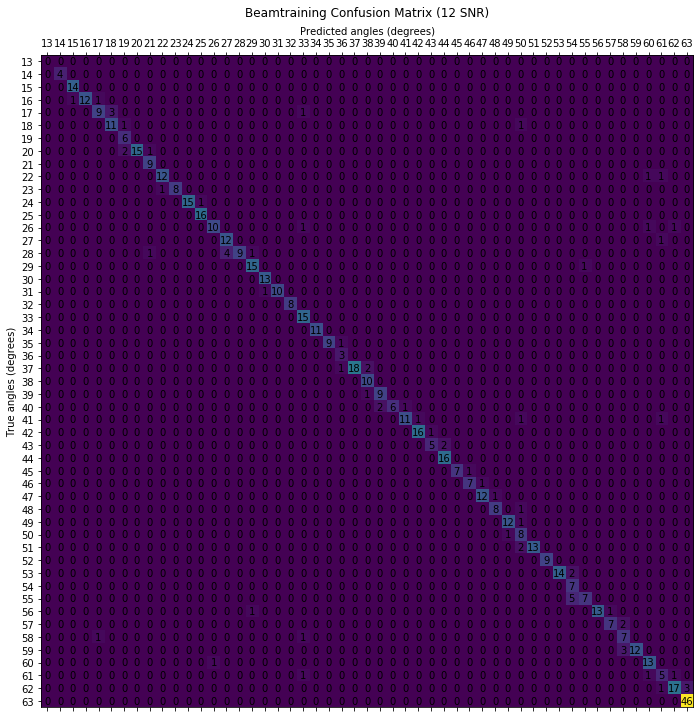

ALL SNR values --
(1898, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1898/1898 - 0s - loss: 0.3819 - sparse_categorical_accuracy: 0.9004


C:\Users\Benjamin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


	Test accuracy: 0.9004215


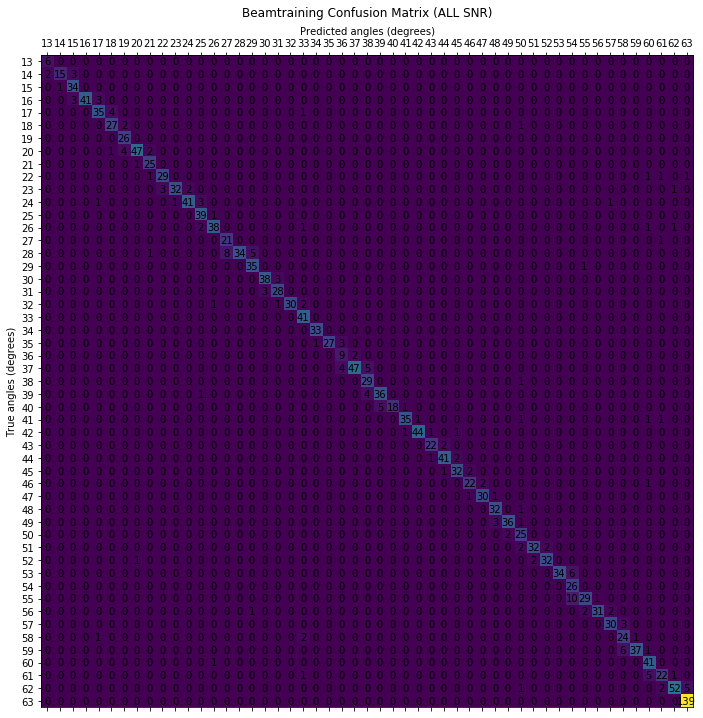


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.      ]
 [100.        26.470078]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.      ]
 [100.        24.711005]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

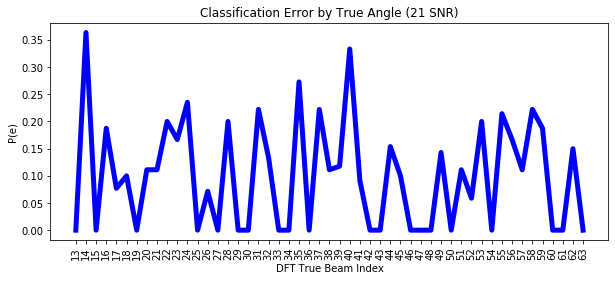

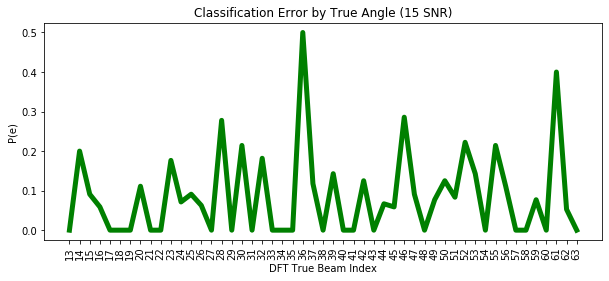

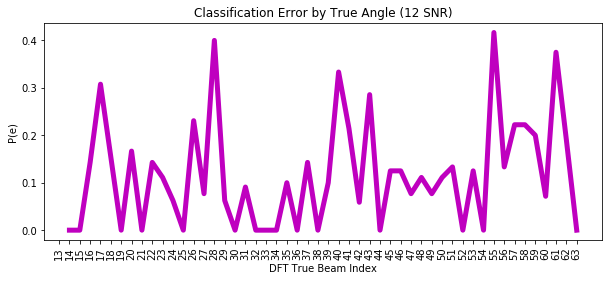

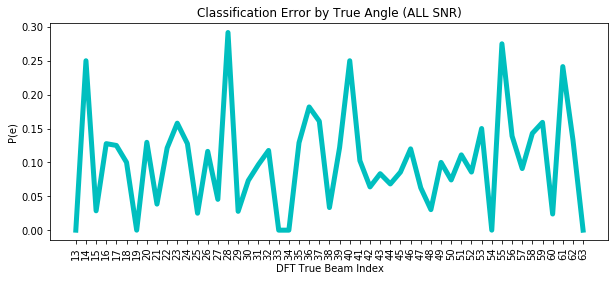

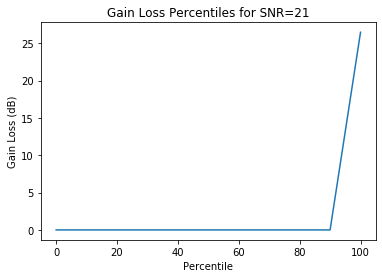

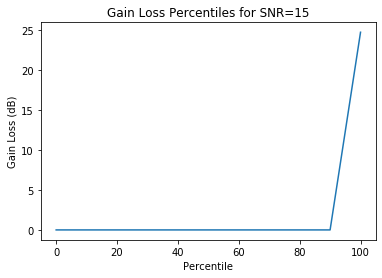

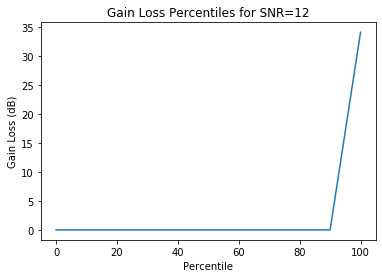

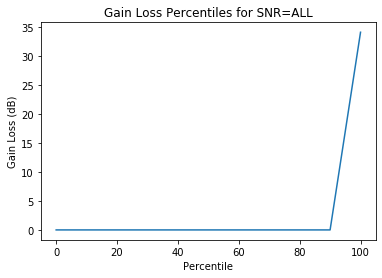

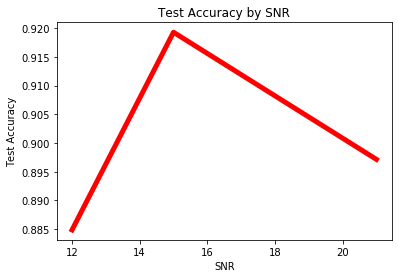

In [229]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_real_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe

### NN for 15 Measurements


Training model for PN combo 0...
Train on 3060 samples
Epoch 1/75
3060/3060 [==============================] - 1s 384us/sample - loss: 1.5710 - sparse_categorical_accuracy: 0.6441
Epoch 2/75
3060/3060 [==============================] - 0s 160us/sample - loss: 0.5357 - sparse_categorical_accuracy: 0.8621
Epoch 3/75
3060/3060 [==============================] - 0s 158us/sample - loss: 0.4191 - sparse_categorical_accuracy: 0.8768
Epoch 4/75
3060/3060 [==============================] - 0s 155us/sample - loss: 0.3698 - sparse_categorical_accuracy: 0.8850
Epoch 5/75
3060/3060 [==============================] - 0s 156us/sample - loss: 0.3491 - sparse_categorical_accuracy: 0.8954
Epoch 6/75
3060/3060 [==============================] - 0s 156us/sample - loss: 0.3395 - sparse_categorical_accuracy: 0.8971
Epoch 7/75
3060/3060 [==============================] - 0s 153us/sample - loss: 0.3249 - sparse_categorical_accuracy: 0.9029
Epoch 8/75
3060/3060 [==============================] - 0s 156us/samp

Text(0.5, 0, 'Epoch')

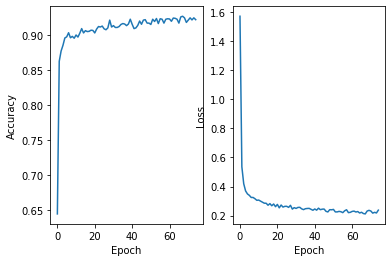

In [192]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.5454 - sparse_categorical_accuracy: 0.8782
	Test accuracy: 0.8781645


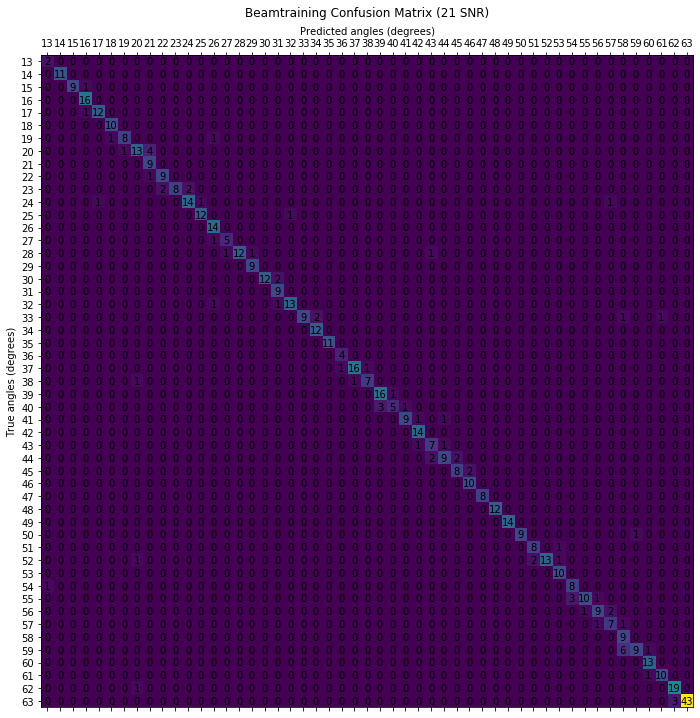

15 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.3112 - sparse_categorical_accuracy: 0.9019
	Test accuracy: 0.90189874


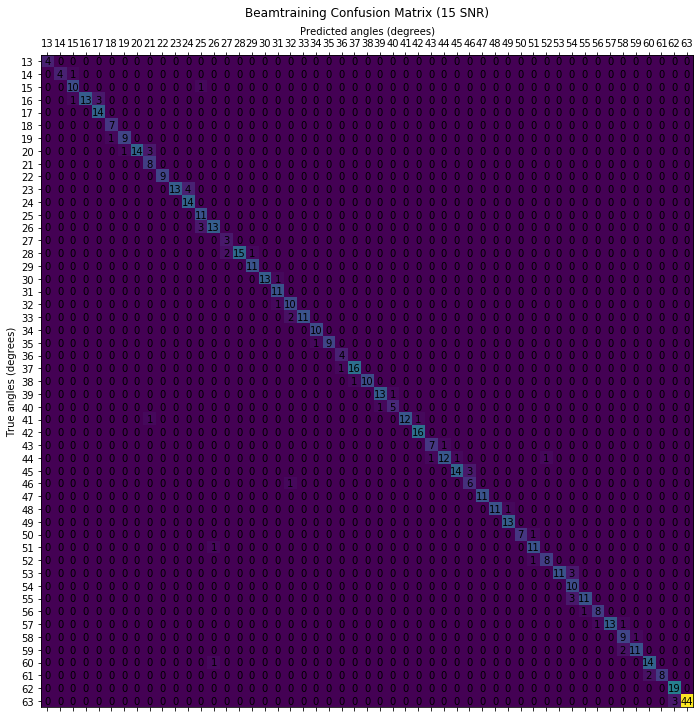

12 dB SNR --
(634, 51)
	labels:      (1, 50)
	predictions: (0, 50)
634/634 - 0s - loss: 0.4313 - sparse_categorical_accuracy: 0.8912
	Test accuracy: 0.89116716


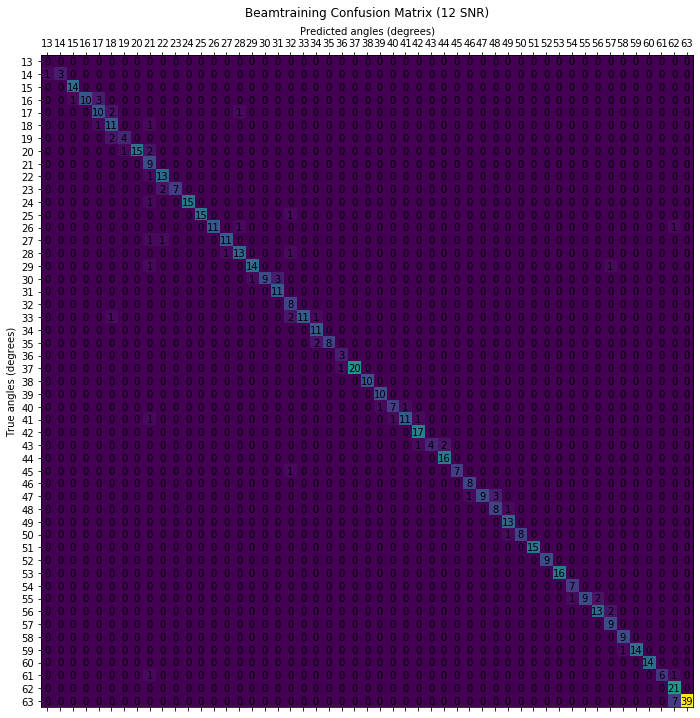

C:\Users\Benjamin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


ALL SNR values --
(1898, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1898/1898 - 0s - loss: 0.4293 - sparse_categorical_accuracy: 0.8904
	Test accuracy: 0.89041096


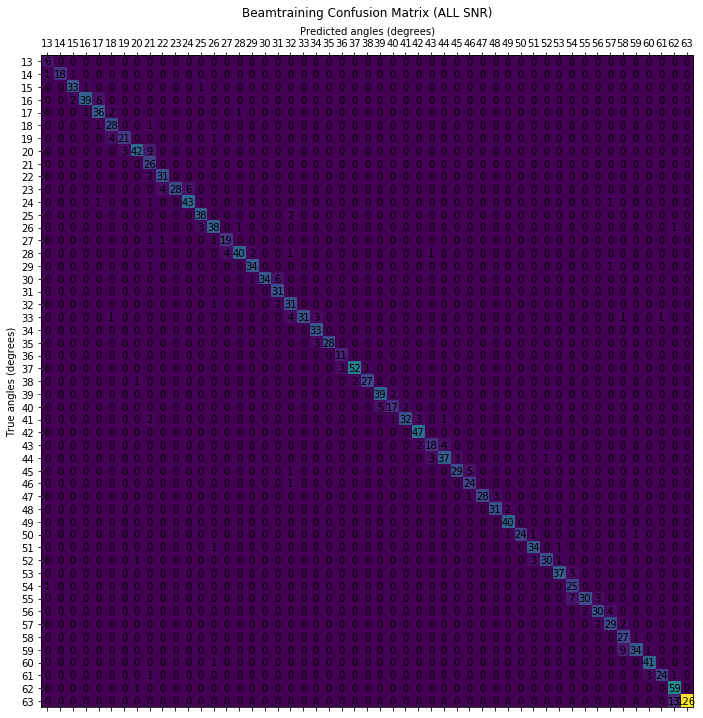


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.205637]
 [100.        26.879931]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.      ]
 [100.        24.711005]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

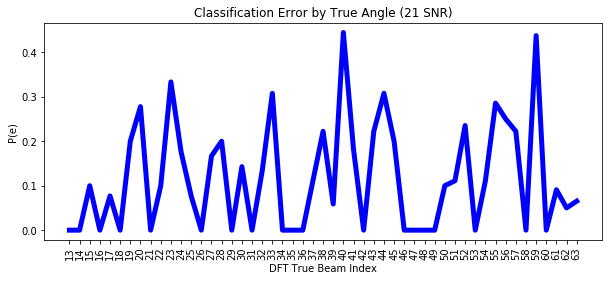

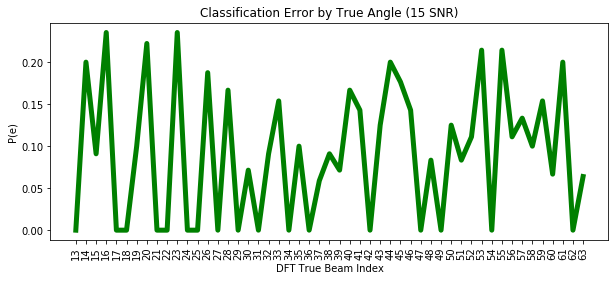

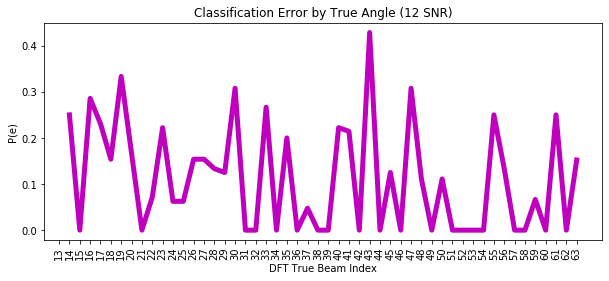

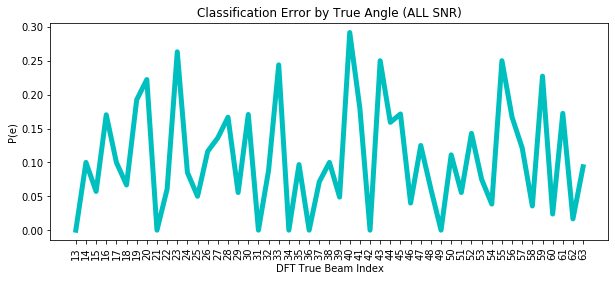

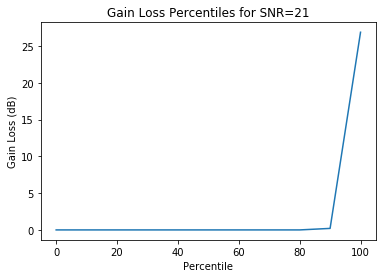

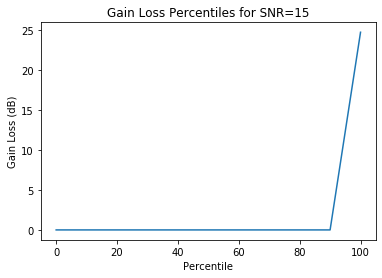

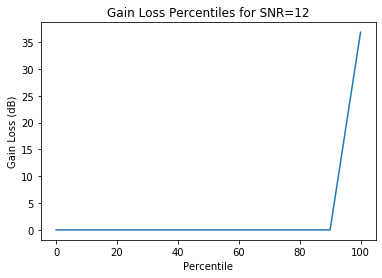

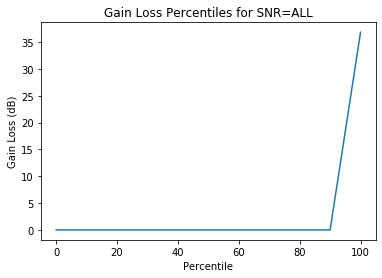

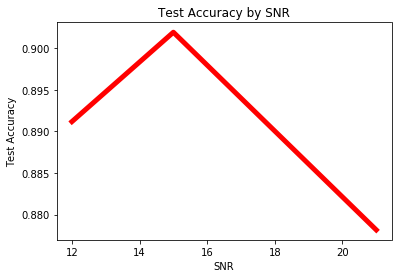

In [193]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_real_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe

In [23]:
print(all_acc.shape) # PN, SNR
print(all_test_confusion.shape) # PN, SNR, True angle, Predicted angle

print("\n")
print(np.mean(all_acc, 0))
print(DATA_SNR)

print("\n")
print(np.mean(all_test_confusion, 0).shape)

print("\n")
print(all_pe.shape)
print(all_pe[:,0,:].T.shape)
print(np.mean(all_pe, 0).shape)

(10, 2)
(10, 2, 51, 51)


[0.91075949 0.89542586]
[15, 12]


(2, 51, 51)


(10, 2, 51)
(51, 10)
(2, 51)


### NN for 12 Measurements


Training model for PN combo 0...
Train on 3060 samples
Epoch 1/75
3060/3060 [==============================] - 1s 400us/sample - loss: 1.5179 - sparse_categorical_accuracy: 0.6621
Epoch 2/75
3060/3060 [==============================] - 1s 186us/sample - loss: 0.5988 - sparse_categorical_accuracy: 0.8454
Epoch 3/75
3060/3060 [==============================] - 1s 191us/sample - loss: 0.4637 - sparse_categorical_accuracy: 0.8771
Epoch 4/75
3060/3060 [==============================] - 1s 187us/sample - loss: 0.4228 - sparse_categorical_accuracy: 0.8739
Epoch 5/75
3060/3060 [==============================] - 1s 188us/sample - loss: 0.3830 - sparse_categorical_accuracy: 0.8850
Epoch 6/75
3060/3060 [==============================] - 1s 186us/sample - loss: 0.3917 - sparse_categorical_accuracy: 0.8830
Epoch 7/75
3060/3060 [==============================] - 1s 188us/sample - loss: 0.3757 - sparse_categorical_accuracy: 0.8817
Epoch 8/75
3060/3060 [==============================] - 1s 188us/samp

Text(0.5, 0, 'Epoch')

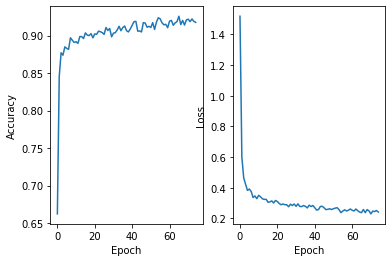

In [224]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)

    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.3730 - sparse_categorical_accuracy: 0.9066
	Test accuracy: 0.9066456


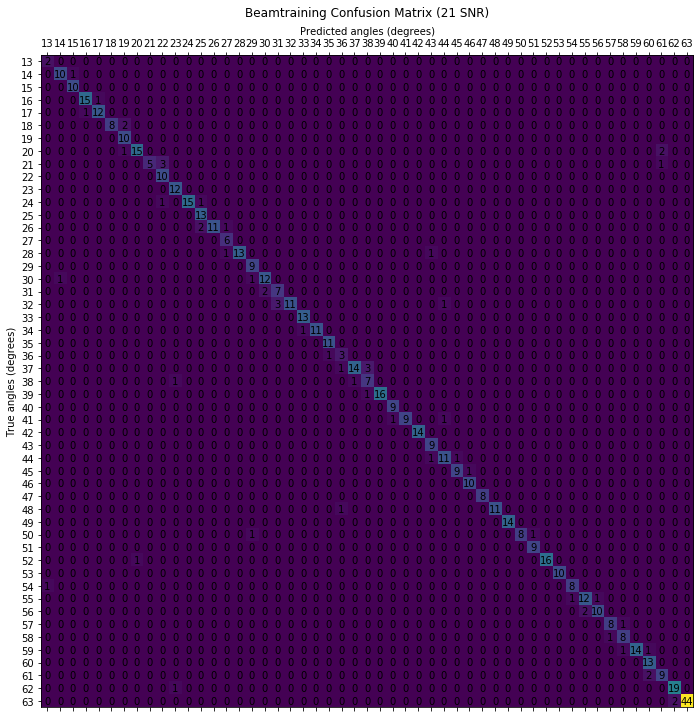

15 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.2667 - sparse_categorical_accuracy: 0.9209
	Test accuracy: 0.9208861


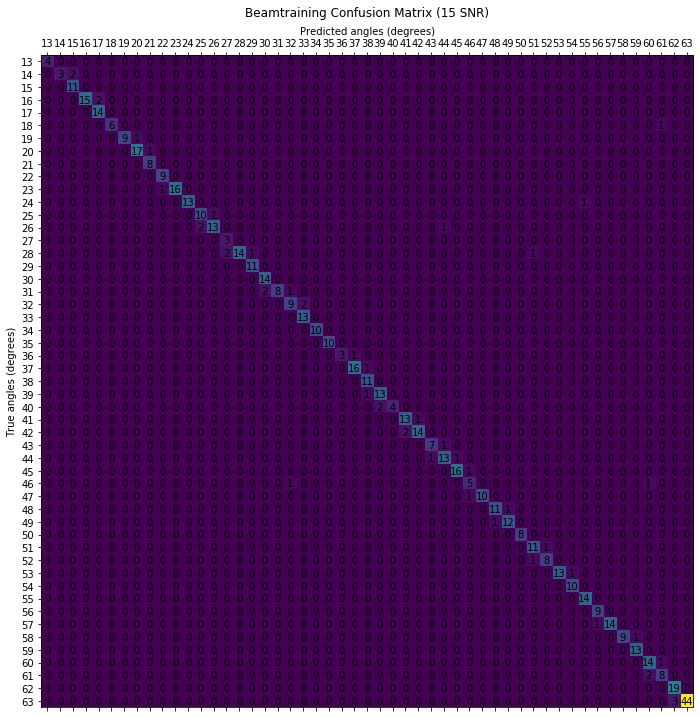

12 dB SNR --
(634, 51)
	labels:      (1, 50)
	predictions: (0, 50)
634/634 - 0s - loss: 0.5016 - sparse_categorical_accuracy: 0.9006
	Test accuracy: 0.9006309


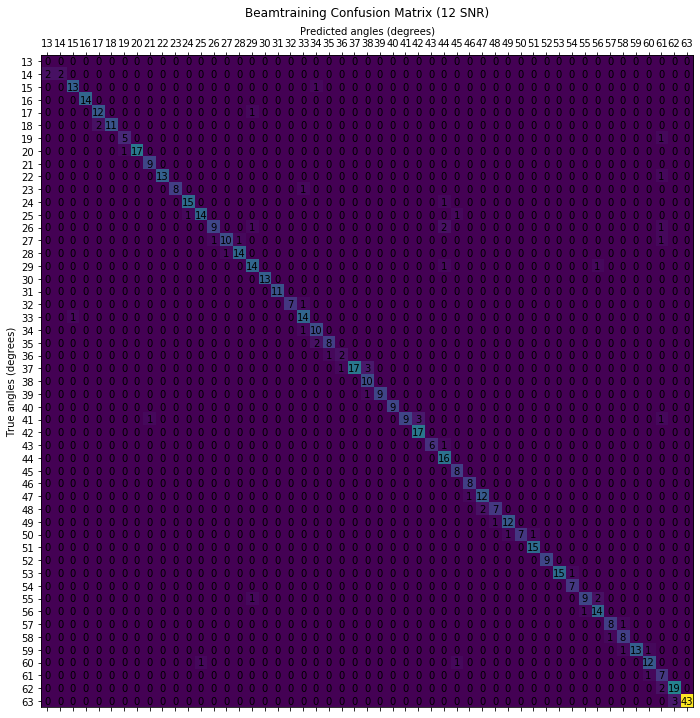

ALL SNR values --
(1898, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1898/1898 - 0s - loss: 0.3805 - sparse_categorical_accuracy: 0.9094


C:\Users\Benjamin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


	Test accuracy: 0.9093783


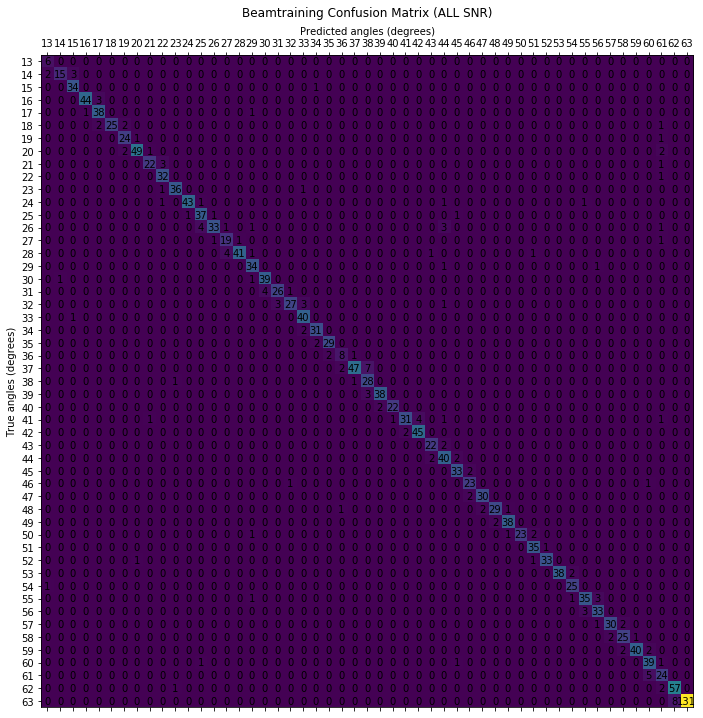


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.        0.     ]
 [ 10.        0.     ]
 [ 20.        0.     ]
 [ 30.        0.     ]
 [ 40.        0.     ]
 [ 50.        0.     ]
 [ 60.        0.     ]
 [ 70.        0.     ]
 [ 80.        0.     ]
 [ 90.        0.     ]
 [100.       34.92591]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.      ]
 [100.        38.610368]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.  

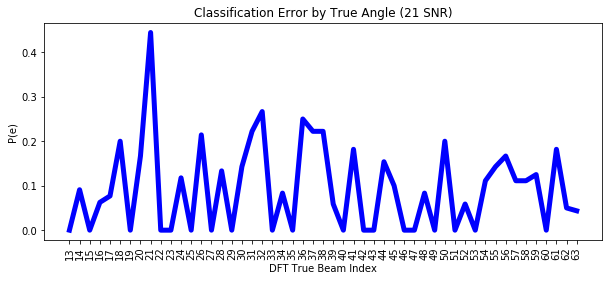

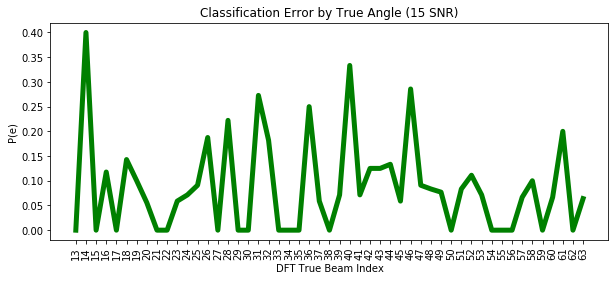

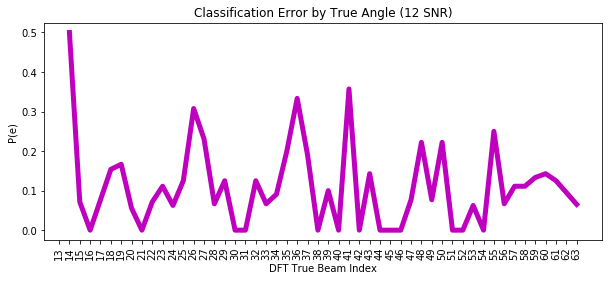

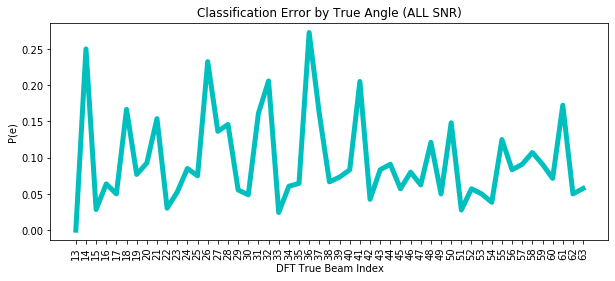

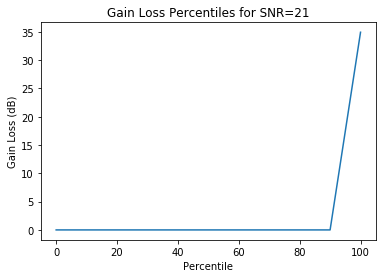

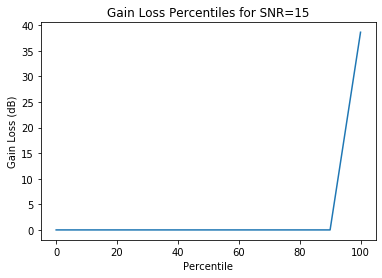

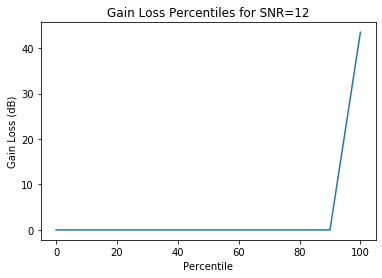

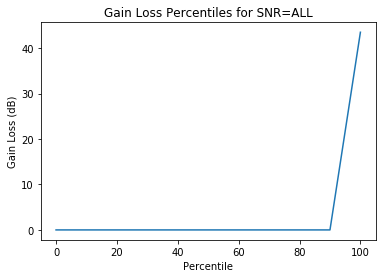

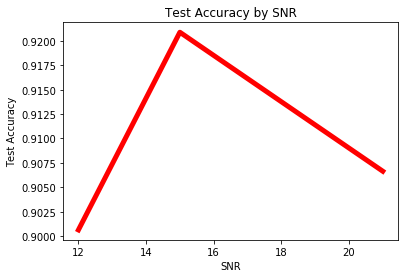

In [225]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array)

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {}
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_real_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam 
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe
        
    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss

## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe

### NN for 10 Measurements


Training model for PN combo 0...
Train on 3060 samples
Epoch 1/75
3060/3060 [==============================] - 1s 439us/sample - loss: 1.7728 - sparse_categorical_accuracy: 0.5827
Epoch 2/75
3060/3060 [==============================] - 1s 227us/sample - loss: 0.6990 - sparse_categorical_accuracy: 0.8239
Epoch 3/75
3060/3060 [==============================] - 1s 229us/sample - loss: 0.5666 - sparse_categorical_accuracy: 0.8382
Epoch 4/75
3060/3060 [==============================] - 1s 229us/sample - loss: 0.4675 - sparse_categorical_accuracy: 0.8709
Epoch 5/75
3060/3060 [==============================] - 1s 226us/sample - loss: 0.4617 - sparse_categorical_accuracy: 0.8650
Epoch 6/75
3060/3060 [==============================] - 1s 226us/sample - loss: 0.4410 - sparse_categorical_accuracy: 0.8696
Epoch 7/75
3060/3060 [==============================] - 1s 224us/sample - loss: 0.4180 - sparse_categorical_accuracy: 0.8732
Epoch 8/75
3060/3060 [==============================] - 1s 226us/samp

Text(0.5, 0, 'Epoch')

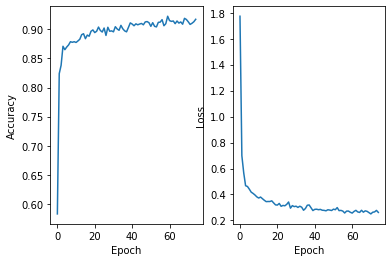

In [196]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)

    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.3837 - sparse_categorical_accuracy: 0.8972
	Test accuracy: 0.8971519


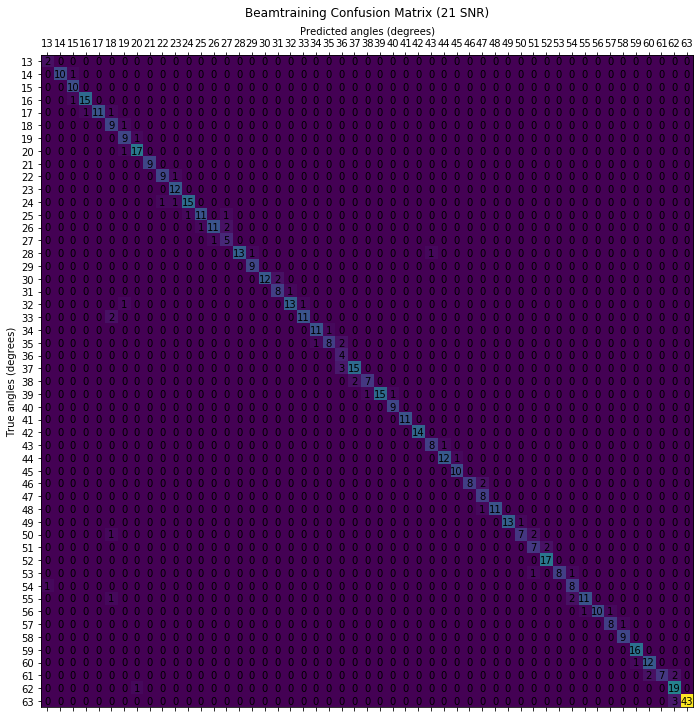

15 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.4097 - sparse_categorical_accuracy: 0.9177
	Test accuracy: 0.9177215


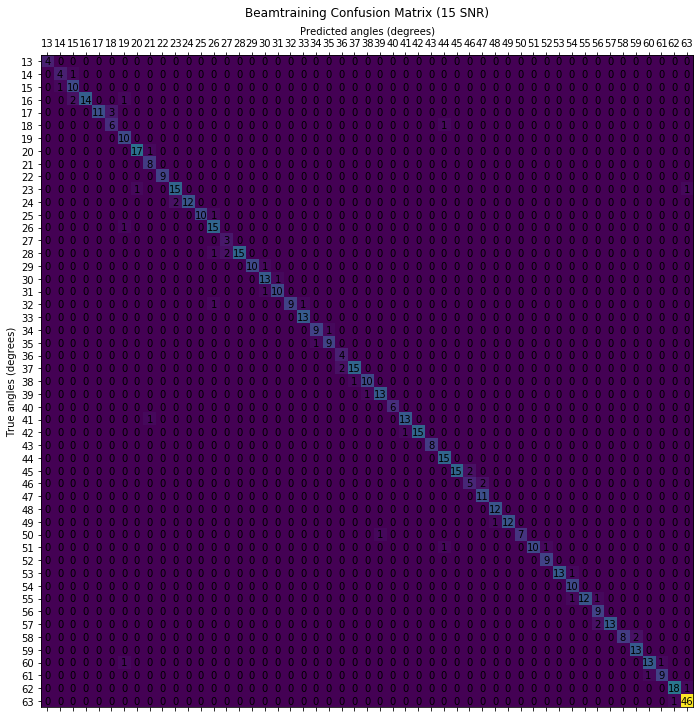

12 dB SNR --
(634, 51)
	labels:      (1, 50)
	predictions: (0, 50)
634/634 - 0s - loss: 0.4404 - sparse_categorical_accuracy: 0.8785
	Test accuracy: 0.8785489


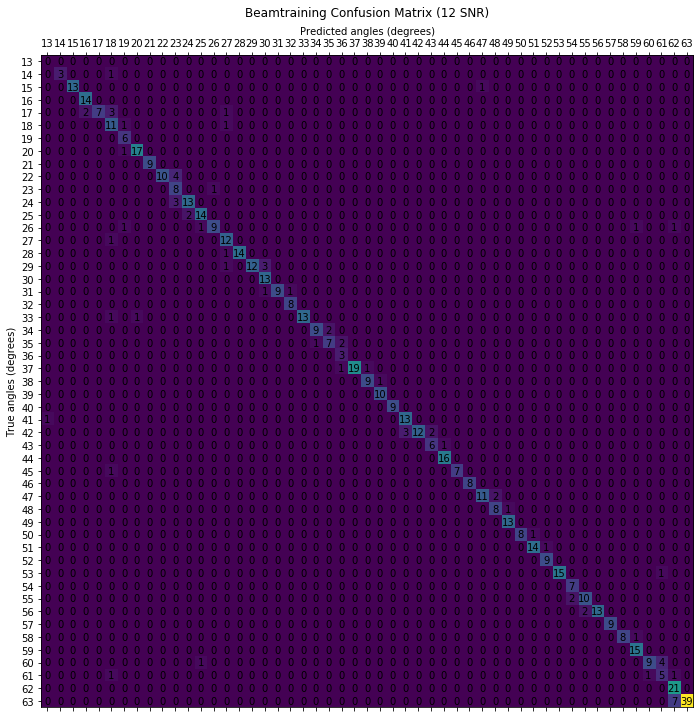

ALL SNR values --
(1898, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1898/1898 - 0s - loss: 0.4113 - sparse_categorical_accuracy: 0.8978


C:\Users\Benjamin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


	Test accuracy: 0.89778715


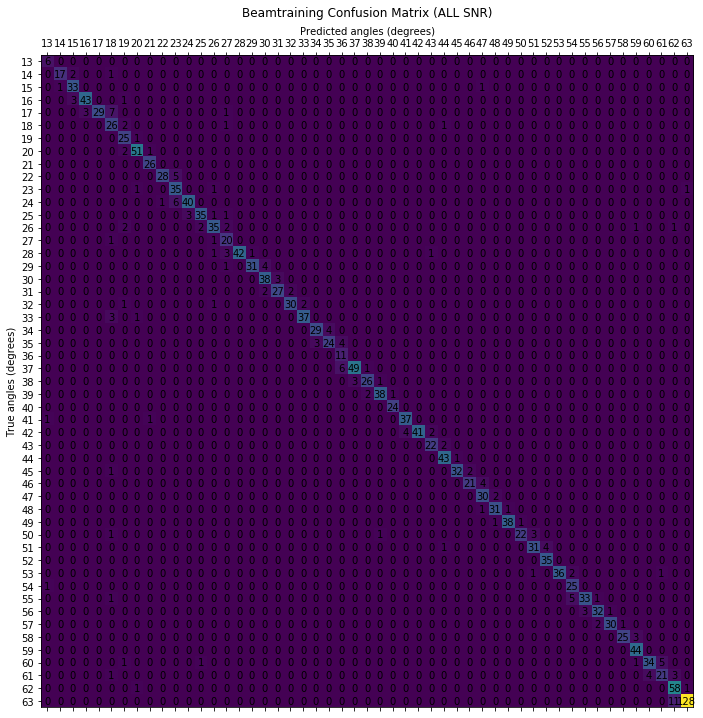


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.      ]
 [100.        26.879931]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.        0.     ]
 [ 10.        0.     ]
 [ 20.        0.     ]
 [ 30.        0.     ]
 [ 40.        0.     ]
 [ 50.        0.     ]
 [ 60.        0.     ]
 [ 70.        0.     ]
 [ 80.        0.     ]
 [ 90.        0.     ]
 [100.       38.48881]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.  

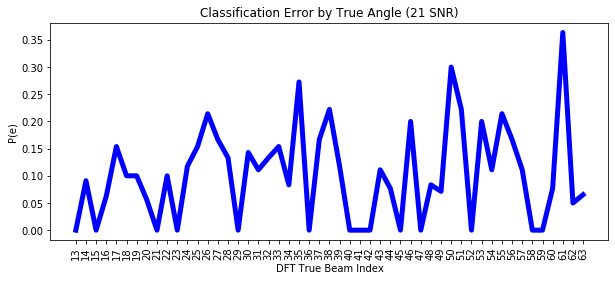

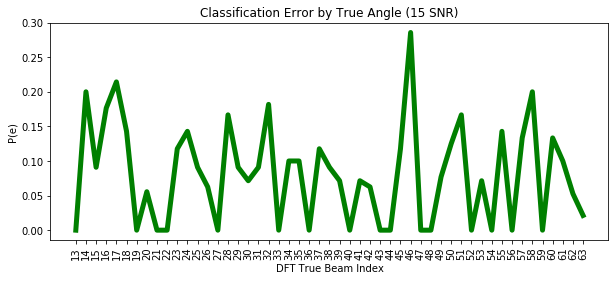

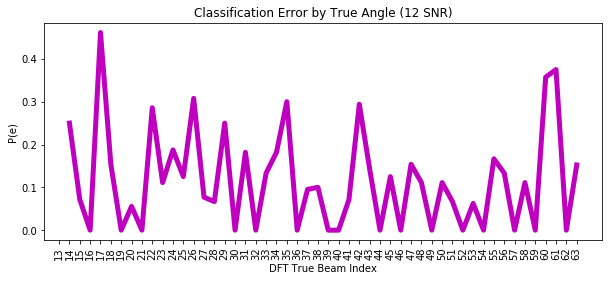

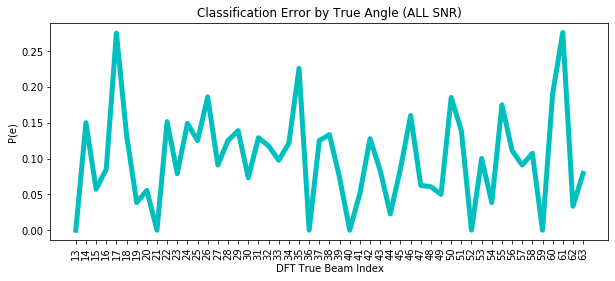

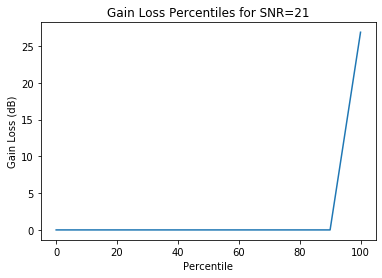

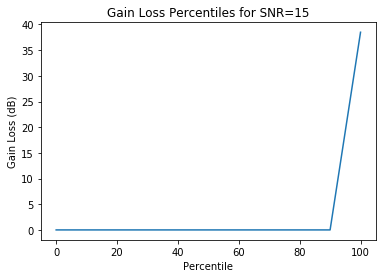

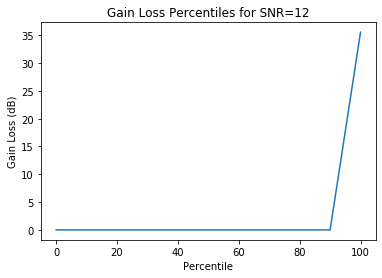

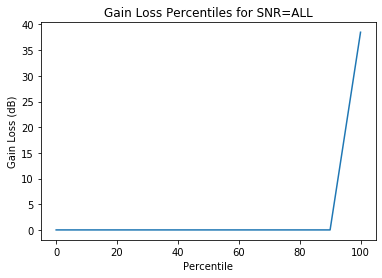

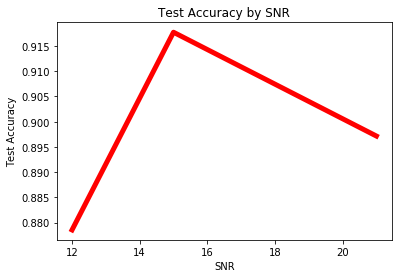

In [197]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array)

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {}
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_real_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam 
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe
        
    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss

## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe

### NN for 9 Measurements


Training model for PN combo 0...
Train on 3060 samples
Epoch 1/75
3060/3060 [==============================] - 1s 468us/sample - loss: 1.7637 - sparse_categorical_accuracy: 0.5647
Epoch 2/75
3060/3060 [==============================] - 1s 254us/sample - loss: 0.8087 - sparse_categorical_accuracy: 0.7938
Epoch 3/75
3060/3060 [==============================] - 1s 262us/sample - loss: 0.6287 - sparse_categorical_accuracy: 0.8310
Epoch 4/75
3060/3060 [==============================] - 1s 260us/sample - loss: 0.5573 - sparse_categorical_accuracy: 0.8382
Epoch 5/75
3060/3060 [==============================] - 1s 257us/sample - loss: 0.4986 - sparse_categorical_accuracy: 0.8507
Epoch 6/75
3060/3060 [==============================] - 1s 247us/sample - loss: 0.4948 - sparse_categorical_accuracy: 0.8533
Epoch 7/75
3060/3060 [==============================] - 1s 245us/sample - loss: 0.4551 - sparse_categorical_accuracy: 0.8663
Epoch 8/75
3060/3060 [==============================] - 1s 249us/samp

Text(0.5, 0, 'Epoch')

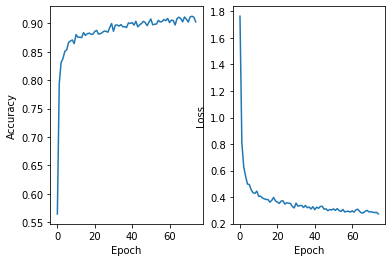

In [200]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)

    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.5965 - sparse_categorical_accuracy: 0.8750
	Test accuracy: 0.875


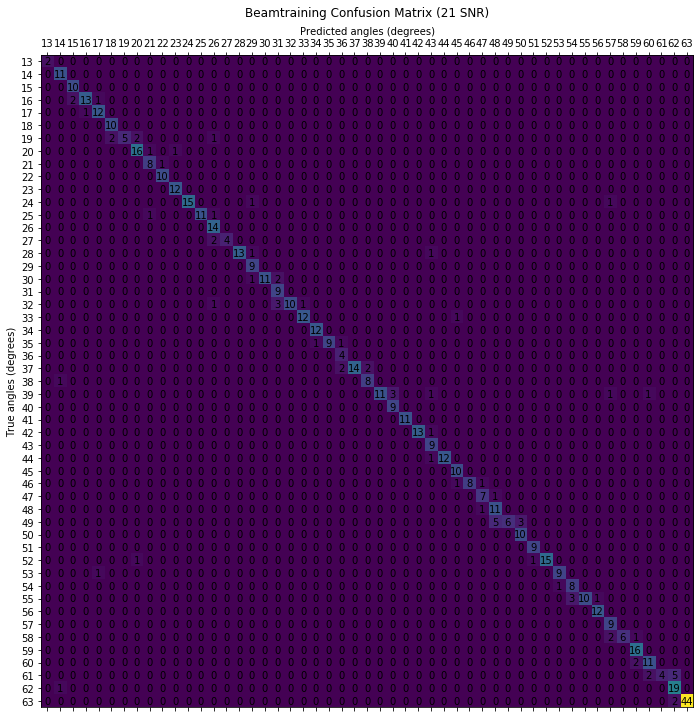

15 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.3177 - sparse_categorical_accuracy: 0.9256
	Test accuracy: 0.9256329


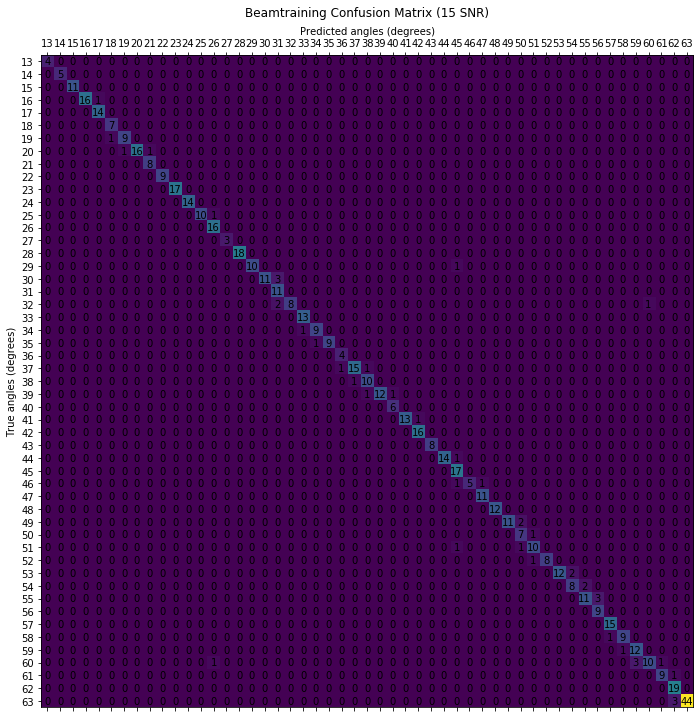

12 dB SNR --
(634, 51)
	labels:      (1, 50)
	predictions: (1, 50)
634/634 - 0s - loss: 0.5691 - sparse_categorical_accuracy: 0.8880
	Test accuracy: 0.88801265


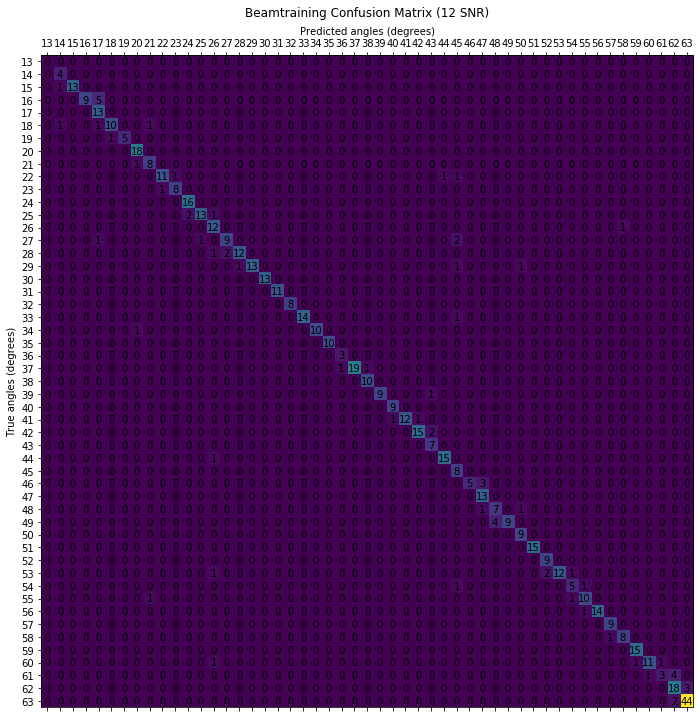

ALL SNR values --
(1898, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1898/1898 - 0s - loss: 0.4945 - sparse_categorical_accuracy: 0.8962


C:\Users\Benjamin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


	Test accuracy: 0.89620656


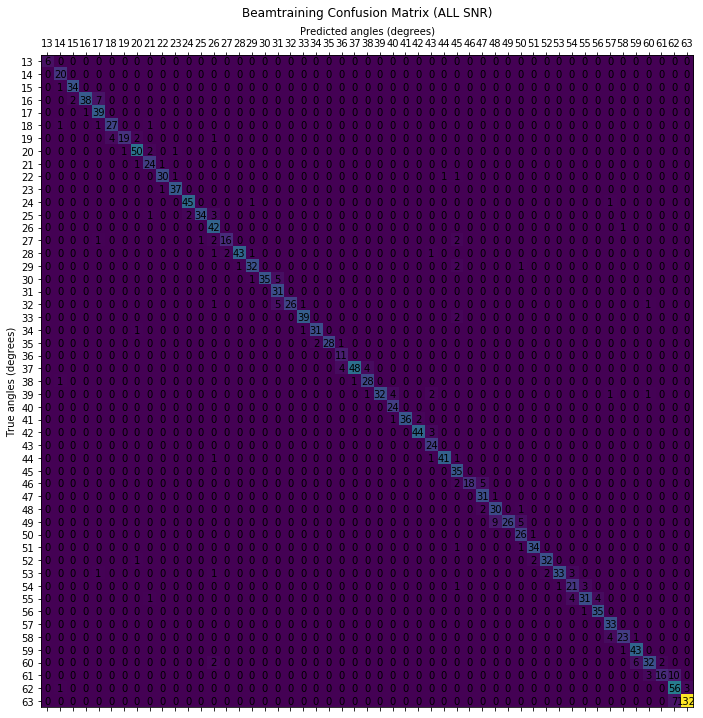


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.147511]
 [100.        26.879931]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.      ]
 [100.        37.376245]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

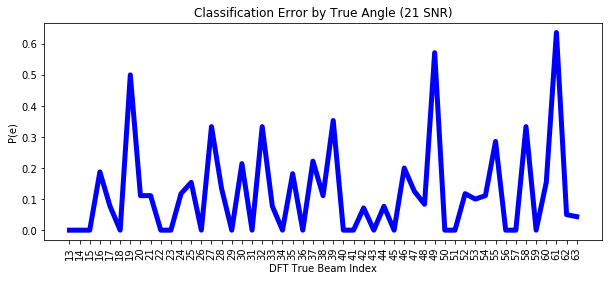

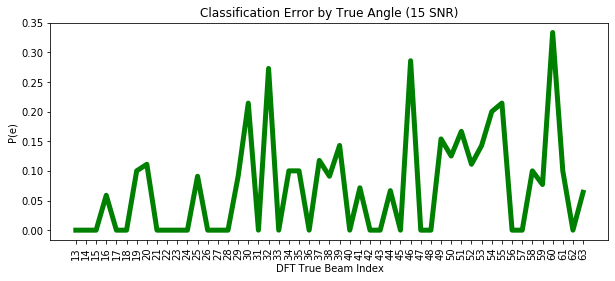

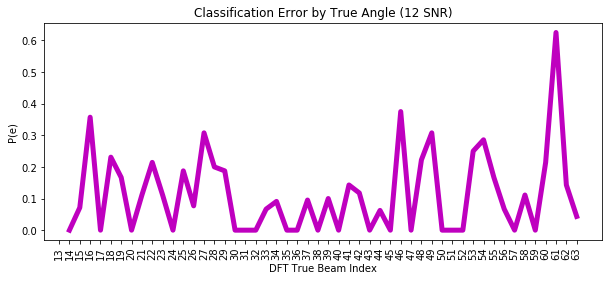

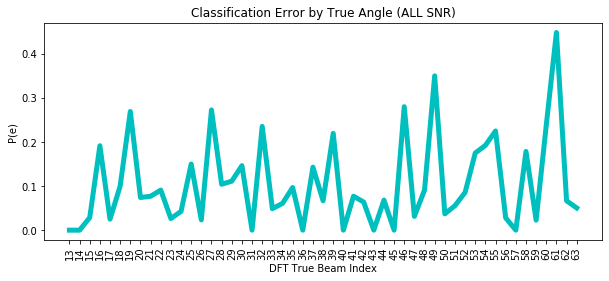

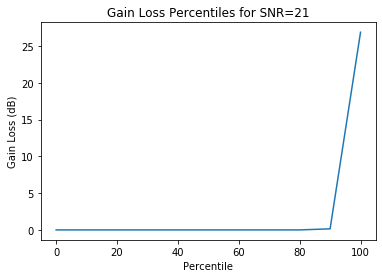

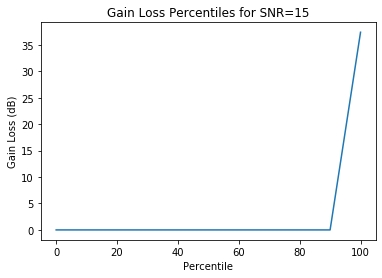

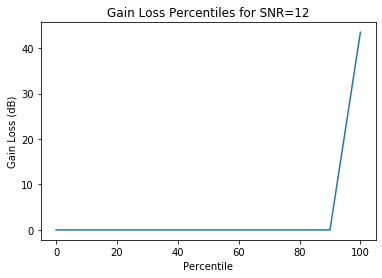

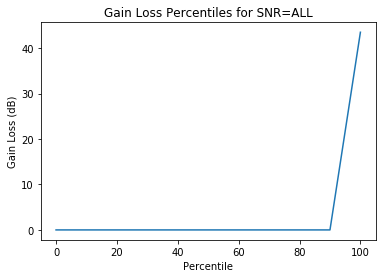

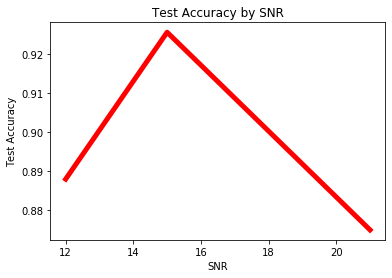

In [201]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array)

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {}
    
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_real_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe
        
    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss

## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe

### NN for 8 Measurements


Training model for PN combo 0...
Train on 3060 samples
Epoch 1/75
3060/3060 [==============================] - 2s 593us/sample - loss: 1.9130 - sparse_categorical_accuracy: 0.5304
Epoch 2/75
3060/3060 [==============================] - 1s 380us/sample - loss: 0.8932 - sparse_categorical_accuracy: 0.7686
Epoch 3/75
3060/3060 [==============================] - 1s 367us/sample - loss: 0.7100 - sparse_categorical_accuracy: 0.8039
Epoch 4/75
3060/3060 [==============================] - 1s 367us/sample - loss: 0.6135 - sparse_categorical_accuracy: 0.8281
Epoch 5/75
3060/3060 [==============================] - 1s 368us/sample - loss: 0.5550 - sparse_categorical_accuracy: 0.8474
Epoch 6/75
3060/3060 [==============================] - 1s 369us/sample - loss: 0.5100 - sparse_categorical_accuracy: 0.8477
Epoch 7/75
3060/3060 [==============================] - 1s 373us/sample - loss: 0.5131 - sparse_categorical_accuracy: 0.8507
Epoch 8/75
3060/3060 [==============================] - 1s 371us/samp

Text(0.5, 0, 'Epoch')

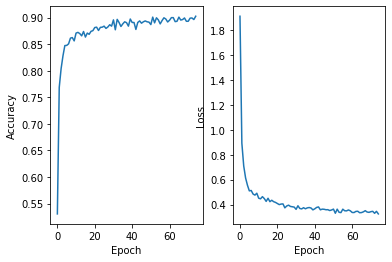

In [204]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)

    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.4756 - sparse_categorical_accuracy: 0.9035
	Test accuracy: 0.903481


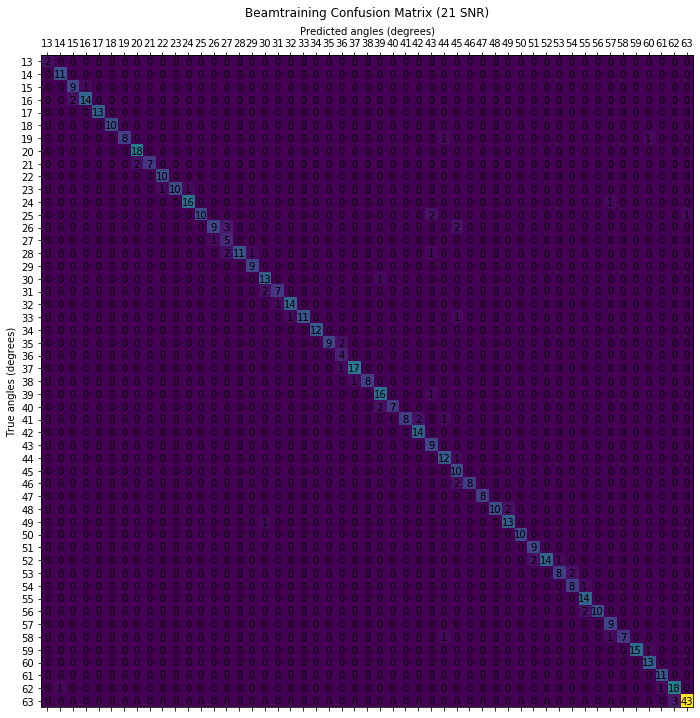

15 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.4908 - sparse_categorical_accuracy: 0.9019
	Test accuracy: 0.90189874


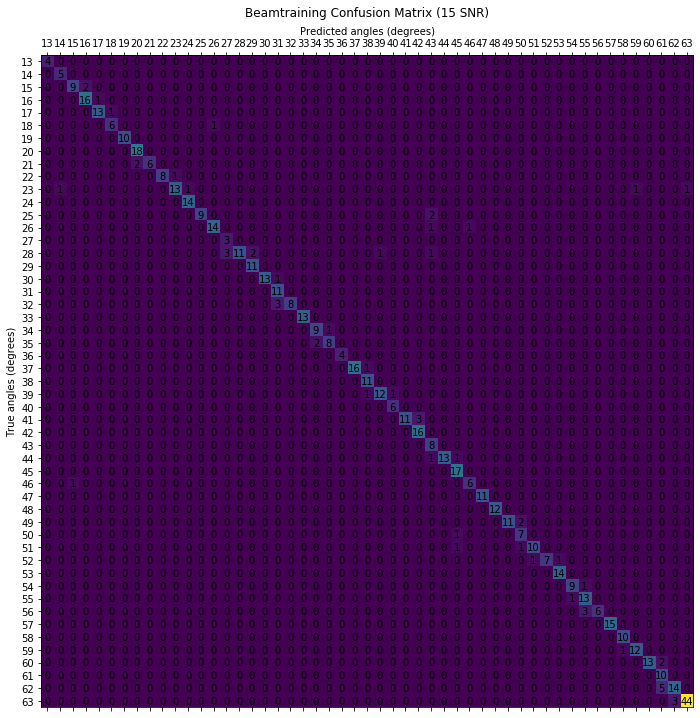

12 dB SNR --
(634, 51)
	labels:      (1, 50)
	predictions: (1, 50)
634/634 - 0s - loss: 0.6391 - sparse_categorical_accuracy: 0.8754
	Test accuracy: 0.87539434


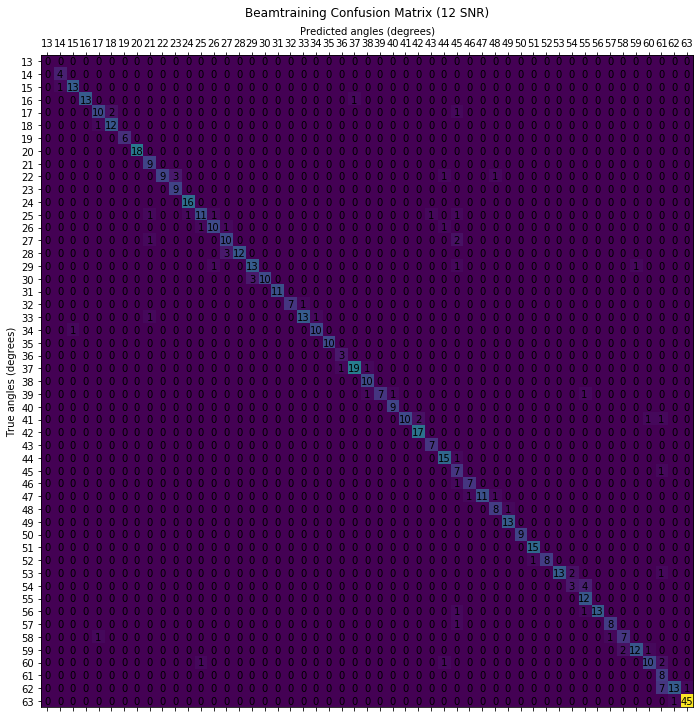

ALL SNR values --
(1898, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1898/1898 - 0s - loss: 0.5352 - sparse_categorical_accuracy: 0.8936


C:\Users\Benjamin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


	Test accuracy: 0.89357215


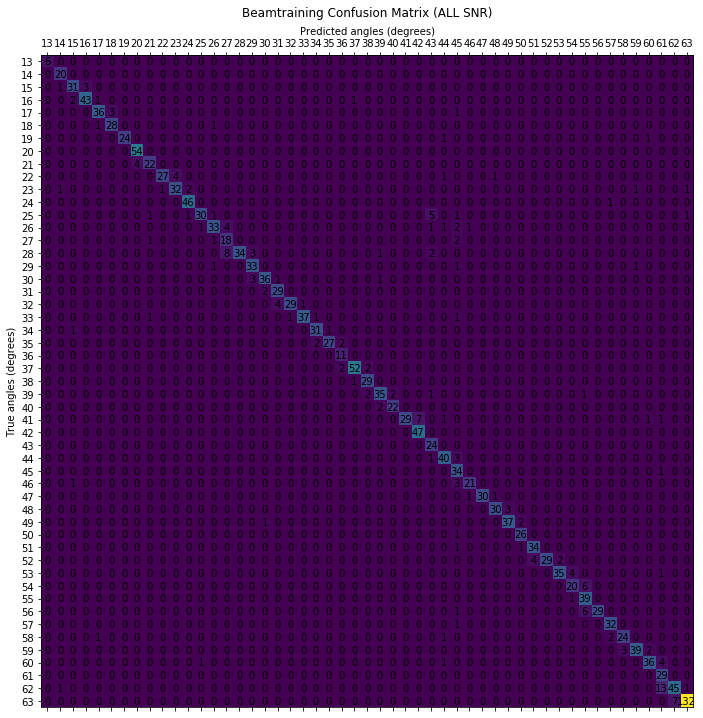


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.      ]
 [100.        37.896064]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.      ]
 [100.        30.585475]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

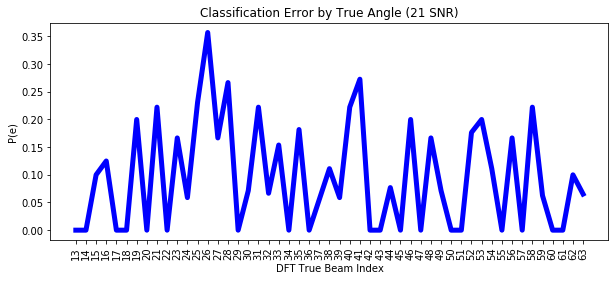

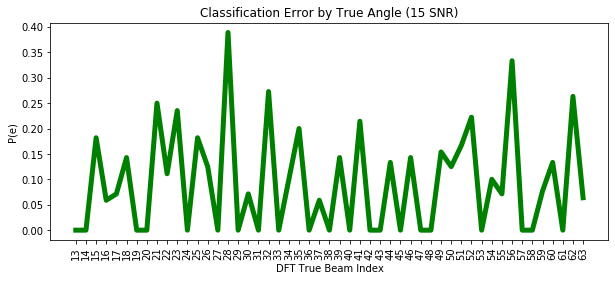

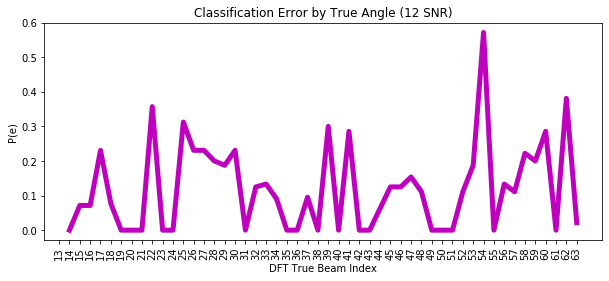

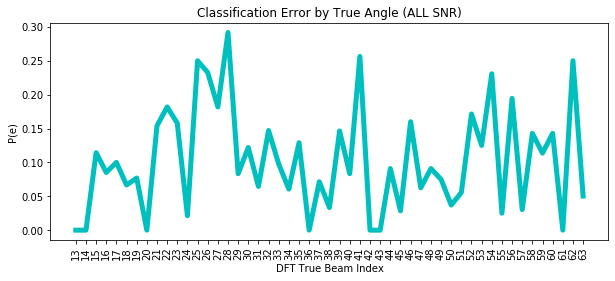

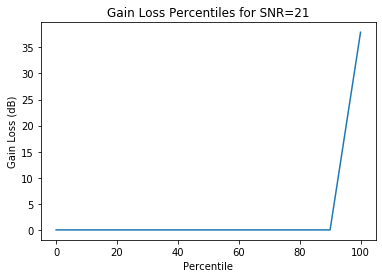

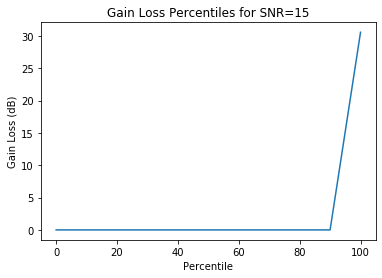

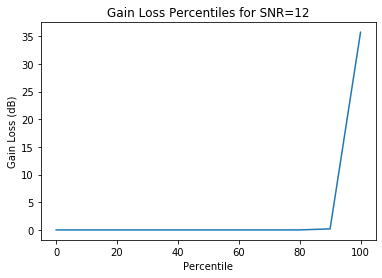

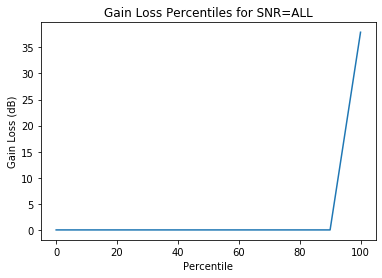

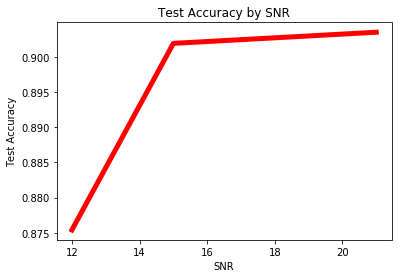

In [205]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array)

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {}
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_real_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam 
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe
        
    ## Store the gain loss dictionary for this PN beam combo 
    all_curMeas_gainloss[pn_i] = pn_i_gainloss

## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance 
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe

### NN for 7 Measurements


Training model for PN combo 0...
Train on 3060 samples
Epoch 1/75
3060/3060 [==============================] - 2s 643us/sample - loss: 1.9765 - sparse_categorical_accuracy: 0.4971
Epoch 2/75
3060/3060 [==============================] - 1s 418us/sample - loss: 1.0632 - sparse_categorical_accuracy: 0.7268
Epoch 3/75
3060/3060 [==============================] - 1s 414us/sample - loss: 0.8302 - sparse_categorical_accuracy: 0.7804
Epoch 4/75
3060/3060 [==============================] - 1s 422us/sample - loss: 0.7109 - sparse_categorical_accuracy: 0.7971
Epoch 5/75
3060/3060 [==============================] - 1s 417us/sample - loss: 0.6586 - sparse_categorical_accuracy: 0.8137
Epoch 6/75
3060/3060 [==============================] - 1s 417us/sample - loss: 0.5933 - sparse_categorical_accuracy: 0.8291
Epoch 7/75
3060/3060 [==============================] - 1s 415us/sample - loss: 0.6068 - sparse_categorical_accuracy: 0.8206
Epoch 8/75
3060/3060 [==============================] - 1s 419us/samp

Text(0.5, 0, 'Epoch')

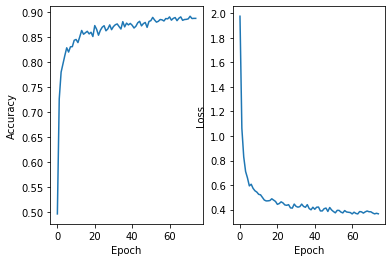

In [208]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)

    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.5246 - sparse_categorical_accuracy: 0.8797
	Test accuracy: 0.87974685


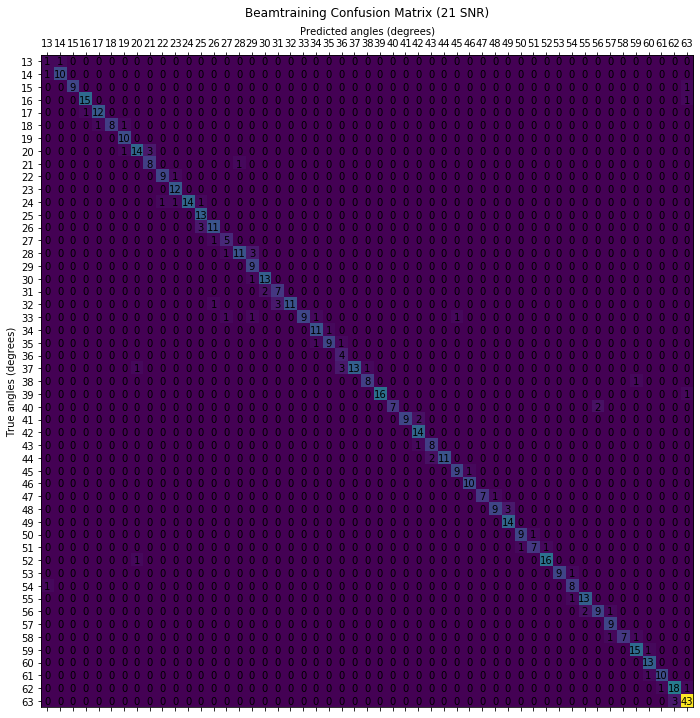

15 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.3520 - sparse_categorical_accuracy: 0.9130
	Test accuracy: 0.91297466


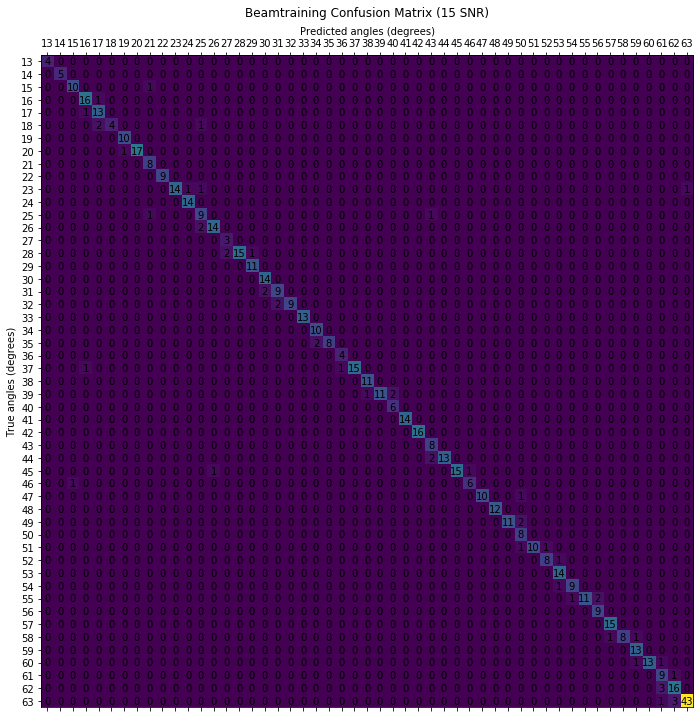

12 dB SNR --
(634, 51)
	labels:      (1, 50)
	predictions: (1, 50)
634/634 - 0s - loss: 0.7065 - sparse_categorical_accuracy: 0.8738
	Test accuracy: 0.873817


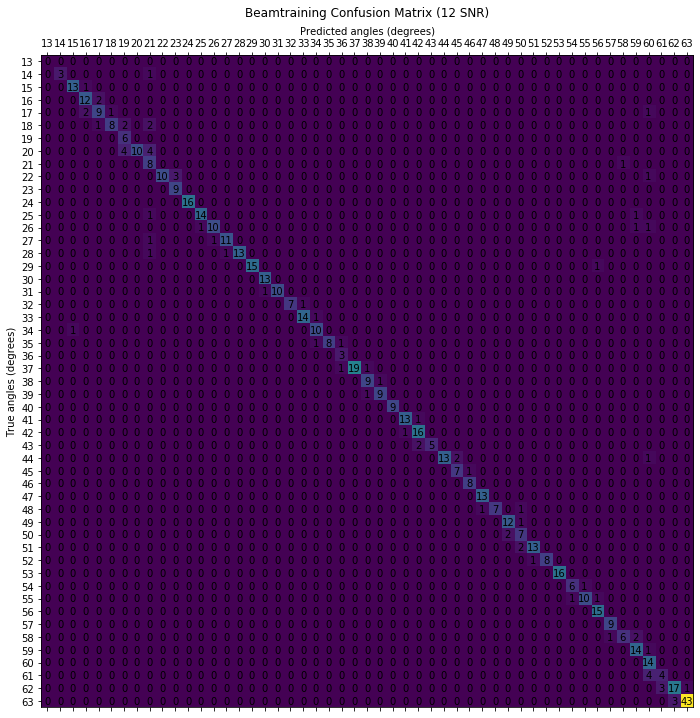

ALL SNR values --
(1898, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1898/1898 - 0s - loss: 0.5279 - sparse_categorical_accuracy: 0.8888


C:\Users\Benjamin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


	Test accuracy: 0.88883036


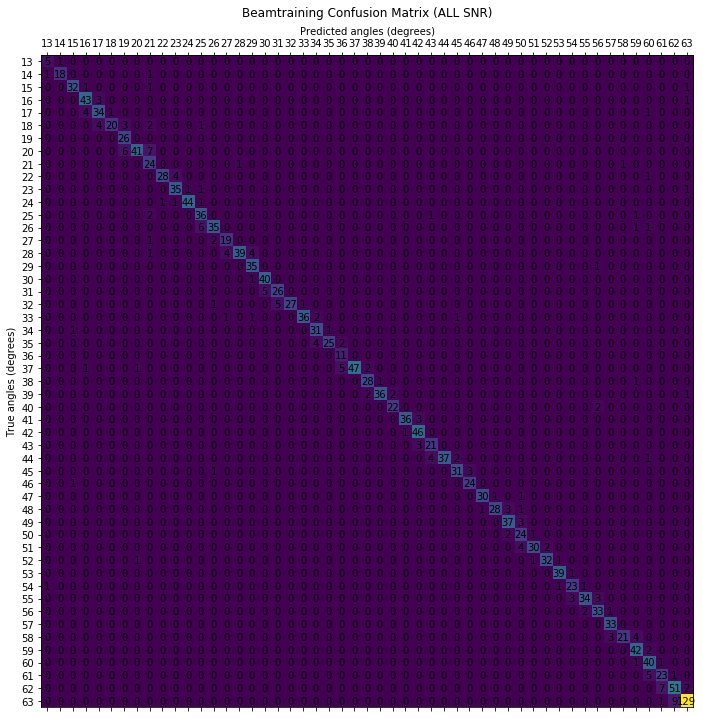


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[0.0000000e+00 0.0000000e+00]
 [1.0000000e+01 0.0000000e+00]
 [2.0000000e+01 0.0000000e+00]
 [3.0000000e+01 0.0000000e+00]
 [4.0000000e+01 0.0000000e+00]
 [5.0000000e+01 0.0000000e+00]
 [6.0000000e+01 0.0000000e+00]
 [7.0000000e+01 0.0000000e+00]
 [8.0000000e+01 0.0000000e+00]
 [9.0000000e+01 8.7105000e-02]
 [1.0000000e+02 3.3585907e+01]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.      ]
 [100.        39.111949]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.

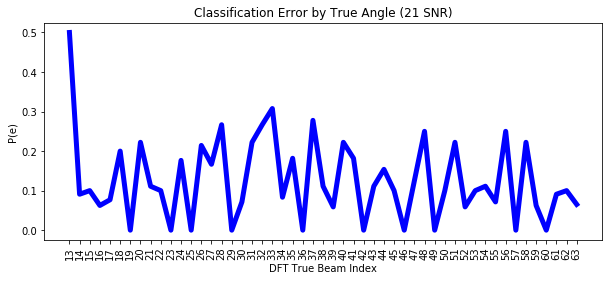

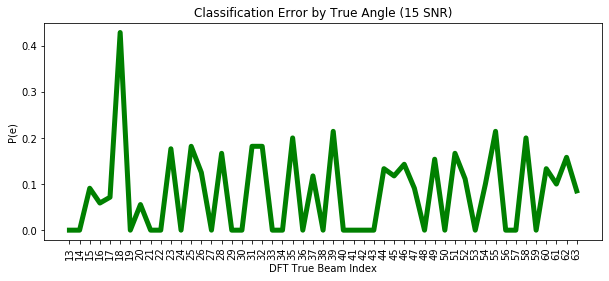

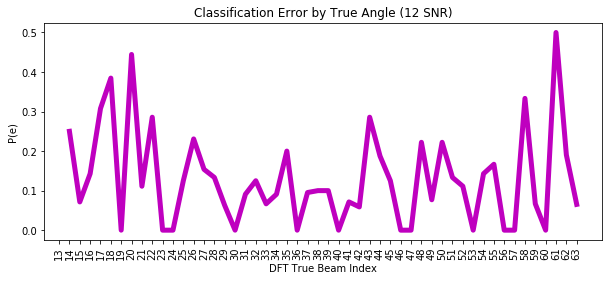

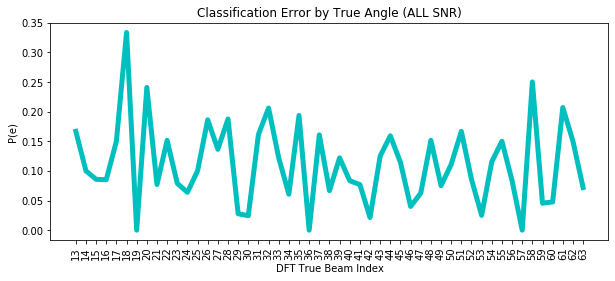

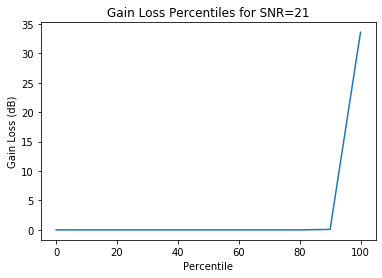

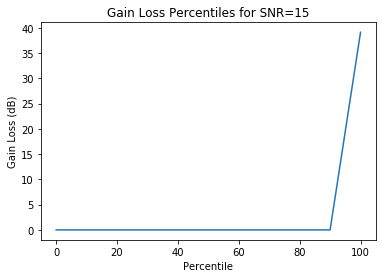

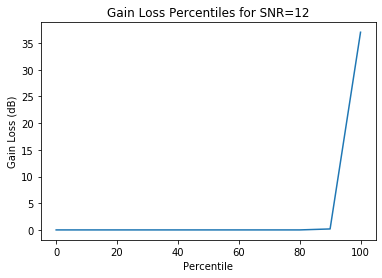

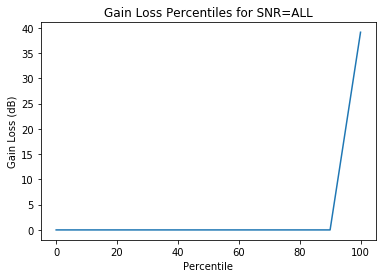

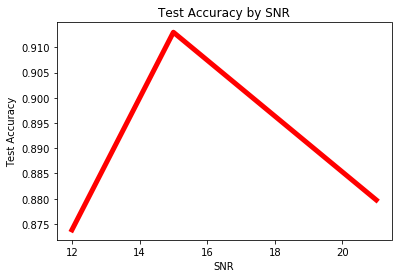

In [209]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array)

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_real_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe
        
    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss

## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe

### NN for 6 Measurements


Training model for PN combo 0...
Train on 3060 samples
Epoch 1/75
3060/3060 [==============================] - 2s 587us/sample - loss: 2.2427 - sparse_categorical_accuracy: 0.4160
Epoch 2/75
3060/3060 [==============================] - 1s 373us/sample - loss: 1.3451 - sparse_categorical_accuracy: 0.6353
Epoch 3/75
3060/3060 [==============================] - 1s 373us/sample - loss: 1.0651 - sparse_categorical_accuracy: 0.7029
Epoch 4/75
3060/3060 [==============================] - 1s 373us/sample - loss: 0.9269 - sparse_categorical_accuracy: 0.7425
Epoch 5/75
3060/3060 [==============================] - 1s 374us/sample - loss: 0.8574 - sparse_categorical_accuracy: 0.7650
Epoch 6/75
3060/3060 [==============================] - 1s 374us/sample - loss: 0.8029 - sparse_categorical_accuracy: 0.7742
Epoch 7/75
3060/3060 [==============================] - 1s 393us/sample - loss: 0.7826 - sparse_categorical_accuracy: 0.7729
Epoch 8/75
3060/3060 [==============================] - 1s 376us/samp

Text(0.5, 0, 'Epoch')

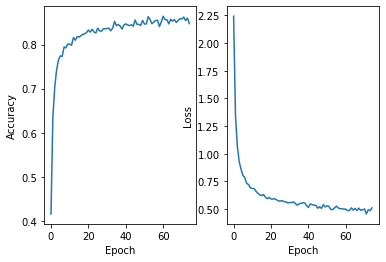

In [212]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)

    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.6019 - sparse_categorical_accuracy: 0.8718
	Test accuracy: 0.8718355


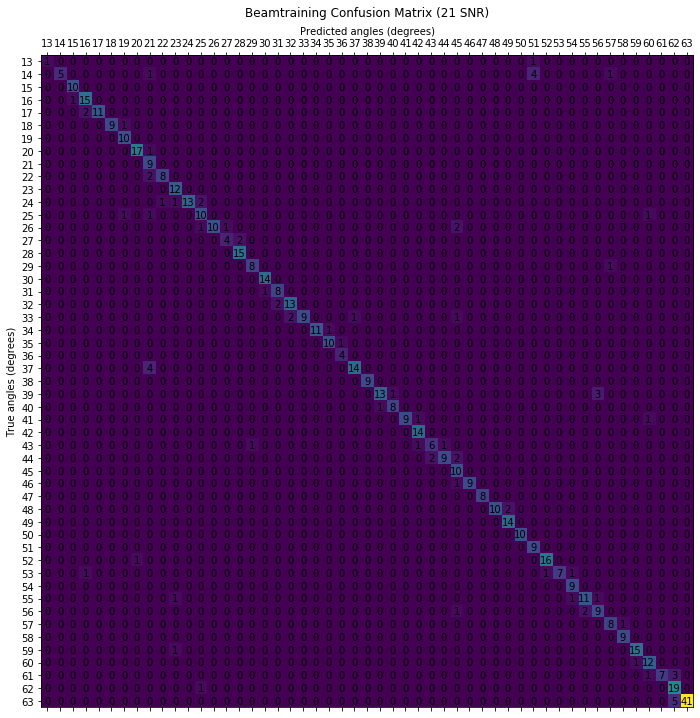

15 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.4548 - sparse_categorical_accuracy: 0.8940
	Test accuracy: 0.89398736


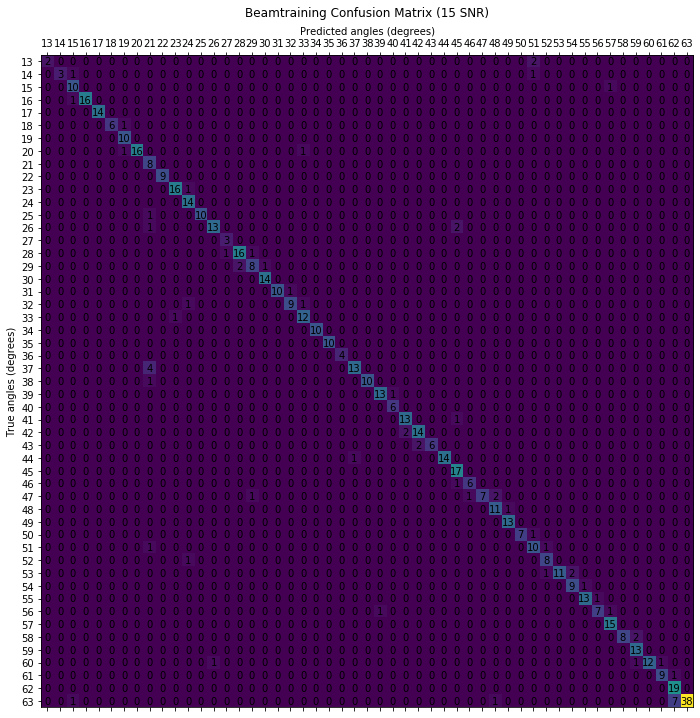

12 dB SNR --
(634, 51)
	labels:      (1, 50)
	predictions: (1, 50)
634/634 - 0s - loss: 0.5185 - sparse_categorical_accuracy: 0.8754
	Test accuracy: 0.87539434


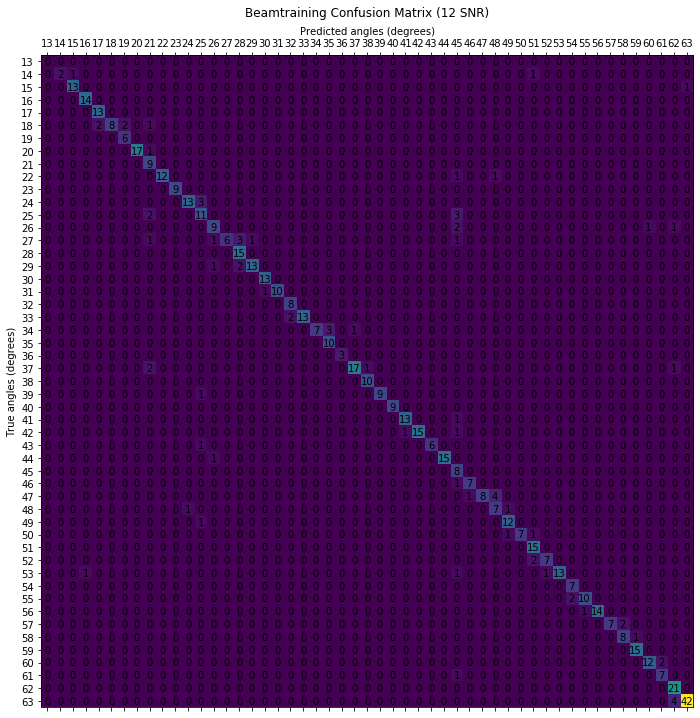

C:\Users\Benjamin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


ALL SNR values --
(1898, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1898/1898 - 0s - loss: 0.5251 - sparse_categorical_accuracy: 0.8804
	Test accuracy: 0.8804004


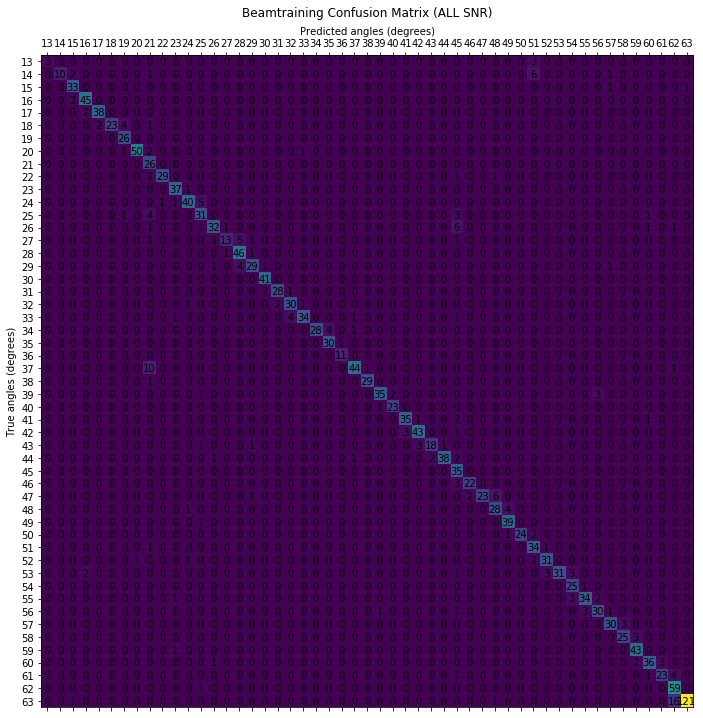


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.257879]
 [100.        37.362216]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.      ]
 [100.        31.095502]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

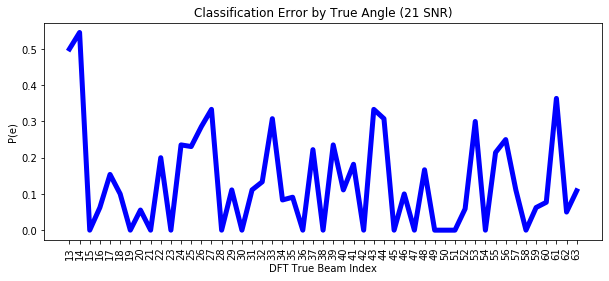

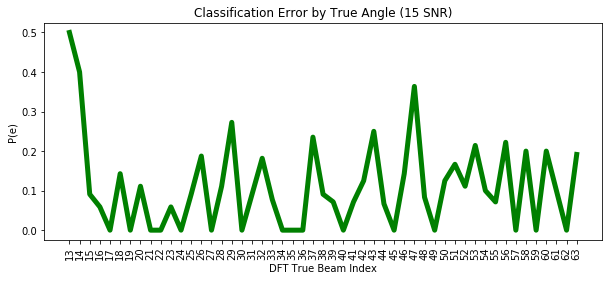

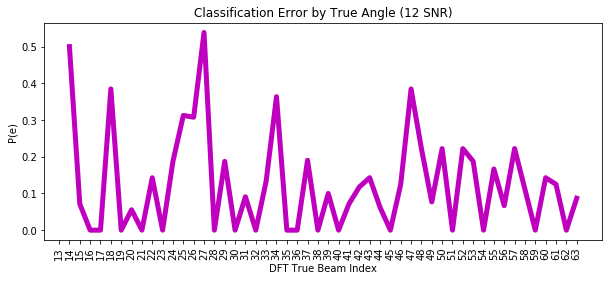

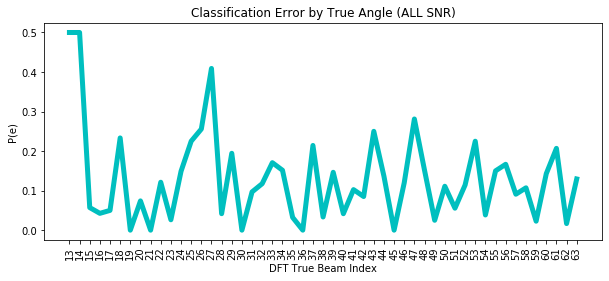

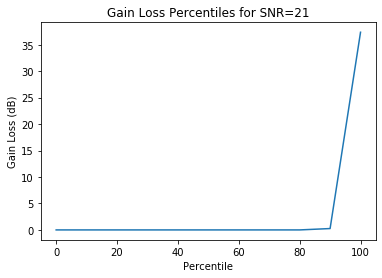

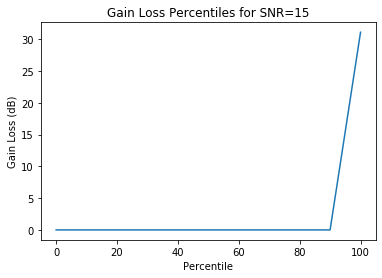

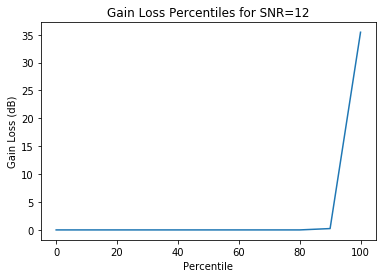

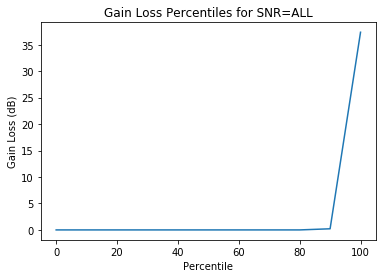

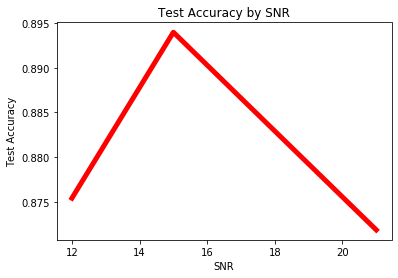

In [213]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array)

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_real_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe
        
    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss

## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe

### NN for 5 Measurements


Training model for PN combo 0...
Train on 3060 samples
Epoch 1/75
3060/3060 [==============================] - 2s 809us/sample - loss: 2.4998 - sparse_categorical_accuracy: 0.3340
Epoch 2/75
3060/3060 [==============================] - 1s 455us/sample - loss: 1.7187 - sparse_categorical_accuracy: 0.5291
Epoch 3/75
3060/3060 [==============================] - 1s 442us/sample - loss: 1.4406 - sparse_categorical_accuracy: 0.5925
Epoch 4/75
3060/3060 [==============================] - 1s 442us/sample - loss: 1.2888 - sparse_categorical_accuracy: 0.6379
Epoch 5/75
3060/3060 [==============================] - 1s 444us/sample - loss: 1.1896 - sparse_categorical_accuracy: 0.6611
Epoch 6/75
3060/3060 [==============================] - 1s 445us/sample - loss: 1.1085 - sparse_categorical_accuracy: 0.6889
Epoch 7/75
3060/3060 [==============================] - 1s 461us/sample - loss: 1.0862 - sparse_categorical_accuracy: 0.6850
Epoch 8/75
3060/3060 [==============================] - 1s 474us/samp

Text(0.5, 0, 'Epoch')

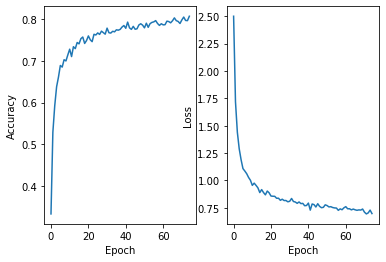

In [216]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)

    # Test without Dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 0.9701 - sparse_categorical_accuracy: 0.8244
	Test accuracy: 0.8243671


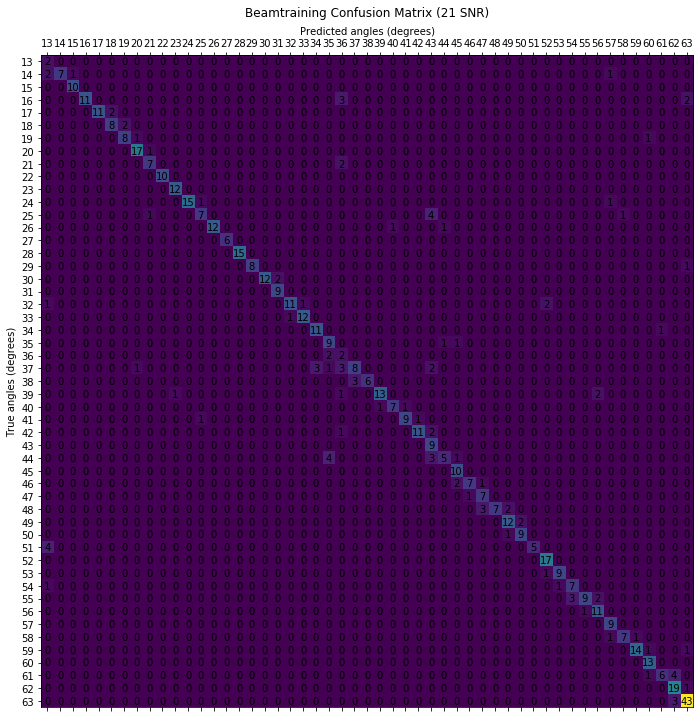

15 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 1.4580 - sparse_categorical_accuracy: 0.8085
	Test accuracy: 0.8085443


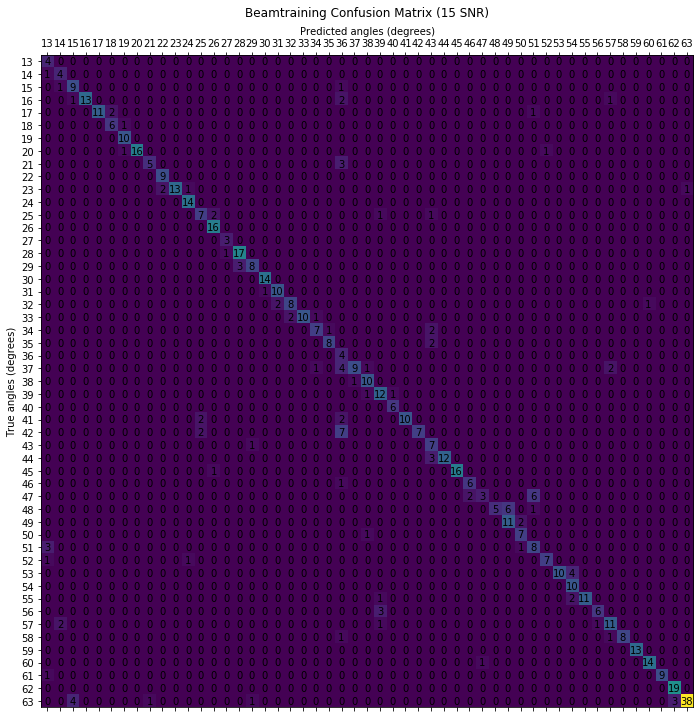

12 dB SNR --
(634, 51)
	labels:      (1, 50)
	predictions: (0, 50)
634/634 - 0s - loss: 1.4957 - sparse_categorical_accuracy: 0.8297
	Test accuracy: 0.829653


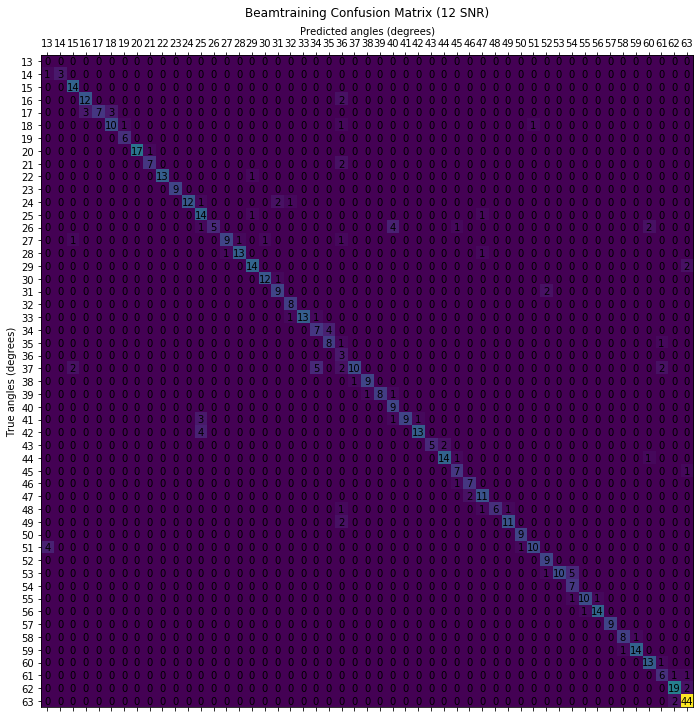

ALL SNR values --
(1898, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1898/1898 - 0s - loss: 1.3082 - sparse_categorical_accuracy: 0.8209


C:\Users\Benjamin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


	Test accuracy: 0.8208641


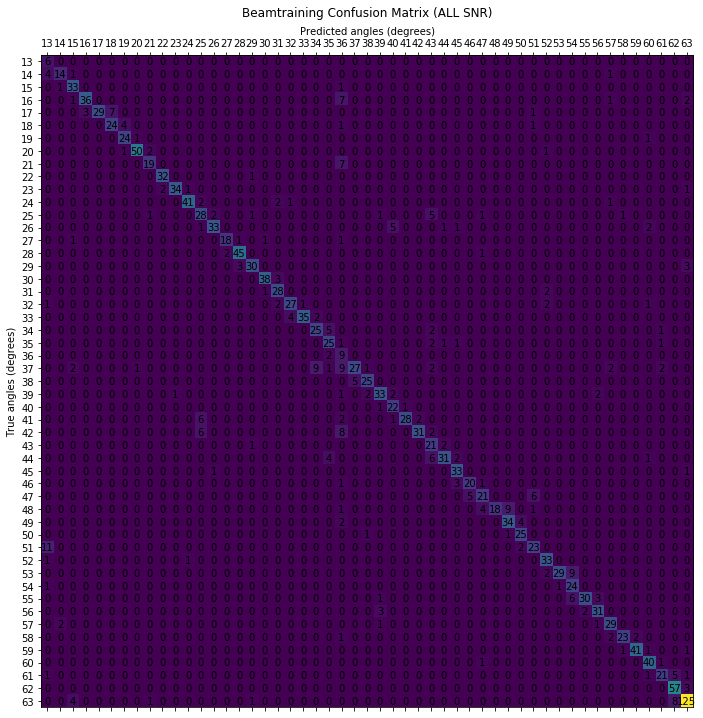


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.         0.919999]
 [100.        36.609055]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         0.      ]
 [ 90.        11.512142]
 [100.        39.111949]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

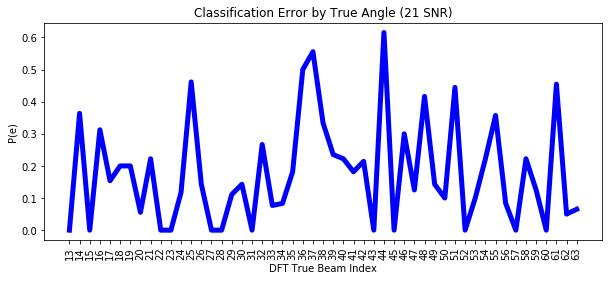

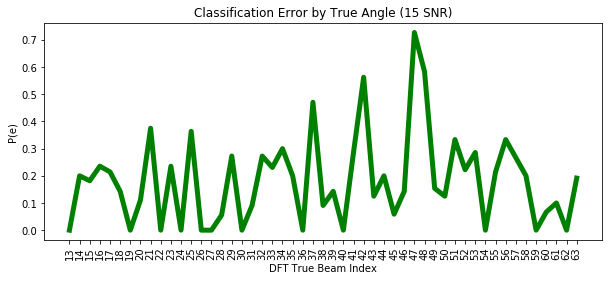

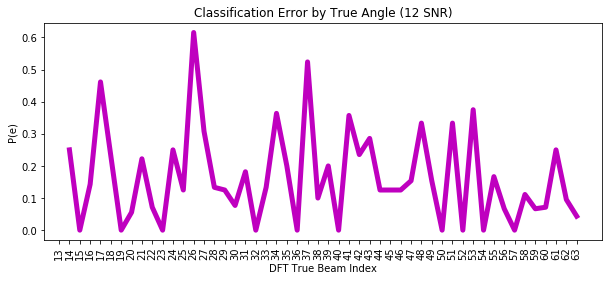

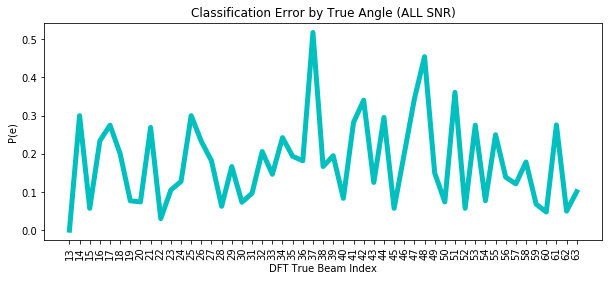

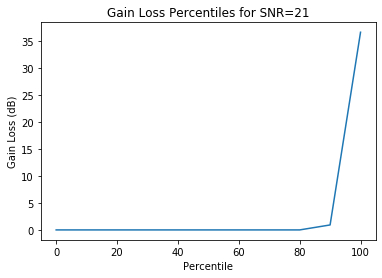

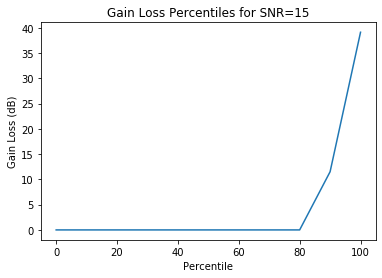

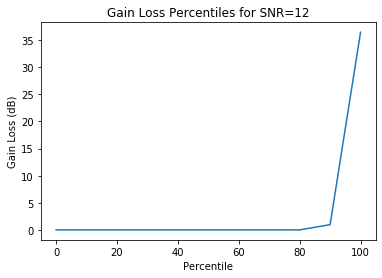

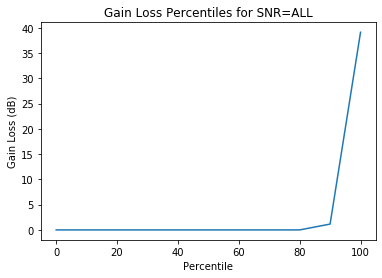

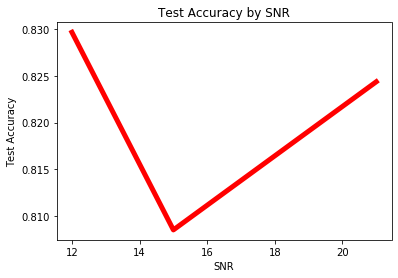

In [217]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array)

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {}
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        ## Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_real_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe
    
    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss    

## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);
    
# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)

# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe

### NN for 4 Measurements


Training model for PN combo 0...
Train on 3060 samples
Epoch 1/75
3060/3060 [==============================] - 2s 769us/sample - loss: 2.8196 - sparse_categorical_accuracy: 0.2565
Epoch 2/75
3060/3060 [==============================] - 2s 547us/sample - loss: 2.2075 - sparse_categorical_accuracy: 0.3915
Epoch 3/75
3060/3060 [==============================] - 2s 552us/sample - loss: 1.9570 - sparse_categorical_accuracy: 0.4608
Epoch 4/75
3060/3060 [==============================] - 2s 569us/sample - loss: 1.7818 - sparse_categorical_accuracy: 0.5108
Epoch 5/75
3060/3060 [==============================] - 2s 548us/sample - loss: 1.6829 - sparse_categorical_accuracy: 0.5431
Epoch 6/75
3060/3060 [==============================] - 2s 558us/sample - loss: 1.6446 - sparse_categorical_accuracy: 0.5435
Epoch 7/75
3060/3060 [==============================] - 2s 573us/sample - loss: 1.5461 - sparse_categorical_accuracy: 0.5719
Epoch 8/75
3060/3060 [==============================] - 2s 556us/samp

Text(0.5, 0, 'Epoch')

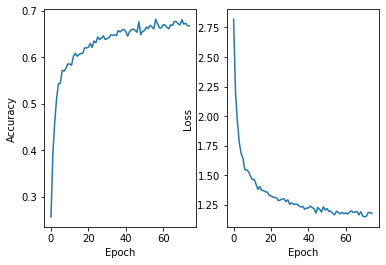

In [220]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)

    # Test without Dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 1.8610 - sparse_categorical_accuracy: 0.7215
	Test accuracy: 0.721519


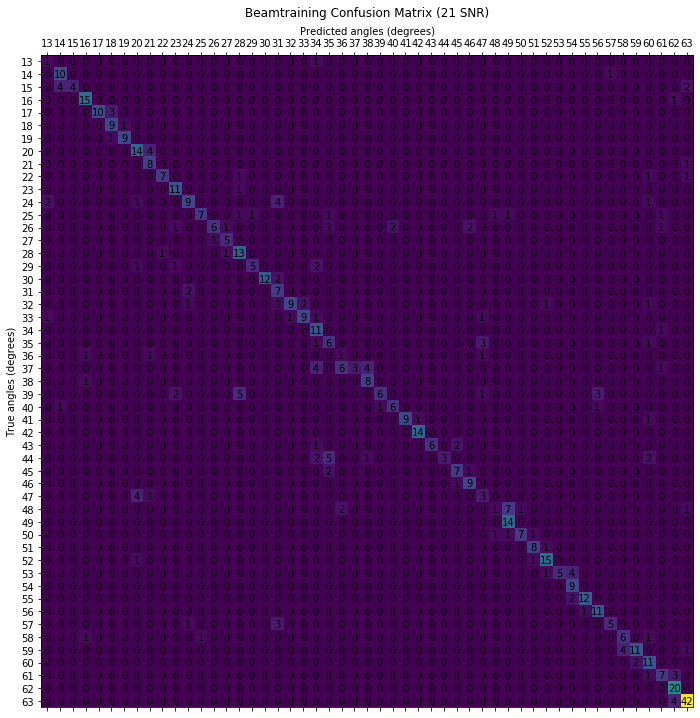

15 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 1.8546 - sparse_categorical_accuracy: 0.7184
	Test accuracy: 0.7183544


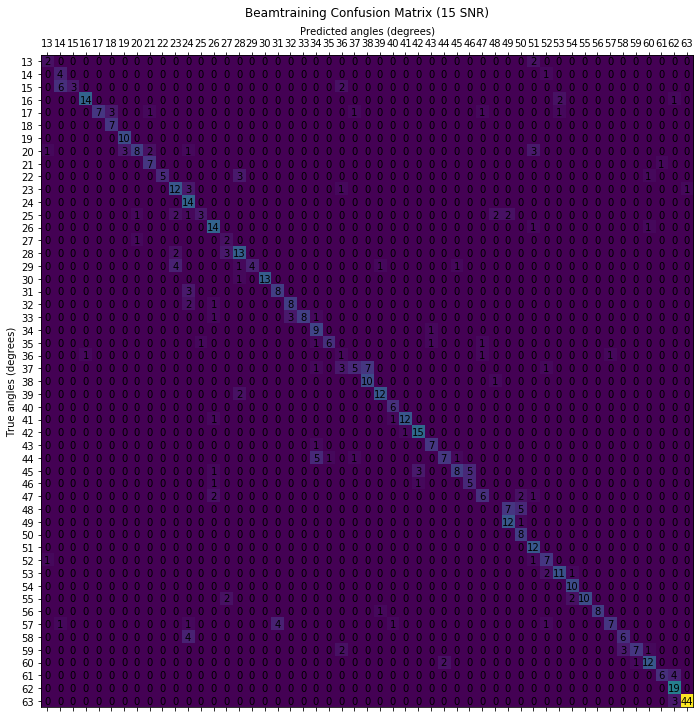

12 dB SNR --
(634, 51)
	labels:      (1, 50)
	predictions: (1, 50)
634/634 - 0s - loss: 1.1356 - sparse_categorical_accuracy: 0.7366
	Test accuracy: 0.73659307


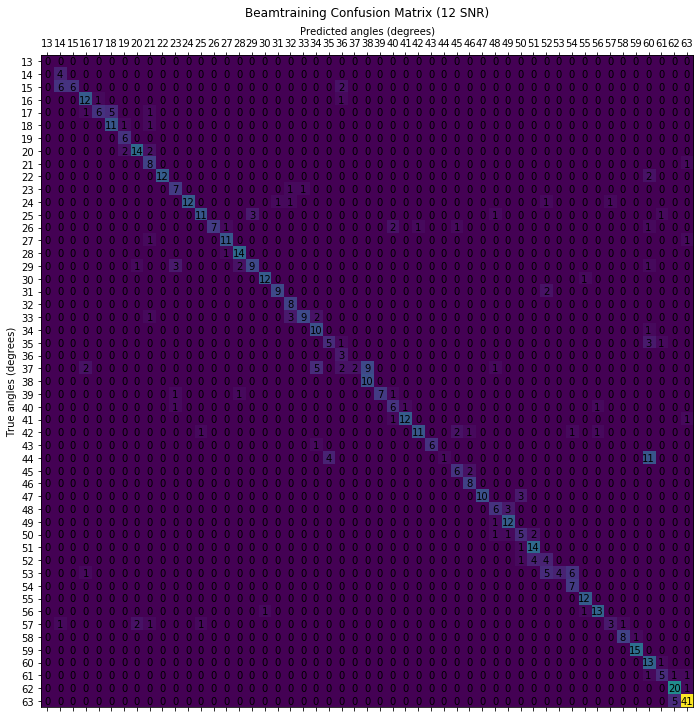

C:\Users\Benjamin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


ALL SNR values --
(1898, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1898/1898 - 0s - loss: 1.6166 - sparse_categorical_accuracy: 0.7255
	Test accuracy: 0.7255005


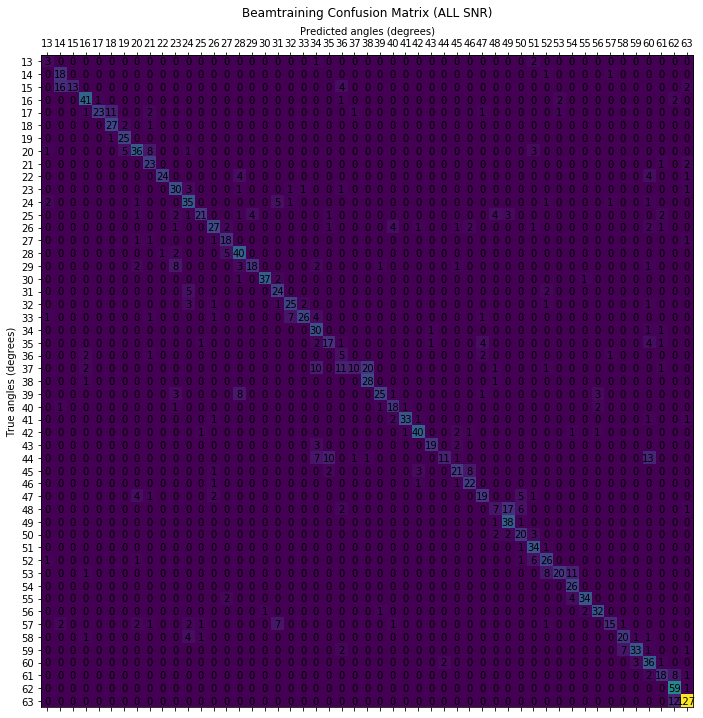


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         1.270486]
 [ 90.        18.738069]
 [100.        42.043747]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.      ]
 [ 80.         1.348564]
 [ 90.        22.028597]
 [100.        39.526982]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.      ]
 [ 60.         0.      ]
 [ 70.         0.     

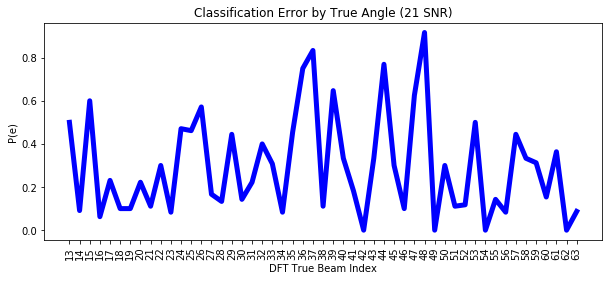

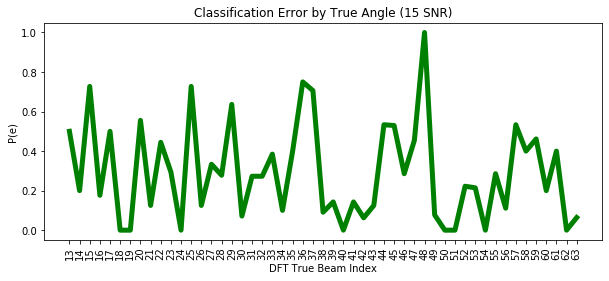

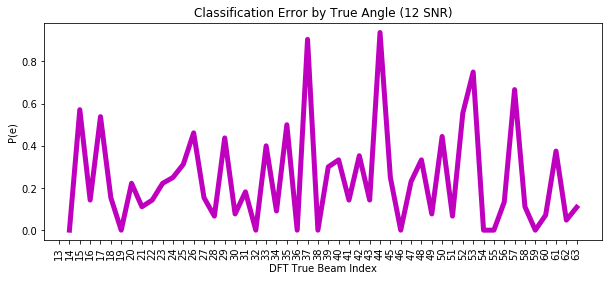

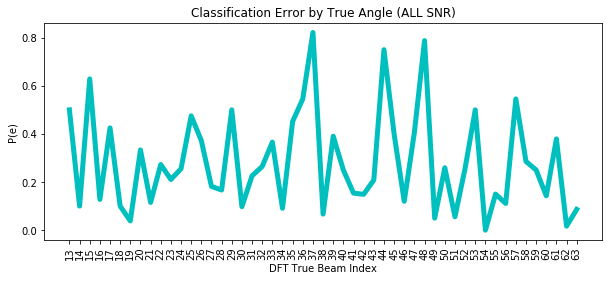

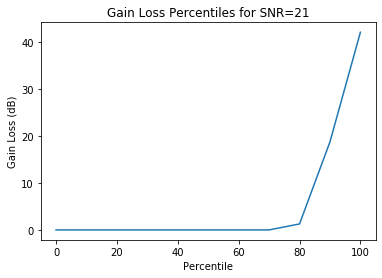

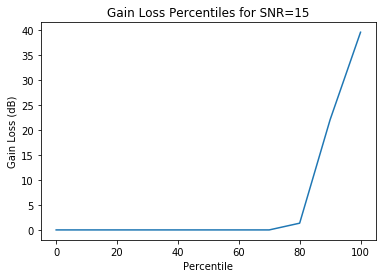

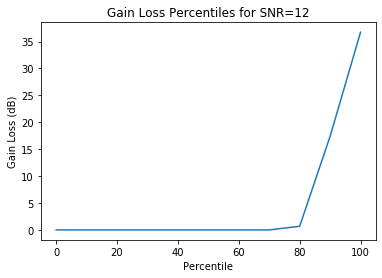

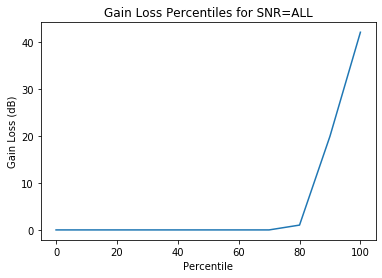

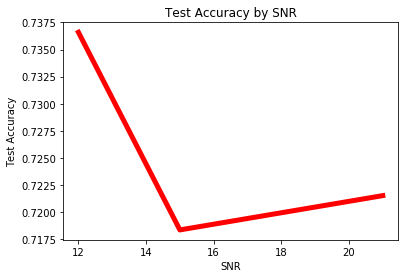

In [221]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array)

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {}
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        ## Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_real_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe
    
    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss    

## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);
    
# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)

# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe

### NN for 3 Measurements


Training model for PN combo 0...
Train on 3060 samples
Epoch 1/75
3060/3060 [==============================] - 3s 1ms/sample - loss: 3.3051 - sparse_categorical_accuracy: 0.1490
Epoch 2/75
3060/3060 [==============================] - 2s 793us/sample - loss: 2.9292 - sparse_categorical_accuracy: 0.2297
Epoch 3/75
3060/3060 [==============================] - 2s 781us/sample - loss: 2.7017 - sparse_categorical_accuracy: 0.2794
Epoch 4/75
3060/3060 [==============================] - 2s 755us/sample - loss: 2.6129 - sparse_categorical_accuracy: 0.2958
Epoch 5/75
3060/3060 [==============================] - 2s 753us/sample - loss: 2.5351 - sparse_categorical_accuracy: 0.3209
Epoch 6/75
3060/3060 [==============================] - 2s 776us/sample - loss: 2.4652 - sparse_categorical_accuracy: 0.3438
Epoch 7/75
3060/3060 [==============================] - 2s 782us/sample - loss: 2.4317 - sparse_categorical_accuracy: 0.3539
Epoch 8/75
3060/3060 [==============================] - 2s 777us/sample

Text(0.5, 0, 'Epoch')

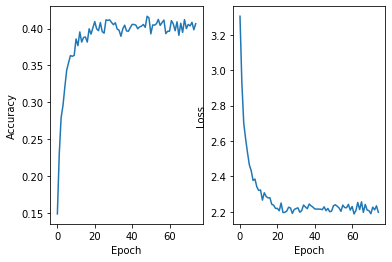

In [239]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)

    # Test without Dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 4.2423 - sparse_categorical_accuracy: 0.4478
	Test accuracy: 0.4477848


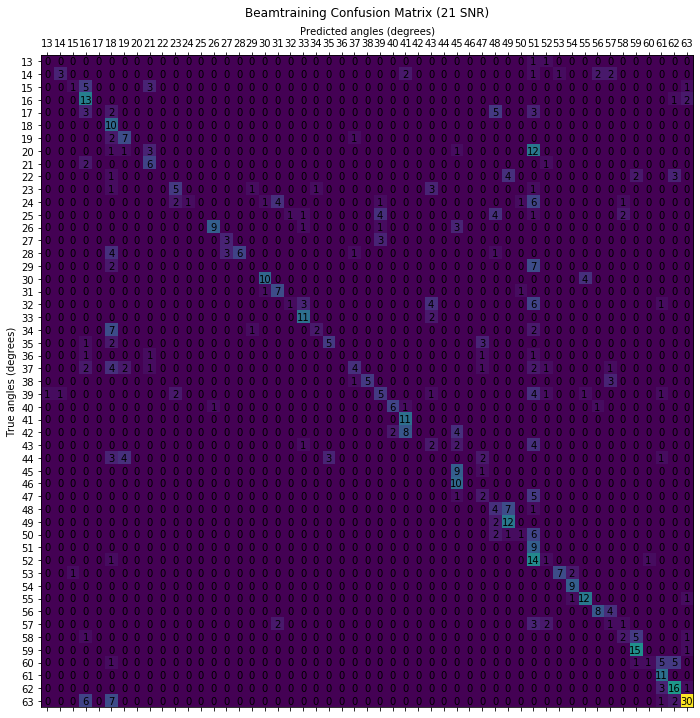

15 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (0, 50)
632/632 - 0s - loss: 7.2157 - sparse_categorical_accuracy: 0.3782
	Test accuracy: 0.37816456


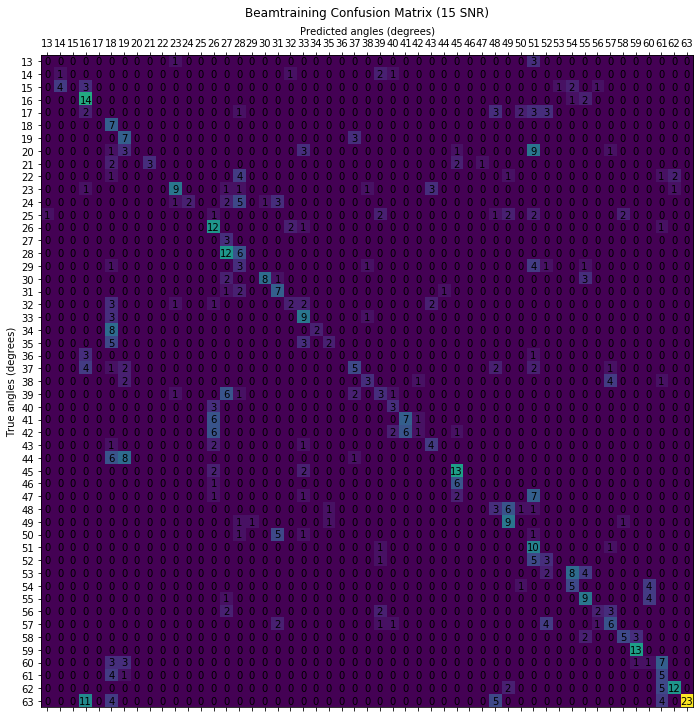

12 dB SNR --
(634, 51)
	labels:      (1, 50)
	predictions: (1, 50)
634/634 - 0s - loss: 2.6399 - sparse_categorical_accuracy: 0.4243
	Test accuracy: 0.4242902


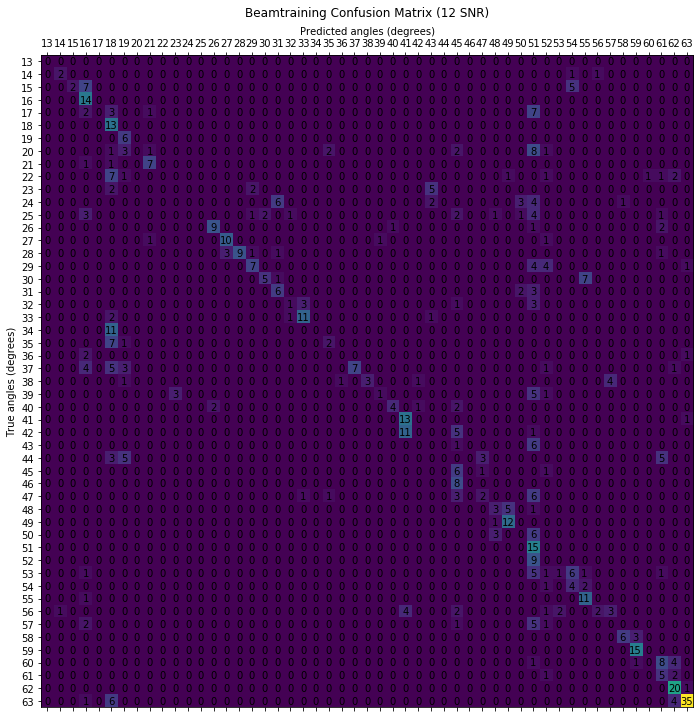

C:\Users\Benjamin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


ALL SNR values --
(1898, 51)
	labels:      (0, 50)
	predictions: (0, 50)
1898/1898 - 0s - loss: 4.6971 - sparse_categorical_accuracy: 0.4168
	Test accuracy: 0.41675448


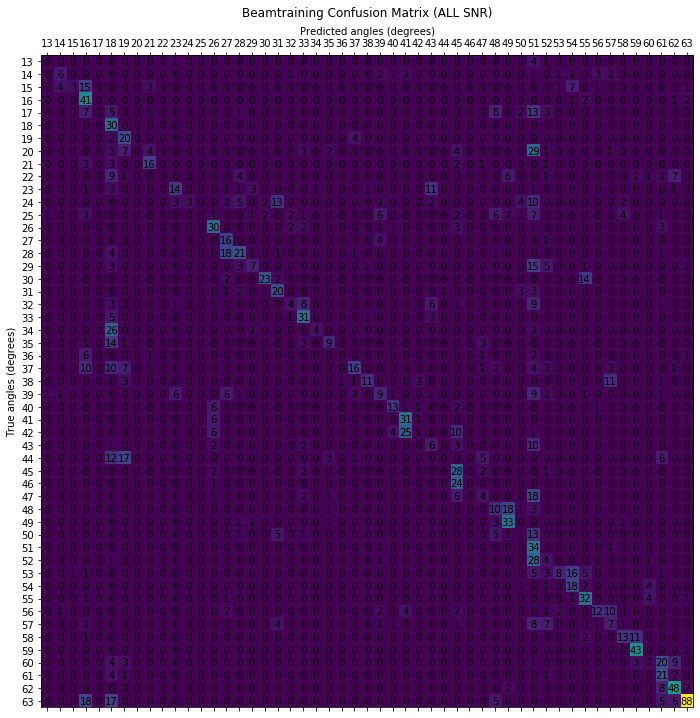


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         0.688028]
 [ 60.         6.250801]
 [ 70.        18.477337]
 [ 80.        25.133213]
 [ 90.        34.405385]
 [100.        39.343888]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.47495 ]
 [ 50.         3.992693]
 [ 60.        18.239557]
 [ 70.        23.011647]
 [ 80.        27.425032]
 [ 90.        35.366218]
 [100.        39.942014]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         0.      ]
 [ 30.         0.      ]
 [ 40.         0.      ]
 [ 50.         1.677365]
 [ 60.        12.282474]
 [ 70.        19.08654

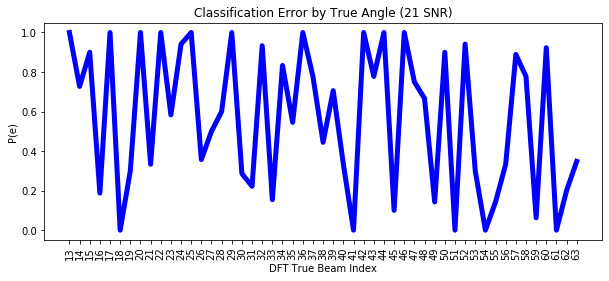

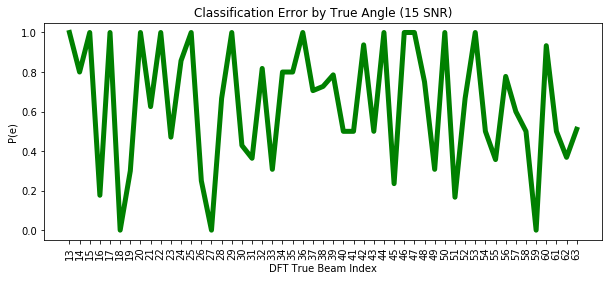

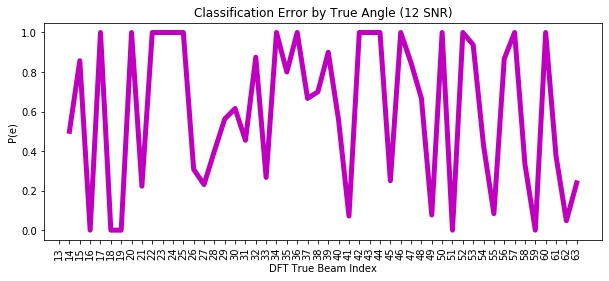

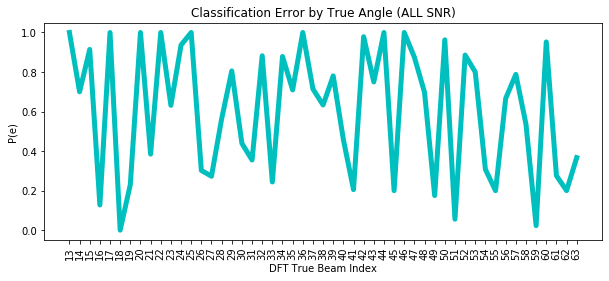

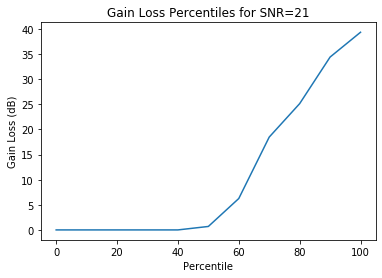

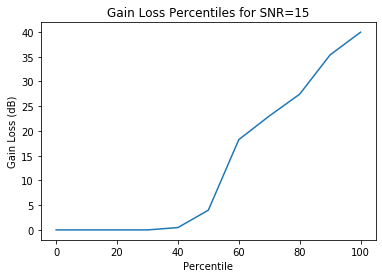

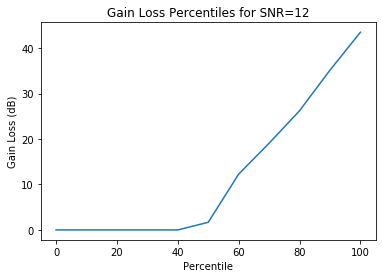

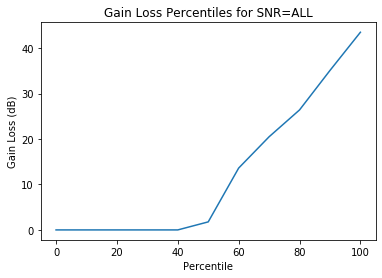

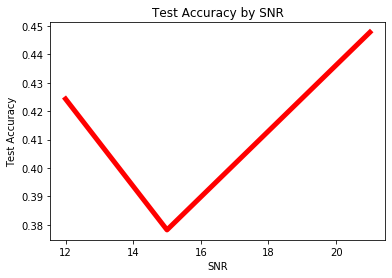

In [240]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array)

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {}
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        ## Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_real_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe
    
    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss    

## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);
    
# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)

# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe

### NN for 2 Measurements


Training model for PN combo 0...
Train on 3060 samples
Epoch 1/75
3060/3060 [==============================] - 4s 1ms/sample - loss: 3.6754 - sparse_categorical_accuracy: 0.0716
Epoch 2/75
3060/3060 [==============================] - 3s 1ms/sample - loss: 3.6269 - sparse_categorical_accuracy: 0.1029
Epoch 3/75
3060/3060 [==============================] - 4s 1ms/sample - loss: 3.5671 - sparse_categorical_accuracy: 0.1131
Epoch 4/75
3060/3060 [==============================] - 4s 1ms/sample - loss: 3.5538 - sparse_categorical_accuracy: 0.1144
Epoch 5/75
3060/3060 [==============================] - 4s 1ms/sample - loss: 3.5485 - sparse_categorical_accuracy: 0.1193
Epoch 6/75
3060/3060 [==============================] - 4s 1ms/sample - loss: 3.5215 - sparse_categorical_accuracy: 0.1242
Epoch 7/75
3060/3060 [==============================] - 4s 1ms/sample - loss: 3.5027 - sparse_categorical_accuracy: 0.1307
Epoch 8/75
3060/3060 [==============================] - 4s 1ms/sample - loss: 3.480

Text(0.5, 0, 'Epoch')

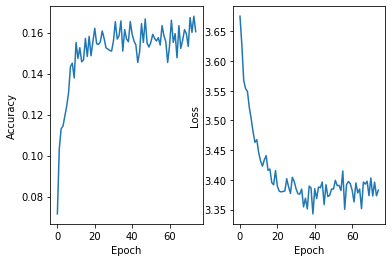

In [243]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)

    # Test without Dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
21 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (1, 50)
632/632 - 0s - loss: 6.2255 - sparse_categorical_accuracy: 0.1456
	Test accuracy: 0.14556962


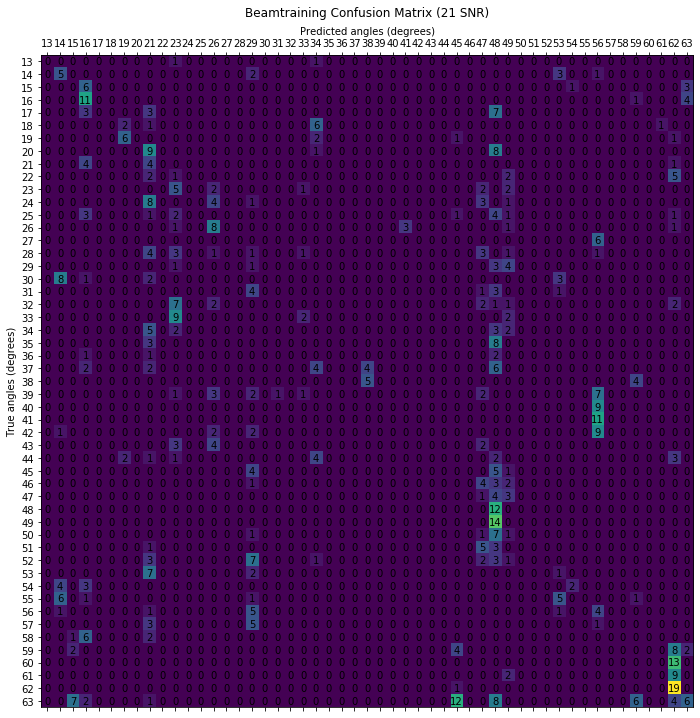

15 dB SNR --
(632, 51)
	labels:      (0, 50)
	predictions: (1, 50)
632/632 - 0s - loss: 9.1985 - sparse_categorical_accuracy: 0.1930
	Test accuracy: 0.19303797


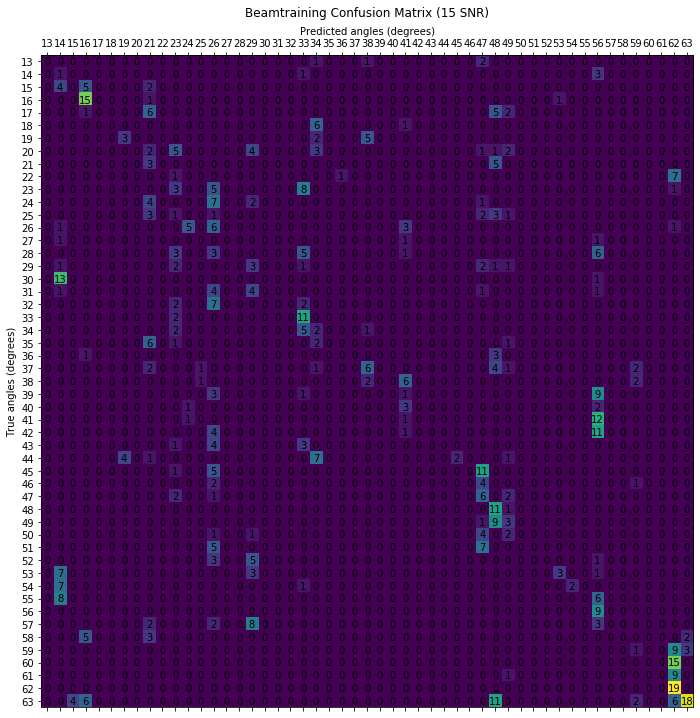

12 dB SNR --
(634, 51)
	labels:      (1, 50)
	predictions: (1, 50)
634/634 - 0s - loss: 6.5615 - sparse_categorical_accuracy: 0.1451
	Test accuracy: 0.14511041


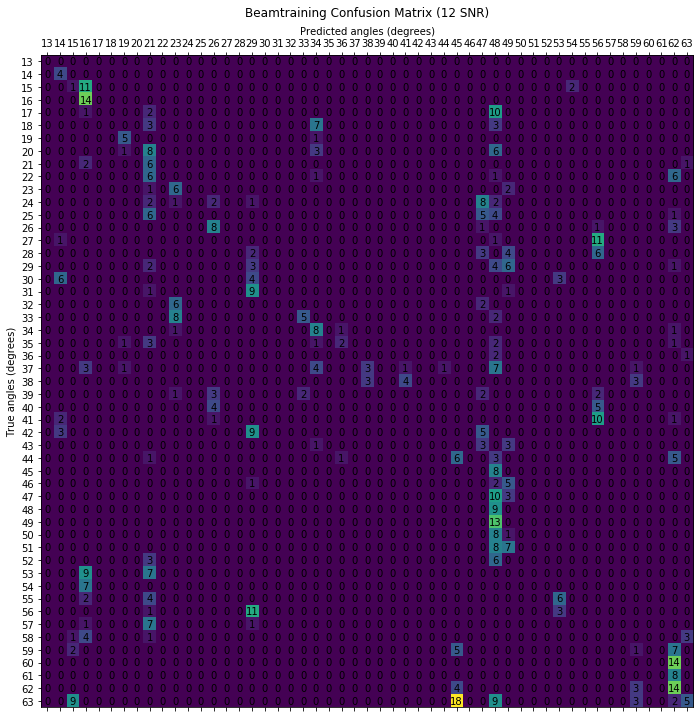

ALL SNR values --
(1898, 51)
	labels:      (0, 50)
	predictions: (1, 50)
1898/1898 - 0s - loss: 7.3277 - sparse_categorical_accuracy: 0.1612


C:\Users\Benjamin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


	Test accuracy: 0.16122234


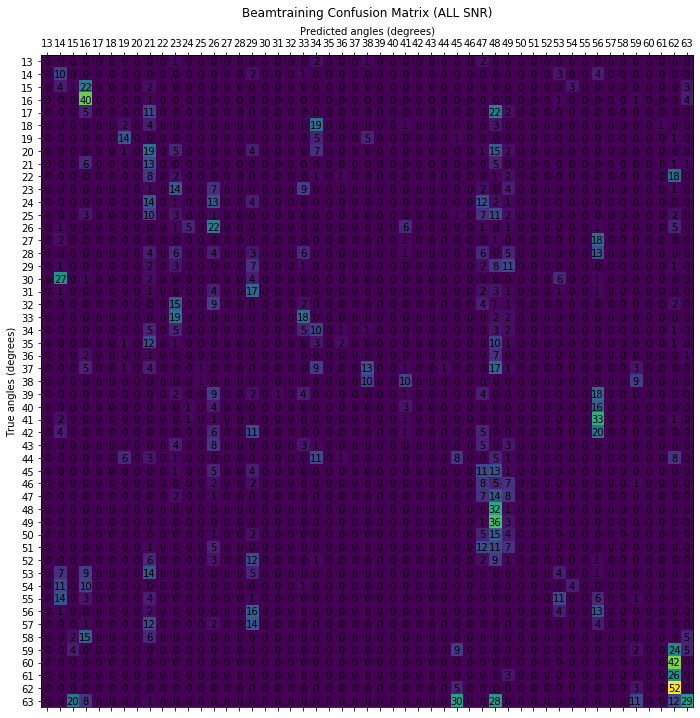


Number of results:            (1, 4)
Confusion matrix tensor size: (1, 4, 51, 51)
21 dB SNR --
15 dB SNR --
12 dB SNR --
21 dB SNR --
Gain Loss Percentiles, SNR 21
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         1.722189]
 [ 30.        11.759441]
 [ 40.        17.347074]
 [ 50.        23.211821]
 [ 60.        25.146528]
 [ 70.        28.014661]
 [ 80.        34.141861]
 [ 90.        35.650589]
 [100.        40.808683]]
15 dB SNR --
Gain Loss Percentiles, SNR 15
[[0.0000000e+00 0.0000000e+00]
 [1.0000000e+01 0.0000000e+00]
 [2.0000000e+01 8.7105000e-02]
 [3.0000000e+01 4.4960730e+00]
 [4.0000000e+01 1.4217071e+01]
 [5.0000000e+01 1.9734744e+01]
 [6.0000000e+01 2.3359024e+01]
 [7.0000000e+01 2.6090830e+01]
 [8.0000000e+01 2.8542021e+01]
 [9.0000000e+01 3.6138180e+01]
 [1.0000000e+02 3.9598837e+01]]
12 dB SNR --
Gain Loss Percentiles, SNR 12
[[  0.         0.      ]
 [ 10.         0.      ]
 [ 20.         2.880957]
 [ 30.        11.309553]
 [ 40.        15.371258]
 [ 50.

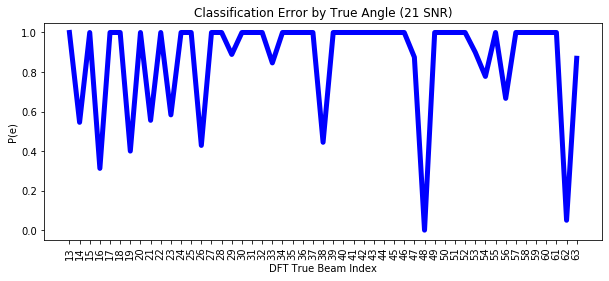

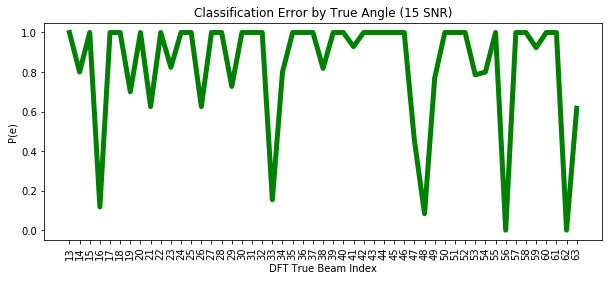

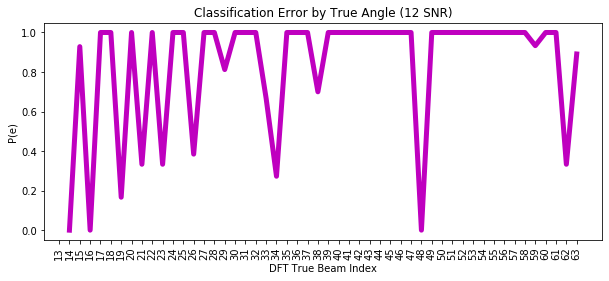

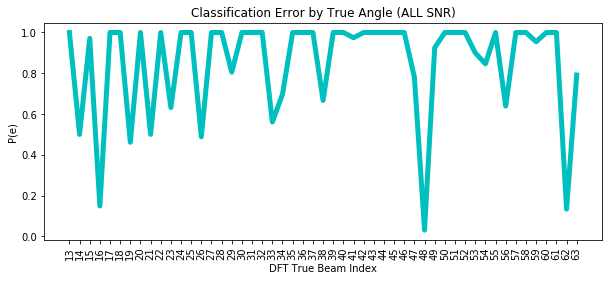

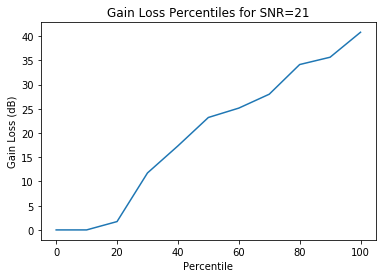

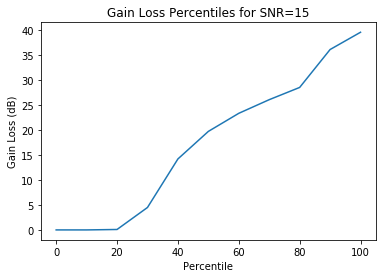

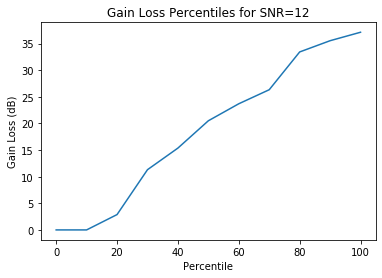

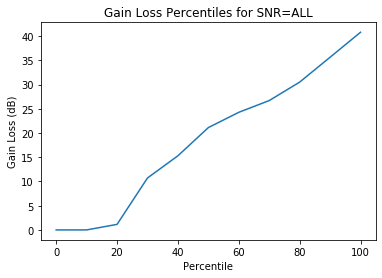

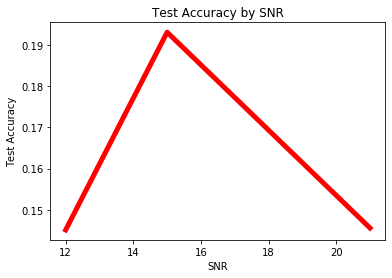

In [244]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array)

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {}
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        ## Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_real_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe
    
    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss    

## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);
    
# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)

# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe

In [64]:
print(len(all_curMeas_gainloss))
# print(test_data_dict[SNR_i][pn_i].shape)
# print(test_classes_dict[SNR_i][pn_i].shape)
# print(test_pred_classes.shape)
# print(test_predictions.shape)
# print(dft_use[test_classes_dict[SNR_i][pn_i]].flatten().shape)
# print(dft_rssi_dict[SNR_i][0][np.arange(len(dft_use[test_classes_dict[SNR_i][pn_i]])), dft_use[test_classes_dict[SNR_i][pn_i]].flatten()].shape)
# print(dft_use[test_pred_classes].shape)
# print()
# print(test_confusion.shape)
# print(max_gain.shape)
# print(dft_use[test_classes_dict[SNR_i][pn_i]].shape)
# print(dft_use[test_pred_classes].shape)
# print(dft_rssi_dict[SNR_i][pn_i][np.arange(len(dft_use[test_pred_classes])), dft_use[test_pred_classes]].shape)

1


# Overall Performance Curves

In [254]:
## Save total results to a pickle file
import pickle

## See how many results are available
print(len(all_test_acc))
print(len(all_confusionMat))
print(len(all_pe_byLabel))

print(all_test_acc.keys())
print(all_test_acc[2])

## Save to a pickle file
return # ONLY RUN IF YOU WANT TO OVERWRITE THE RESULTS SAVED
#TODO: SAVE ALL GAIN LOSS PERCENTILES AND MODELS TO AN OVERALL DICTIONARY
with open('all_NN_results.pkl', 'wb') as f:
    pickle.dump([all_test_acc, all_confusionMat, all_pe_byLabel], f)
    #TODO: ADD MORE VARS

14
14
14
dict_keys([5, 10, 15, 36, 9, 8, 7, 6, 4, 12, 16, 20, 3, 2])
[[0.14556962 0.19303797 0.14511041 0.16122234]]


In [ ]:
## Load the pickle file
return # ONLY RUN IF YOU WANT TO OVERWRITE THE RESULTS CAPTURED
with open('all_NN_results.pkl', 'rb') as f:
    all_test_acc, all_confusionMat, all_pe_byLabel = pickle.load(f)

(4, 20)

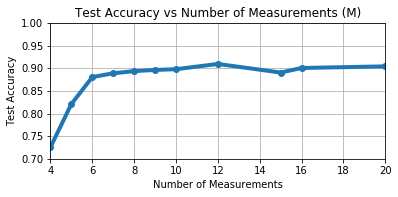

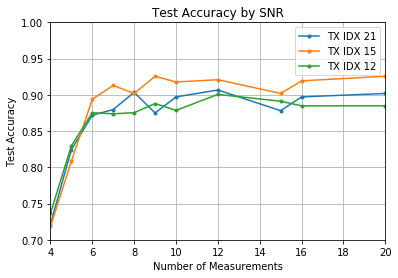

In [270]:
### Plot the overall results for the testing with all SNRs
included_num_meas = np.array([4, 5, 6, 7, 8, 9, 10, 12, 15, 16, 20])
plot_test_acc_allsnr = np.zeros((len(DATA_SNR)+1, len(included_num_meas)))

# Averaged over all PN beam combos
for m_i in np.arange(len(included_num_meas)):
    for snr_ind in np.arange(len(DATA_SNR)+1):
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
        else:
            SNR_i = 'ALL'
        temp_test_acc = all_test_acc[included_num_meas[m_i]]
        plot_test_acc_allsnr[snr_ind, m_i] = np.mean(temp_test_acc[:, snr_ind])

# Plot the result
# Plot of accuracy testing all SNRs together
fig = plt.figure()
plt.plot(included_num_meas, plot_test_acc_allsnr[len(DATA_SNR), :], marker="o", lw=4)
plt.title("Test Accuracy vs Number of Measurements (M)")
plt.xlabel("Number of Measurements")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.ylim(0.7, 1)
plt.yticks(np.arange(70, 105, 5)/100)
plt.xlim(np.min(included_num_meas),np.max(included_num_meas))
fig.set_size_inches(6, 2.5)
plt.savefig("../figures/nn_acc_allSNR.png")

# Plot of accuracy vs each SNR
plt.figure()
plt.plot(included_num_meas, plot_test_acc_allsnr[np.arange(len(DATA_SNR)), :].T, marker=".")
plt.title("Test Accuracy by SNR")
plt.xlabel("Number of Measurements")
plt.ylabel("Test Accuracy")
plt.legend(("TX IDX {}".format(DATA_SNR[0]), "TX IDX {}".format(DATA_SNR[1]), "TX IDX {}".format(DATA_SNR[2])))
plt.grid(True)
plt.ylim(0.7, 1)
plt.xlim(np.min(included_num_meas),np.max(included_num_meas))

(-15, 30)

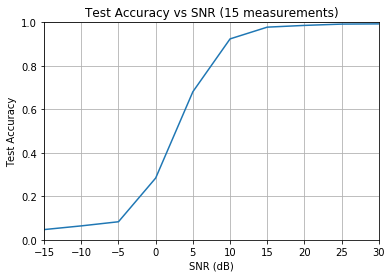

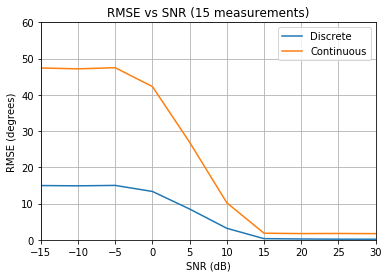

In [101]:
### Plot the overall results (i.e. anything stored in the dictionaries) ###

# Convert the dictionaries (for plotable metrics) into arrays
nSNR = len(SNR)
class_test_acc_arr = np.zeros(len(SNR), 2)
for iSNR in np.arange(nSNR):
    class_test_acc_arr[iSNR, 0] = SNR[iSNR]
    class_test_acc_arr[iSNR, 1] = class_test_acc[SNR[iSNR]]

# Store the results
all_test_acc[NUM_MEAS] = class_test_acc
all_confusionMat[NUM_MEAS] = class_confusionMat
all_RMSE_disc[NUM_MEAS] = class_RMSE_disc
all_RMSE_cont[NUM_MEAS] = class_RMSE_cont

# Plot of accuracy vs. SNR
plt.figure()
plt.plot(SNR, list(class_test_acc.values()))
plt.title("Test Accuracy vs SNR ({} measurements)".format(NUM_MEAS))
plt.xlabel("SNR (dB)")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.xlim(-15,30)

# Plot of RMSE vs. SNR
plt.figure()
plt.plot(SNR, list(class_RMSE_disc.values()))
plt.plot(SNR, list(class_RMSE_cont.values()))
plt.title("RMSE vs SNR ({} measurements)".format(NUM_MEAS))
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (degrees)")
plt.legend(("Discrete", "Continuous"))
plt.grid(True)
plt.ylim(0, 60)
plt.xlim(-15,30)


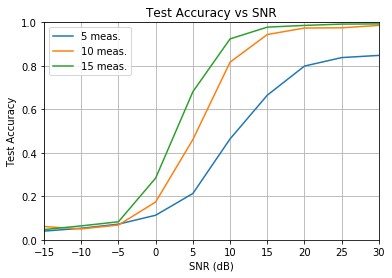

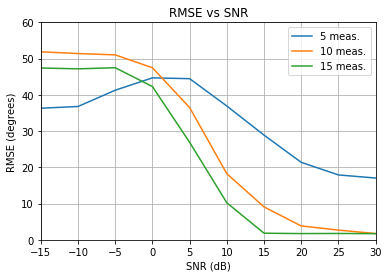

In [103]:
### Plot of the overall metric results for all measurement numbers ###
# Metrics stored in a dictionary of dictionaries
#     Top dictionary (all_*) uses the number of measurements as a key
#     Secondary dictionary (class_*) uses the SNR as a key
# Plots should overlay metric vs. SNR for each number of measurements

meas_plots = list(all_test_acc.keys())
NUM_PLOTS = len(meas_plots)
label_plots = []
for i in np.arange(NUM_PLOTS):
    label_plots.append("{} meas.".format(meas_plots[i]))

# Plot of accuracy vs. SNR
plt.figure()
for i in np.arange(NUM_PLOTS):
    plt.plot(SNR, list(all_test_acc[meas_plots[i]].values()))
plt.title("Test Accuracy vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.xlim(-15,30)
plt.legend(label_plots)
plt.savefig('../figures/nn_accuracy.png')

# Plot of RMSE vs. SNR
plt.figure()
for i in np.arange(NUM_PLOTS):
    plt.plot(SNR, list(all_RMSE_cont[meas_plots[i]].values()))
plt.title("RMSE vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (degrees)")
plt.grid(True)
plt.ylim(0, 60)
plt.xlim(-15,30)
plt.legend(label_plots)
plt.savefig('../figures/nn_rmse.png')


In [104]:
### Save the results to a CSV for later/combined plotting ###
all_test_res = pd.DataFrame(index=SNR.astype(int))
print(all_test_res.shape)
print(SNR)
for i in np.arange(NUM_PLOTS):
    all_test_acc_np = np.array(list(all_test_acc[meas_plots[i]].values()))
    all_rmse_cont_np = np.array(list(all_RMSE_cont[meas_plots[i]].values()))
    all_test_res.insert(loc=int(i), 
                        column="Accuracy_{}".format(label_plots[i]),
                        value=all_test_acc_np)
    all_test_res.insert(loc=int(i), 
                        column="RMSE_{}".format(label_plots[i]),
                        value=all_rmse_cont_np)

print(all_test_res)
all_test_res.to_csv("../data/classification_NN_results.csv", index=True)

(10, 0)
[-15 -10  -5   0   5  10  15  20  25  30]
     RMSE_5 meas.  RMSE_10 meas.  RMSE_15 meas.  Accuracy_15 meas.  \
-15     36.307964      51.869648      47.408928              0.047   
-10     36.784466      51.398037      47.175220              0.064   
-5      41.275127      51.028347      47.482777              0.083   
 0      44.687183      47.476574      42.285374              0.284   
 5      44.462864      36.485699      26.908812              0.681   
 10     36.920204      18.239145      10.213766              0.924   
 15     28.888153       9.073179       1.818401              0.978   
 20     21.375340       3.823220       1.717062              0.986   
 25     17.899832       2.673465       1.744454              0.992   
 30     17.044321       1.730174       1.695887              0.993   

     Accuracy_10 meas.  Accuracy_5 meas.  
-15              0.061             0.040  
-10              0.050             0.053  
-5               0.068             0.072  
 0     

# Regression Method - Continuous Angle Prediction
For data communication, a true angle prediction might be better than a discrete classification.  Classification heavily penalizes wrongly classifying to neighboring beams, even if the angle is almost exactly in between the two beam angles.  This may not be realistic for real-world implementations, as the actual beam may have significantly more angular control and thus could steer to the exact direction between the training beams.  Even without the ability to steer in any direction, classifying to neighboring beams should intuitively be better than classifying to further beams.

In [41]:
### Variable reorganization for regression (add another dimension) ###

# ALL DATA/LABEL/ANGLE VARIABLES FOR REGRESSION ARE LABELED AS "*_r" (where * is the original name used for classification)
USING_CNN_ARG = False

## Storage dictionaries/running variables for regression
train_data_dict_r = {}
test_data_dict_r = {}
val_data_dict_r = {}
train_angles_dict_r = {}
test_angles_dict_r = {}
val_angles_dict_r = {}
train_labels_dict_r = {}
test_labels_dict_r = {}
val_labels_dict_r = {}

# For the regression method with CNNs, need dimensions to be N x D x 1 (instead of N x D or D x N)
print("Modifying training/validation/testing datasets:")
for snr_i in np.arange(len(train_data_dict)):
    if USING_CNN_ARG:
        train_data_dict_r[SNR[snr_i]] = np.array([train_data_dict[SNR[snr_i]].T]).T
        train_labels_dict_r[SNR[snr_i]] = np.array([train_labels_dict[SNR[snr_i]].T]).T
        train_angles_dict_r[SNR[snr_i]] = np.array([train_angles_dict[SNR[snr_i]].T]).T

        val_data_dict_r[SNR[snr_i]] = np.array([val_data_dict[SNR[snr_i]].T]).T
        val_labels_dict_r[SNR[snr_i]] = np.array([val_labels_dict[SNR[snr_i]].T]).T
        val_angles_dict_r[SNR[snr_i]] = np.array([val_angles_dict[SNR[snr_i]].T]).T

        test_data_dict_r[SNR[snr_i]] = np.array([test_data_dict[SNR[snr_i]].T]).T
        test_labels_dict_r[SNR[snr_i]] = np.array([test_labels_dict[SNR[snr_i]].T]).T
        test_angles_dict_r[SNR[snr_i]] = np.array([test_angles_dict[SNR[snr_i]].T]).T
    
    else:
        train_data_dict_r[SNR[snr_i]] = train_data_dict[SNR[snr_i]]
        train_labels_dict_r[SNR[snr_i]] = train_labels_dict[SNR[snr_i]]
        train_angles_dict_r[SNR[snr_i]] = train_angles_dict[SNR[snr_i]]

        val_data_dict_r[SNR[snr_i]] = val_data_dict[SNR[snr_i]]
        val_labels_dict_r[SNR[snr_i]] = val_labels_dict[SNR[snr_i]]
        val_angles_dict_r[SNR[snr_i]] = val_angles_dict[SNR[snr_i]]

        test_data_dict_r[SNR[snr_i]] = test_data_dict[SNR[snr_i]]
        test_labels_dict_r[SNR[snr_i]] = test_labels_dict[SNR[snr_i]]
        test_angles_dict_r[SNR[snr_i]] = test_angles_dict[SNR[snr_i]]

    print("\ttrain: {}, val: {}, test: {}".format(train_data_dict_r[SNR[snr_i]].shape, 
                                                  val_data_dict_r[SNR[snr_i]].shape,
                                                  test_data_dict_r[SNR[snr_i]].shape))

# Need to reshape the overall training and validation sets too
if USING_CNN_ARG:
    train_data_all_r = np.array([train_data_all.T]).T
    val_data_all_r = np.array([val_data_all.T]).T
    train_angles_all_r = np.array([train_angles_all.T]).T
    val_angles_all_r = np.array([val_angles_all.T]).T
else:
    train_data_all_r = train_data_all
    val_data_all_r = val_data_all
    train_angles_all_r = train_angles_all
    val_angles_all_r = val_angles_all

print("Total training dataset size:   {}".format(train_data_all_r.shape))
print("Total validation dataset size: {}".format(val_data_all_r.shape))

Modifying training/validation/testing datasets:
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
Total training dataset size:   (70000, 15)
Total validation dataset size: (20000, 15)


In [28]:
### Dictionaries to hold metrics for different number of measurements ###
# RUN ONLY WHEN STARTING A NEW SET OF PLOTS
return # to prevent rerunning between different numbers of measurements
# Keys: Number of measurements used (i.e. 5, 10, or 15)
all_RMSE_reg = {}
all_acc_reg = {} # TODO


In [42]:
### Dictionaries to hold metrics for different runs ###
# Keys: SNR value
RMSE_reg = {}
acc_reg = {} # TODO


In [43]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Produces the best results - MAE = 17.6 (@10 measurements, 5dB SNR - still really high)

inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
#x = layers.Dense(64, activation='relu', name='dense_3')(x)
outputs = layers.Dense(1, name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)


## CNN architecture
# 1D convolutions with maxpooling
# batch norm to reduce initialization dependence

# model = keras.Sequential()

# model.add(layers.Conv1D(32, 3, activation='relu', padding='same', input_shape=(NUM_MEAS, 1)))
# model.add(layers.MaxPooling1D(2, padding='same'))
# model.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
# model.add(layers.MaxPooling1D(2, padding='same'))
# model.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
# model.add(layers.Flatten())

# # model.add(layers.Dense(64, input_dim=NUM_MEAS))
# # model.add(layers.BatchNormalization())
# # model.add(layers.Activation('relu'))

# model.add(layers.Dense(64))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# # #model.add(Dropout(0.5))

# model.add(layers.Dense(64))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# #model.add(Dropout(0.5))

# model.add(layers.Dense(1))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# #model.add(Dropout(0.5))


model.compile(optimizer=tf.keras.optimizers.Adam(0.001), #RMSprop(0.01), # # Optimizer
              # Loss function to minimize
              loss='mse',       # mean squared error
              # List of metrics to monitor
              metrics=['mae', 'mse'])  # mean absolute error

model.summary()

model.fit(train_data_all_r, train_angles_all_r, epochs=3, batch_size=NUM_MEAS,
          validation_data=(val_data_all_r, val_angles_all_r))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 15)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1024      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 1)                 65        
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________
Train on 70000 samples, validate on 20000 samples
Epoch 1/3
70000/70000 [==============================] - 9s 134us/sample - loss: 667.1582 - mae: 19.6238 - mse: 667.1575 - val_loss: 601.4920 - val_mae: 17.7873 - val_mse: 601.4926
Epoch 2/3
70000/70000 [=


-15 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 147.5195 - mae: 9.2804 - mse: 117.7993
	Test MSE: 117.79928
	Keras RMSE:  33.889206

-10 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 130.0401 - mae: 9.6180 - mse: 132.8101
	Test MSE: 132.81007
	Keras RMSE:  35.85139

-5 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 135.0462 - mae: 10.6879 - mse: 175.1465
	Test MSE: 175.14647
	Keras RMSE:  35.018875

0 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 225.8660 - mae: 13.5185 - mse: 286.8965
	Test MSE: 286.89655
	Keras RMSE:  32.322292

5 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 268.4444 - mae: 16.6299 - mse: 445.8639
	Test MSE: 445.86386
	Keras RMSE:  23.98994

10 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 846.7432 - mae: 21.8476 - mse: 725.3643
	Test MSE: 725.36426
	Keras RMSE:  13.325187

15 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 1321.6547 - mae: 24.2567 - mse: 841.4233
	Test MSE: 841.42334
	Keras RMSE:  7.92558

20 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 1008.9638 - mae: 25.7860 - mse: 919.3963
	Test MSE: 919.39

(-15, 30)

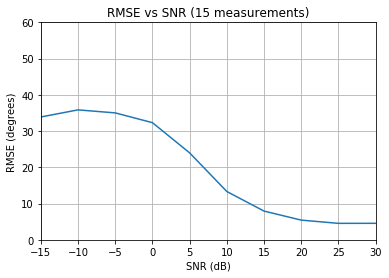

In [44]:
### Test the NN Model ###

for SNR_i in SNR:
    print("\n{} dB SNR --".format(SNR_i))
    test_pred_angles = model.predict(test_data_dict_r[SNR_i])
    print(test_pred_angles.shape)

    test_loss, test_mae, test_mse = model.evaluate(test_data_dict_r[SNR_i],  test_labels_dict_r[SNR_i], verbose=2)
    print('\tTest MSE:', test_mse)
    
    ## Compute the RMSE of the angles
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(test_angles_dict_r[SNR_i], test_pred_angles)
    rmse_keras = m.result().numpy()
    print('\tKeras RMSE: ', rmse_keras)
    
    RMSE_reg[SNR_i] = rmse_keras

    # Compute the predicted labels and the confusion matrix
#     test_pred_labels = np.argmax(test_predictions, 1)
#     test_confusion = tf.math.confusion_matrix(test_labels_dict[SNR_i],
#                                               test_pred_labels)
#     print(test_confusion)
#     class_confusionMat[SNR_i] = test_confusion

    ## Plot the confusion matrix (see which beams get associated with each other)
#     fig, ax = plt.subplots()
#     ax.matshow(test_confusion)
#     for (i, j), z in np.ndenumerate(test_confusion):
#         ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

#     ax.set_xticklabels(CLASSES)
#     ax.set_yticklabels(CLASSES)
#     ax.xaxis.set_label_position("top")
#     fig.set_size_inches(12, 12)
#     plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
#     plt.xlabel("Predicted angles (degrees)")
#     plt.ylabel("True angles (degrees)")
#     plt.xticks(np.arange(NUM_CLASSES))
#     plt.yticks(np.arange(NUM_CLASSES))
#     plt.savefig('../figures/confusionMatrix_reg_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
#     plt.show()

print("Number of results: {}".format(len(RMSE_reg)))

# Store the results
#all_test_acc[NUM_MEAS] = class_test_acc
all_RMSE_reg[NUM_MEAS] = RMSE_reg

# Plot of accuracy vs. SNR
# plt.figure()
# plt.plot(SNR, list(class_test_acc.values()))
# plt.title("Test Accuracy vs SNR ({} measurements)".format(NUM_MEAS))
# plt.xlabel("SNR (dB)")
# plt.ylabel("Test Accuracy")
# plt.grid(True)
# plt.ylim(0, 1)
# plt.xlim(-15,30)

# Plot of RMSE vs. SNR
plt.figure()
plt.plot(SNR, list(RMSE_reg.values()))
plt.title("RMSE vs SNR ({} measurements)".format(NUM_MEAS))
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (degrees)")
plt.grid(True)
plt.ylim(0, 60)
plt.xlim(-15,30)

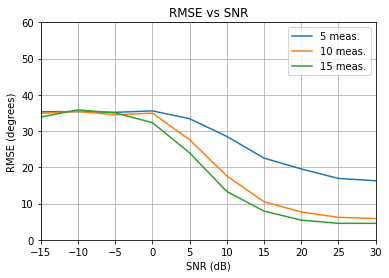

In [45]:
### Plot of the overall metric results for all measurement numbers ###
# Metrics stored in a dictionary of dictionaries
#     Top dictionary (all_*) uses the number of measurements as a key
#     Secondary dictionary (class_*) uses the SNR as a key
# Plots should overlay metric vs. SNR for each number of measurements

meas_plots = list(all_RMSE_reg.keys())
NUM_PLOTS = len(meas_plots)
label_plots = []
for i in np.arange(NUM_PLOTS):
    label_plots.append("{} meas.".format(meas_plots[i]))

# Plot of accuracy vs. SNR
# plt.figure()
# for i in np.arange(NUM_PLOTS):
#     plt.plot(SNR, list(all_test_acc[meas_plots[i]].values()))
# plt.title("Test Accuracy vs SNR")
# plt.xlabel("SNR (dB)")
# plt.ylabel("Test Accuracy")
# plt.grid(True)
# plt.ylim(0, 1)
# plt.xlim(-15,30)
# plt.legend(label_plots)
# plt.savefig('../figures/nn_accuracy.png')

# Plot of RMSE vs. SNR
plt.figure()
for i in np.arange(NUM_PLOTS):
    plt.plot(SNR, list(all_RMSE_reg[meas_plots[i]].values()))
plt.title("RMSE vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (degrees)")
plt.grid(True)
plt.ylim(0, 60)
plt.xlim(-15,30)
plt.legend(label_plots)
plt.savefig('../figures/nn_reg_rmse.png')


In [46]:
### Save the results to a CSV for later/combined plotting ###
all_test_res = pd.DataFrame(index=SNR.astype(int))
print(all_test_res.shape)
print(SNR)
for i in np.arange(NUM_PLOTS):
#     all_test_acc_np = np.array(list(all_test_acc[meas_plots[i]].values()))
#     all_test_res.insert(loc=int(i), 
#                         column="Accuracy_{}".format(label_plots[i]),
#                         value=all_test_acc_np)
    all_rmse_reg_np = np.array(list(all_RMSE_reg[meas_plots[i]].values()))
    all_test_res.insert(loc=int(i), 
                        column="RMSE_{}".format(label_plots[i]),
                        value=all_rmse_reg_np)

print(all_test_res)
all_test_res.to_csv("../data/regression_NN_results.csv", index=True)

(10, 0)
[-15 -10  -5   0   5  10  15  20  25  30]
     RMSE_5 meas.  RMSE_10 meas.  RMSE_15 meas.
-15     35.328289      34.888290      33.889206
-10     35.379852      35.416080      35.851391
-5      35.181820      34.488541      35.018875
 0      35.573147      34.953278      32.322292
 5      33.409790      27.597979      23.989941
 10     28.529898      17.621866      13.325187
 15     22.547327      10.511057       7.925580
 20     19.561069       7.668045       5.431944
 25     16.929165       6.201704       4.540309
 30     16.294001       5.887393       4.549653
